## Master ML Pipeline

### Imports


In [1]:
# Loading the key packages
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sklearn
import hyperopt
from hyperopt import hp
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import sklearn.calibration as cal
import xgboost as xgb
import sklearn.utils.class_weight as wt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from pathlib import Path
from sklearn import datasets, metrics, model_selection, svm
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import multiprocessing



In [2]:
from tensorflow.keras import models, layers, utils, backend as K, callbacks
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
#tensorflow.compat.v1.disable_v2_behavior() 
import random
import os

import warnings
#warnings.filterwarnings('ignore')


from numpy.ma import MaskedArray
import sklearn.utils.fixes

import miceforest as mf

sklearn.utils.fixes.MaskedArray = MaskedArray

tf.config.run_functions_eagerly(True)

2025-01-19 13:06:24.081865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging

# Configure the logging module
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [4]:
np.__version__

'1.23.5'

In [5]:
## Rays and tune imports
from tune_sklearn import TuneSearchCV

2025-01-19 13:06:29,886	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-19 13:06:30,161	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
#### USING PYTHON 3.11.0
print(sklearn.__version__)
print(shap.__version__)
print(tf.__version__)
print(pd.__version__)
print(np.__version__)
print(xgb.__version__)
print(tf.executing_eagerly())

'''
Should be: 
1.5.2
0.46.0
2.16.2
2.2.2
1.26.4
True
'''

'''
SHOUD BE THE FOLLOWING WITH 3.11.0
1.5.2
0.46.0
2.16.2
2.2.3
1.23.5
2.1.1
setuptools for conda == 41.0.0
True
'''

1.5.2
0.46.0
2.16.2
2.2.3
1.23.5
2.1.1
True


'\nSHOUD BE THE FOLLOWING WITH 3.11.0\n1.5.2\n0.46.0\n2.16.2\n2.2.3\n1.23.5\n2.1.1\nsetuptools for conda == 41.0.0\nTrue\n'

### Setup

In [7]:
# %% Initializing dataframes to store the results


all_results = []


# hyperparam_results = pd.DataFrame(
#     {
#         "Procedure": [],
#         "Outcome": [],
#         "Features": [],
#         "Model": [],
#         "Rep": [],
#         "Hyp_Name": [],
#         "Hyp_Value": []
#     }
# )



feature_results = []

auc_plot_results = []


# Areas which below pipeline will iterate through -- CHANGE THIS BASED ON NEED


#binary_outcomes = np.array(["readmission_binary", "major_med_comp", "extended_los", "returnor", "wnd_related_comp"])
#binary_outcomes = np.array(["readmission_binary"])
#binary_outcomes = np.array(["returnor", "any_med_comp_no_wnd", "any_med_comp_wnd", "any_comp_overall"])
binary_outcomes = ["High_Health_Utilizer"]

#continuous_outcomes = np.array(["outpatient_resource_sum", "los_days"])
#continuous_outcomes = np.array(['los_days'])

continuous_outcomes = []


outcomes = binary_outcomes + continuous_outcomes

#procedures = ["Microdisc", "Foraminotomy", "Laminectomy", "AXDLIF", "PLF", "PTLIF"]
procedures = ["Fusion", "Decompression"]


#features = ["Spine_Institution", "Spine_NSQIP", "Peripheral_NSQIP"]
#features = ["Spine_Institution"]
#features = ["Peripheral_NSQIP"]
#features = ["PLS_features"]
features = ["Health_Util_Features"]
feature = features[0]

model_set = ["RF", "ENet", "XGBoost", "NN", "ASA", "Dummy"]
#model_set = ["RF"]

#model_set = ["XGBoost"]
#model_set = ["Dummy"]



repetitions = list(range(10)) #TODO: Change to range(10)
date = "01_14_25"
impute_iterations = 2 #TODO CHANGE TO 2
tunesearch_iterations = 10 #TODO: Switch to 10
Get_shaps = False #TODO: DO I WANT SHAPS?
procedure_of_interest = "Fusion" #TODO: Change procedure-of-interest
pickle_folder_name = "Labs" # Change when doing a different pickling #NoLabs
FullDataset_model = "RF"
feature_perturbation_version = "tree_path_dependent" #TODO: For full dataset model RF


# Functions

## Setup


In [8]:
def reset_random_seed(rep):
    
    tf.keras.backend.clear_session()

    os.environ['PYTHONHASHSEED']=str(rep)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    tf.random.set_seed(rep)
    np.random.seed(rep)
    random.seed(rep)


In [9]:
def load_data(procedure):
    readdata = pd.read_csv(r"122124_Spine_Reports.csv", sep=',')
    
    if procedure == "Fusion":
        readdata = readdata[
            (readdata['cpt_thoracolumbar_sacro_arthrodesis'] == True) &
            (readdata['cohort_query_lumbar'] == True)
            ]
    elif procedure == "Decompression":
        readdata = readdata[
            (readdata['cpt_thoracolumbar_sacro_arthrodesis'] == False) & 
            (readdata['cohort_query_spinal_decompression'] == True) & 
            (readdata['cohort_query_lumbar'] == True)
        ]


    readdata = readdata.reset_index(drop=True)
    return readdata

In [10]:
def preop_to_binary(input_df):
    df = input_df.copy()
    # Get all columns that start with "preop_med_"
    preop_med_cols = [col for col in df.columns if col.startswith('preop_med_')]
    print(f"There are {len(preop_med_cols)} preop columns")

    # Check for missing values first
    missing_values = {col: df[col].isna().sum() 
                    for col in preop_med_cols 
                    if df[col].isna().any()}

    if missing_values:
        raise ValueError(f"Missing values found in the following columns: {missing_values}")

    # Convert to boolean if no missing values found
    for col in preop_med_cols:
        # Store original values for verification
        original_values = df[col].value_counts()
        
        # Convert: 0 -> False, >=1 -> True
        df[col] = df[col] > 0
        
        # Print verification of the conversion
        print(f"\nColumn: {col}")
        print("Original value counts:")
        print(original_values)
        print("New value counts:")
        print(df[col].value_counts())
    return df

In [11]:
def add_columns_remove_rows(input_df):

    df = input_df.copy()
    # Recode categorical columns
        # anesthesia_type
    df['anesthesia_type_General'] = df['anesthesia_type'].apply(
        lambda x: 1 if pd.notna(x) and str(x).upper() == 'GENERAL'
                  else (0 if pd.notna(x)  # if it's not NaN and not 'GENERAL', return 0
                        else np.nan)  # if it's NaN, return np.nan
    )
    df['anesthesia_type_General'] = df['anesthesia_type_General'].astype('Int64')
    
    #procedure_setting
    df['procedure_setting_Inpatient'] = df['procedure_setting'].apply(lambda x: 1 if str(x).upper() == 'INPATIENT' 
                                            else (0 if str(x).upper() == 'OUTPATIENT' 
                                            else np.nan))
    df['procedure_setting_Inpatient'] = df['procedure_setting_Inpatient'].astype('Int64')
    # Recode gender into new binary column
    df['gender_female'] = df['gender'].apply(lambda x: 1 if str(x).upper() == 'F' 
                                           else (0 if str(x).upper() == 'M' 
                                           else np.nan))
    df['gender_female'] = df['gender_female'].astype('Int64')

    # add allograft and autograft columns
    df['cpt_allograft'] = df['procedure_codes'].str.contains('20930|20931').astype(bool)
    df['cpt_autograft'] = df['procedure_codes'].str.contains('20936|20937|20938').astype(bool)

    # Anterior approach codes
    df['cpt_anterior_approach'] = df['procedure_codes'].str.contains(
        '22556|22558|22586|22808|22810|22812'
    ).astype(bool)

    # Lateral approach codes
    df['cpt_lateral_approach'] = df['procedure_codes'].str.contains(
        '22533|22534'
    ).astype(bool)

    # Posterior approach codes
    df['cpt_posterior_approach'] = df['procedure_codes'].str.contains(
        '22610|22612|22800|22802|22804|22630|22632|22633|22634|27279|27280'
    ).astype(bool)

    # Convert surgery_start_datetime to datetime type if it isn't already
    df['surgery_start_datetime_date'] = pd.to_datetime(df['surgery_start_datetime'])
    df['surgery_end_datetime_date'] = pd.to_datetime(df['surgery_end_datetime'])
    df['patient_in_or_datetime_date'] = pd.to_datetime(df['patient_in_or_datetime'])
    df['patient_out_or_datetime_date'] = pd.to_datetime(df['patient_out_or_datetime'])
    df['anesthesia_start_datetime_date'] = pd.to_datetime(df['anesthesia_start_datetime'])
    df['anesthesia_stop_datetime_date'] = pd.to_datetime(df['anesthesia_stop_datetime'])
    
    # Create date filters
    start_date = pd.to_datetime('2003-01-01')
    end_date = pd.to_datetime('2022-10-01')
    
    df = df[
        # Date conditions
        (df['surgery_start_datetime_date'] >= start_date) & 
        (df['surgery_start_datetime_date'] < end_date) &
        # Age filter - exclude patients under 18
        (df['age_at_procedure'] >= 18) &
        # Previous conditions (negated)
        ~(df['spine_preop_tumor'] | 
          df['spine_preop_trauma'] | 
          df['spine_preop_infection'] |
          df['cpt_tumor'] |
          df['cpt_trauma'] | 
          df['spine_preop_curvature'] |
          df['cpt_deformity']|
          df['cpt_infection'])
    ]



    # Remove neg los patient 1338489,"2012-05-02 09:43:00"
    df = df[~((df['ir_id'] == 1338489) & 
                   (df['surgery_start_datetime'] == "2012-05-02 09:43:00"))]

    df = df.reset_index(drop=True)


    ### Clean BMI: Make NA for >100 and =0
    df.loc[(df['BMI'] > 100) | (df['BMI'] == 0), 'BMI'] = np.nan

    ### Clean Anesthesia: Make NA for >=20
    df.loc[df['anesthesia_duration_hours'] >= 20, 'anesthesia_duration_hours'] = np.nan


    # Make columns in hours and minutes for surgery length
    # Calculate lengths
    df['OR_length_hours'] = ((df['patient_out_or_datetime_date'] - 
                                df['patient_in_or_datetime_date']).dt.total_seconds() / 3600).round()
    df['OR_length_minutes'] = ((df['patient_out_or_datetime_date'] - 
                                    df['patient_in_or_datetime_date']).dt.total_seconds() / 60).round()

    df['anesthesia_length_hours'] = ((df['anesthesia_stop_datetime_date'] - 
                                    df['anesthesia_start_datetime_date']).dt.total_seconds() / 3600).round()
    df['anesthesia_length_minutes'] = ((df['anesthesia_stop_datetime_date'] - 
                                        df['anesthesia_start_datetime_date']).dt.total_seconds() / 60).round()
    
    df['surgery_length_hours'] = ((df['surgery_end_datetime_date'] -
                                    df['surgery_start_datetime_date']).dt.total_seconds() / 3600).round()
    df['surgery_length_minutes'] = ((df['surgery_end_datetime_date'] -
                                    df['surgery_start_datetime_date']).dt.total_seconds() / 60).round()

    # Handle missing values
    OR_missing = df['patient_in_or_datetime_date'].isna() | df['patient_out_or_datetime_date'].isna()
    anesthesia_missing = df['anesthesia_start_datetime_date'].isna() | df['anesthesia_stop_datetime_date'].isna()
    surgery_missing = df['surgery_start_datetime_date'].isna() | df['surgery_end_datetime_date'].isna()

    df.loc[OR_missing, ['OR_length_hours', 'OR_length_minutes']] = np.nan
    df.loc[anesthesia_missing, ['anesthesia_length_hours', 'anesthesia_length_minutes']] = np.nan
    df.loc[surgery_missing, ['surgery_length_hours', 'surgery_length_minutes']] = np.nan

    # Convert to integer type (while preserving NaN values)
    length_columns = ['OR_length_hours', 'OR_length_minutes',
                    'anesthesia_length_hours', 'anesthesia_length_minutes',
                    'surgery_length_hours', 'surgery_length_minutes']
    df[length_columns] = df[length_columns].astype('Int64')  # Int64 allows for NaN values

     ### Clean Anesthesia: Make NA for >=20
    df.loc[df['anesthesia_length_hours'] >= 20, 'anesthesia_length_hours'] = np.nan
    df.loc[df['anesthesia_length_minutes'] >= 20*60, 'anesthesia_length_minutes'] = np.nan

    ### clean surgery: make NA for > 1000 hours or eqivalent minutes
    df.loc[df['surgery_length_hours'] >= 20, 'surgery_length_hours'] = np.nan
    df.loc[df['surgery_length_minutes'] >= 20*60, 'surgery_length_minutes'] = np.nan



    return df
    
    

In [12]:
def remove_labs_90(df):

    input_df = df.copy()

    # Create columns lists for days_before
    CBC_cols = ["CBC_MONOCYTES", "CBC_NEUTROPHILS", "CBC_BASOPHILS", "CBC_PLATELET_COUNT",
                    "CBC_WBC_COUNT", "CBC_HEMOGLOBIN", "CBC_RBC_COUNT",
                    "CBC_RDW", "CBC_HEMATOCRIT", "CBC_MCH", "CBC_MCHC",
                    "CBC_ABSOLUTE_LYMPHOCYTES", "CBC_ABSOLUTE_NEUTROPHILS",
                    "CBC_LYMPHOCYTE", "CBC_EOSINOPHILS", "CBC_ABSOLUTE_EOSINOPHILS",
                    "CBC_ABSOLUTE_BASOPHILS", "CBC_ABSOLUTE_MONOCYTES"]
    
    CBC_date_cols = [col + "_days_before_surgery" for col in CBC_cols]
        
    BMP_cols = ["BMP_POTASSIUM", "BMP_CREATININE", "BMP_BUN", "BMP_CALCIUM", "BMP_CHLORIDE", 
                    "BMP_SODIUM", "BMP_CO2", "BMP_GLUCOSE", "BMP_GFR"]
    BMP_date_cols = [col + "_days_before_surgery" for col in BMP_cols]

    lab_cols = CBC_cols + BMP_cols
    lab_days_before = CBC_date_cols + BMP_date_cols
    lab_pairs = [(lab_cols[i], lab_days_before[i]) for i in range(len(lab_cols))]
    print(lab_pairs)

    def extract_days(x):
        if pd.isna(x):
            return np.nan
        # Extract just the number before "days"
        try:
            return float(str(x).split()[0])
        except:
            return np.nan
    # Process each pair of columns
    for lab_col, days_col in lab_pairs:
        # Convert the days strings to numbers
        days = input_df[days_col].apply(extract_days)

        # Create a mask for values > 90 days
        mask = days > 90
        
        # Set the lab values to NaN where mask is True
        input_df[lab_col] = input_df[lab_col].mask(mask)


    return input_df
    

In [13]:
def set_columns(data, outcome, pofI):
    individual_features_shap_full = []
    # Basic demographics = age, sex, race (not present), BMI
    basic_demographics = ["ir_id", "surgery_start_datetime", "age_at_procedure", "gender_female", "BMI"]

    #Med hx: include all of the comorbidities with the elix_ prefix. 
    # Those are based on the Elixhauser comorbidity guidelines and 
    # are the most comprehensive. We broke out several other frailty
    #  tools (CCI, MFI, etc) but these are ultimately duplicative 
    # and not as comprehensive (i.e. don’t worry about including). 
    # I do not believe elixhauser has anything on tobacco. 
    # If ther isn’t, then use validation_fmr_tobacco and 
    # validation_cur_tobacco.

    Medhx = ["elix_aids_hiv", "elix_lymphoma", "elix_paralysis",
            "elix_psychoses", "elix_depression", "elix_drug_abuse", "elix_weight_loss",
            "elix_coagulopathy", "elix_alcohol_abuse", "elix_liver_disease", "elix_renal_failure",
            "elix_hypothyroidism", "elix_valvular_disease", "elix_blood_loss_anemia",
            "elix_deficiency_anemia", "elix_metastatic_cancer", "elix_cardiac_arrhythmia",
            "elix_rheumatoid_arhritis", "elix_diabetes_complicated", "elix_diabetes_uncomplicated", 
            "elix_congestive_heart_failure", "elix_hypertension_complicated", "elix_chronic_pulmonary_disease",
            "elix_solid_tumor_wo_metastasis", "elix_hypertension_uncomplicated", "elix_other_neurological_disorder",
            "elix_peripheral vascular_disorder", "elix_pulmonary_circulation_disorder", "elix_fluid_and_electrolyte_disorders",
            "elix_peptic_ulcer_disease_excluding_bleeding", "validation_cur_tobacco", "validation_fmr_tobacco"]
    
    #Surg hx: look at the shx_ prefix variables and include those

    Surghx = ["shx_cervical_fusion", "shx_cervical_surgery", "shx_thoracolumbar_fusion",
                "shx_thoracolumbar_surgery", "shx_unspecified_spine_fusion", "shx_unspecified_spine_surgery"]
    
    #Spine-specific preop pathology: lumbar stenosis, lumbar spondy, 
    # lumbar disc disorders, lumbar disc herniation (all binary columns)
    SpineSpecific = ["lumbar_stenosis", "lumbar_spondy", "lumbar_disc_disorders",
                        "cervical_disc_diorders", "cervical_stenosis", "cervical_spondy",
                        "cervical_disc_herniation", "lumbar_disc_herniation", "spine_preop_pseudoarthrosis_post_fusion", "spine_preop_post_laminectomy_syndrome"]

    #Medication hx: look for preop_med_ suffix. Also just focus on 90
    #  days preop for this analysis. Exclude anything with _sorg in the
    #  name (that is for a separate validation analysis)

    Medicationhx = ["preop_med_90days_ace_inhibitor", "preop_med_90days_arb", "preop_med_90days_antidepressant",
                "preop_med_90days_beta_2_agonist", "preop_med_90days_beta_blocker", "preop_med_90days_benzodiazepine",
                "preop_med_90days_immunosuppresant", "preop_med_90days_nsaid", "preop_med_90days_opioid", "preop_med_90days_anti_psychotic",
                "preop_med_90days_neuromodulator", "preop_med_90days_biphosphonate", "preop_med_90days_loop_diuretic",
                "preop_med_90days_thiazide_diuretic", "preop_med_90days_cinacalcet", "preop_med_90days_insulin", 
                "preop_med_90days_oral_diabetes", "preop_med_90days_calcium_supplement", "preop_med_90days_vit_d_supplement"]

    #Surgical characteristics: inpatient versus outpatient, type of anesthesia 
    # (should almost always be general, but a few weird ones here and there), 
    # OR duration, anesthesia duration, cpt_multilevel, cpt_grafts, 
    # cpt_instrumentation (tell us more about what was done during the case)

    SurgCharsNumeric = ["asa_class", "OR_length_minutes",
                        "cpt_multilevel", "cpt_instrumentation", 
                        "cohort_query_microdisc", "anesthesia_type_General", "procedure_setting_Inpatient"]
    
    Approaches = ["cpt_anterior_approach", "cpt_lateral_approach", "cpt_posterior_approach"]

    #Add approach columns if Fusion
    if pofI == "Fusion":
        SurgCharsNumeric = SurgCharsNumeric + Approaches

    #SurgCharsCat = ["anesthesia_type", "procedure_setting"]

    # CBC and BMP, all with <50% missing values

    CBC_cols = ["CBC_MONOCYTES", "CBC_NEUTROPHILS", "CBC_BASOPHILS", "CBC_PLATELET_COUNT",
                "CBC_WBC_COUNT", "CBC_HEMOGLOBIN", "CBC_RBC_COUNT",
                "CBC_RDW", "CBC_HEMATOCRIT", "CBC_MCH", "CBC_MCHC",
                "CBC_ABSOLUTE_LYMPHOCYTES", "CBC_ABSOLUTE_NEUTROPHILS",
                "CBC_LYMPHOCYTE", "CBC_EOSINOPHILS", "CBC_ABSOLUTE_EOSINOPHILS",
                "CBC_ABSOLUTE_BASOPHILS", "CBC_ABSOLUTE_MONOCYTES"]
    
    BMP_cols = ["BMP_POTASSIUM", "BMP_CREATININE", "BMP_BUN", "BMP_CALCIUM", "BMP_CHLORIDE", 
                "BMP_SODIUM", "BMP_CO2", "BMP_GLUCOSE", "BMP_GFR"]
    
    
    

    outcome = [outcome]
    ## Set Lab columns
    labCols = BMP_cols + CBC_cols
    if pickle_folder_name == "NoLabs":
        all_columns = basic_demographics + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "Labs":
        all_columns = basic_demographics + BMP_cols + CBC_cols + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "Testing":
        all_columns = basic_demographics + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "TestingLabs":
        all_columns = basic_demographics + BMP_cols + CBC_cols + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome

    df = data[all_columns].copy()

    ## Fix ASA class
    df['asa_class'] = df['asa_class'].replace(0, np.nan)

    
    #df['asa_above_2'] = np.where(df['asa_class'] >= 3, 1, 0)
    

    #dum_cols = ["anesthesia_type", "procedure_setting"]

    numeric_features = ["age_at_procedure", "BMI", "OR_length_minutes"]
    
        # Convert preop columns to boolean
    preop_columns = [col for col in df.columns if col.startswith('preop')]
    print(f"{len(preop_columns)} Preop Columns")

    
    for col in preop_columns:
        trueBefore = sum(df[col] == True)
        df[col] = df[col].astype('boolean')
        # df[col] = df[col].astype('float')
        df[col] = df[col].astype('Int64') # Just convert to Int64
        # df[col] = df[col].fillna(0) #fill na as 0 in binary conversion
        trueAfter = sum(df[col] == True)
        if trueBefore != trueAfter:
            raise ValueError(f"""
            Column {col} has different number of True values after conversion!
            Before: {trueBefore} True values
            After: {trueAfter} True values
            Difference: {trueAfter - trueBefore}
            """)
        else: 
            print("All preop conversions good!")
    

    ## Change these float columns to ints

    to_int_cols = ["age_at_procedure", 'OR_length_minutes']

    for col in to_int_cols:
        df[col] = df[col].astype("Int64")

    
    ## ADD Lab columns to numeric_features
    if pickle_folder_name in ["Labs", "TestingLabs"]:
        numeric_features = numeric_features + labCols
        print("adding lab columns to numeric_features") 
        for col in labCols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Ensure the column dtype is float
            df[col] = df[col].astype('float')
    
    #Convert "object" columns to categorical (NO CATEGORICAL COLUMNS NOW)
    '''
    objectcols = SurgCharsCat
    for col in objectcols:
        df[col] = df[col].astype('category')
    '''

    # Create ASA df
    df_asa = df[['ir_id', 'surgery_start_datetime', 'asa_class', outcome[0]]].copy()
    df_asa['asa_class'] = df_asa['asa_class'].astype("Int64")

    #remove ASA from df
    df = df.drop('asa_class', axis=1)
    
        
    return df, df_asa, numeric_features, individual_features_shap_full

In [14]:
## Create new dfs for predictors, preds+dummies, and ys

def separate_dfs(df, outcome):
    """
    Separates a dataframe into three separate dataframes: predictors, dummies, and ys.

    Args:
        df (pandas.DataFrame): The input dataframe.
        dum_cols (list): A list of column names that are dummy variables. NO MORE DUM COLUMNS

    Returns:
        tuple: A tuple containing three dataframes: (df_preds, dum_df, y).
    """
    #df = df.dropna().reset_index(drop=True) # drop missing variables
    
    y = df[outcome].values

    df_preds = df.drop(columns = [outcome])

    #dum_df = pd.get_dummies(df_preds, columns= dum_cols)

    return df_preds, y

In [15]:
# Function for feature + outcome combo NOT USED YET
'''
def full_feature_outcome_test(feature, outcome):
   
   Function to do the entire test for a feature + outcome combo
   Inputs: feature (string), outcome (string)
   
   n = len(df)
   label_n = sum(y)
   return 

'''

'\ndef full_feature_outcome_test(feature, outcome):\n   \n   Function to do the entire test for a feature + outcome combo\n   Inputs: feature (string), outcome (string)\n   \n   n = len(df)\n   label_n = sum(y)\n   return \n\n'

## Functions to be repeated



In [16]:
### Formulating the preprocessor for scaling and stratified folds

def scaleAnd_skf(numeric_features, outcome, rep, fulldataset = False):
     # Formulating the preprocessor for scaling
    scaler = preprocessing.RobustScaler()

    if fulldataset:
        preprocessor = ColumnTransformer([('robust', scaler, numeric_features)], remainder = 'passthrough', verbose_feature_names_out=False)
    else:
        preprocessor = ColumnTransformer([('minmax', scaler, numeric_features)], remainder = 'passthrough')

    if outcome in binary_outcomes:
        
        skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = rep) #TODO: Change back to 5

    elif outcome in continuous_outcomes:
        
        print("In Progress")
    
    return preprocessor, skf

### To do within each traintest split

In [17]:
## Save the dtypes for the xtrain_std and x_test_std

def save_dtypes(df, original_df, preprocessor):
    feature_names = preprocessor.get_feature_names_out()
    df = pd.DataFrame(df, columns=feature_names, index=original_df.index)
    df.columns = [col.replace('minmax__', '') for col in df.columns]
    df.columns = [col.replace('remainder__', '') for col in df.columns]
    for col in df.columns:
        if col in original_df.columns:
            #print("Good")
            #print(col)

            #df[col] = df[col].astype(original_df[col].dtype)
            df[col] = df[col].astype('float64')

        else:
            print("ERROR")
            #print(col)
    return df
    

In [18]:
## Any extra missing values filled in using mode/median of same dataset

def post_imputation_cleanup(data):
    total_replaced = 0
    for col in data.columns:
        if data[col].isnull().any():
            nan_count_before = data[col].isnull().sum()
            if data[col].dtype.name == 'category':
                # For categorical data, use mode if it exists
                if not data[col].mode().empty:
                    data[col].fillna(data[col].mode()[0], inplace=True)
            elif data[col].dtype.kind in 'biufc':  # boolean, integer, unsigned integer, float, complex
                # For numeric data, use median if it exists and is not null
                median = data[col].median()
                if pd.notnull(median):
                    data[col].fillna(median, inplace=True)
            else:
                # For other types (like object), use mode if it exists
                if not data[col].mode().empty:
                    data[col].fillna(data[col].mode()[0], inplace=True)
            
            nan_count_after = data[col].isnull().sum()
            replaced = nan_count_before - nan_count_after
            total_replaced += replaced

            print(f"Column '{col}': {replaced} NaN values replaced")

            
            # Check if there are still NaN values after imputation
            if data[col].isnull().any():
                print(f"Warning: Column '{col}' still contains NaN values after imputation.")
    
    return data

In [19]:
def imputeData(x_train, y_train, x_test, y_test, rep, impute_number):
    # Combine x_train and y_train for imputation
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)

    train_data = x_train.copy()
    train_data['target'] = y_train

    # Create and fit the imputation kernel
    
    kernel = mf.ImputationKernel(
        train_data,
        random_state=rep,
        variable_schema = NaNColumn_list
    )
    
    # Use sklearn pipeline method (as in examples)
    pipe = Pipeline([('impute', kernel)])
    
    # Perform imputation
    #kernel.mice(impute_number, verbose=True)  # Run 5 iterations, adjust as needed
    
    # Get the imputed training data
    #imputed_train = kernel.complete_data()

    imputed_train = pipe.fit_transform(train_data, impute__iterations = impute_number,
                                       impute__verbose=True)
    
    #imputed_train = post_imputation_cleanup(imputed_train)

    assert not np.any(np.isnan(imputed_train))

    # Separate features and target
    x_train_imputed = imputed_train.drop('target', axis=1)
    y_train_imputed = imputed_train['target']

    # Combine Test data
    test_data = x_test.copy()
    #test_data['target'] = y_test
    test_data['target'] = np.nan 
    test_data['target'] = test_data['target'].astype('bool')# add dummy target column
    # Impute test data
    test_imputed = pipe.transform(test_data)
    #test_imputed = kernel.transform(test_data)
    #test_imputed = post_imputation_cleanup(test_imputed)
    x_test_imputed = test_imputed.drop('target', axis=1)

    assert not np.any(np.isnan(x_test_imputed))

    y_test_imputed = y_test

    
    return x_train_imputed, y_train_imputed, x_test_imputed, y_test_imputed


In [20]:
#### Create training, test, validation sets and additional sets
def set_train_test(input_df, y, train_index, test_index, rep, preprocessor, impute_number,
                   want_val = False):
    # Split into train and test

    # NEED TO HAVE DUMMYS HERE AFTER IMPUTATION! do in impute_data

    # dum_df cut out asa_class column
    # x_train_asa = asa_class.iloc[train_index].copy()
    # x_test_asa = asa_class.iloc[test_index].copy()
    # add these two to the output of set_train_test
        
    x_train_split = input_df.iloc[train_index].copy()
    x_test_split = input_df.iloc[test_index].copy()
    y_train_split = y[train_index].copy()
    y_test_split = y[test_index].copy()
    
    
    # Peel off validation set

    x_train_actual_split, x_val_split, y_train_actual_split, y_val_split = train_test_split(x_train_split,
                                                                                            y_train_split, stratify = y_train_split,
                                                                                            test_size = 0.1, random_state = rep) # random process


    # Remove mrn and surgery start datetime and include that as the actual train and test
        
        
    #if feature == mainfeature:
        
    print("Test")

    if want_val:

        x_train_actual = x_train_actual_split.drop(columns = ["ir_id", "surgery_start_datetime"])
        x_val = x_val_split.drop(columns = ["ir_id", "surgery_start_datetime"])
        y_train_actual = y_train_actual_split.copy()
        y_val = y_val_split.copy()

        # IMPUTED VALUES
        x_train_actual, y_train_actual, x_val, y_val = imputeData(x_train_actual, y_train_actual, x_val, y_val, rep, impute_number)
    else:
        x_train_actual = None
        x_val = None
        y_train_actual = None
        y_val = None



    x_train = x_train_split.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_test = x_test_split.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_test_id_cols = x_test_split[["ir_id", "surgery_start_datetime"]]
    x_test_id_cols = x_test_id_cols.reset_index(drop=True)
    y_train = y_train_split.copy()
    y_test = y_test_split.copy()

    #IMPUTED VALUES
    x_train, y_train, x_test, y_test = imputeData(x_train, y_train, x_test, y_test, rep, impute_number)
    
    
    x_train_std = preprocessor.fit_transform(x_train)
    x_train_std = save_dtypes(x_train_std, x_train, preprocessor)
    x_test_std = preprocessor.transform(x_test)
    x_test_std = save_dtypes(x_test_std, x_test, preprocessor)



    # Keep a version that has those values as index columns 

    x_test_features = x_test.copy() #use imputed data
    # Add back the identifier columns
    x_test_features = pd.concat([x_test_id_cols, x_test_features], axis=1)

    x_test_features["Patient_ID"]=  np.arange(len(x_test_features))

    x_test_features_long = pd.melt(x_test_features, id_vars = ["ir_id", "Patient_ID", "surgery_start_datetime"], var_name = "Feature_Name", value_name = "Feature_Actual_Value" )
    
    x_test_features_long['Feature_Actual_Value'] = pd.to_numeric(x_test_features_long['Feature_Actual_Value'])

    x_cols = x_test.columns

    n_features = len(x_cols)
    
    return x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, x_test_features_long, n_features, x_cols, x_train_std, x_test_std

### All the different Models

In [21]:
## ASA model - only works for binary outcomes

def ASA_model(x_train, x_test, y_train, rep):

    '''
    Input: x_train: training data from train-test set
           x_test: test data from train-test set
           y_train: training labels from train-test set
           rep: random state for reproducibility

    Output: cv_model: trained logistic regression model
            y_pred: predicted labels for test set
            y_prob_vec: predicted probabilities for test set
    '''

    # Extract ASA class feature
    trim_train = x_train[["asa_class"]].copy()
    trim_test = x_test[["asa_class"]].copy()

    # Fit logistic regression model
    cv_model = linear_model.LogisticRegression(penalty=None, random_state=rep)
    cv_model.fit(trim_train, y_train)

    # Make predictions
    y_pred = cv_model.predict(trim_test)
    y_prob = cv_model.predict_proba(trim_test)
    y_prob_vec = y_prob[:, 1]

    return cv_model, y_pred, y_prob_vec

In [22]:
## ASA Categorical model -> <=2 and >2
def ASA_categorical_model(x_test):
    
    x_test['asa_above_2'] = np.where(x_test['asa_class'] >= 3, 1, 0)

    trim_test_categorical = x_test["asa_above_2"]


    y_pred = trim_test_categorical.values.reshape(-1,1)
    y_prob = trim_test_categorical.values.reshape(-1,1)
    y_prob_vec = trim_test_categorical.values.reshape(-1,1)
    #print(y_prob_vec)
    return y_pred, y_prob_vec

In [23]:
def ENet_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): column_name of outcome variable
            preprocessor (obj): standardizing preprocessing object
            x_train (df): training data from train-test set
            y_train (df): training outcome variable from train-test set
            x_test (df): test data from train-test set
            x_train_std (df): standardized training data
            x_test_std (df): standardized test data

    Outputs: cv_model (obj): best model from bayesian optimization
             y_pred (arr): predicted values for test set
             y_prob_vec (arr): predicted probability values for test set
             shap_values (arr): shap values for test set
    '''
    if outcome in binary_outcomes:
        '''
        y_train_df = pd.DataFrame(y_train, columns = ["y_train"])
        All_train = pd.concat([x_train, y_train_df], axis = 1)

        kernel = mf.ImputationKernel(
            All_train,
            random_state=rep,
            variable_schema = NaNColumn_list
        )
        '''
        pipe = Pipeline([   #('impute', kernel),
                            ('processing', preprocessor), 
                            ('estimator', linear_model.LogisticRegression(penalty = 'elasticnet', 
                                                                        solver='saga', 
                                                                        class_weight = 'balanced',
                                                                        random_state = rep, 
                                                                        max_iter = 1000
                                                                        ))])

        fit_params = {'impute__iterations': impute_iterations,
                      'impute__verbose': True}
        model_params = {'estimator__C': Real(1e-2, 1e2, prior = 'log-uniform'),
                        'estimator__l1_ratio': Real(0, 1)
                        }
        hyperopt_model_params = {
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
            'estimator__l1_ratio': hp.uniform('estimator__l1_ratio', 0, 1)
                                 }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = hyperopt_model_params, 
                                search_optimization="hyperopt",
                                verbose = 2,
                                scoring='roc_auc', # auc is most important metric
                                refit=True,
                                cv=5,
                                n_jobs = 7,
                                n_trials = tunesearch_iterations, 
                                random_state = rep
                                )

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.predict_proba(x_test)
        y_prob_vec = y_prob[:,1]


    elif outcome in continuous_outcomes:

        print("In Progress")


    if Get_shaps:
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_std)
        shap_values = explainer.shap_values(x_test_std)
        print("SHAPS DONE")
    else:
        shap_values = None
        print("NO SHAPS FOOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [24]:
def XGBoost_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:

        weight_vec = wt.compute_sample_weight(class_weight = "balanced", y = y_train) # compute weights using sklearn
#        eval_weight = wt.compute_sample_weight(class_weight = "balanced", y = y_val)

        pipe = Pipeline([('processing', preprocessor), 
                            ('estimator', xgb.XGBClassifier(#n_estimators = 500,
                                                            #eval_metric = "auc",
                                                            use_label_encoder=False,
                                                            verbosity = 1, random_state = rep
                                                        ))]) 


        es = xgb.callback.EarlyStopping(
            rounds = 10,
            save_best=True,
        )
        print(f"XShape: {x_train.shape}")

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 2, 10),
            'estimator__subsample': hp.uniform('estimator__subsample', 0.5, 1.0),
            'estimator__learning_rate': hp.uniform('estimator__learning_rate', 0.1, 0.5),
            'estimator__colsample_bytree': hp.uniform('estimator__colsample_bytree', 0.5, 1.0),
            'estimator__colsample_bylevel': hp.uniform('estimator__colsample_bylevel', 0.5, 1.0),
            'estimator__min_child_weight': hp.uniformint('estimator__min_child_weight', 1, 10),
            'estimator__gamma': hp.uniform('estimator__gamma', 0, 1.0),
            'estimator__reg_lambda': hp.loguniform('estimator__reg_lambda', np.log(1e-2), np.log(1e2)),
            'estimator__reg_alpha': hp.loguniform('estimator__reg_alpha', np.log(1e-2), np.log(1e2)),
        }

        fit_params = {#'estimator__sample_weight_eval_set': [eval_weight],
#                                          'estimator__eval_set': [(x_val_std, y_val)],
#                                          'estimator__callbacks': [es],
                        'estimator__sample_weight': weight_vec,
#                                          'estimator__early_stopping_rounds': 10

        }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', 
                                refit=True, cv= 5, 
                                n_jobs = 7, random_state = rep, 
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train, **fit_params)



        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.predict_proba(x_test) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        print("In Progress")



    if Get_shaps:
        explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], data=x_train_std, model_output = "probability")
        shap_values = explainer.shap_values(x_test_std)
        print(shap_values.shape)
        test = shap_values[0] # TODO: Check if 0 is correct here if needed
        print(test.shape)
        print("SHAPS DONE")
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values

In [25]:
def RF_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep, n_features_in, Interventional):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:

        pipe = Pipeline([('processing', preprocessor), 
                            ('estimator', BalancedRandomForestClassifier(random_state = rep,
                                                                         sampling_strategy='all',
                                                                         replacement=True,
                                                                         bootstrap=False
                                                                         ))]) 

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_features': hp.uniformint('estimator__max_features', 2, n_features_in),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 1, 25),
            'estimator__min_samples_split': hp.uniformint('estimator__min_samples_split', 2, 10),
            'estimator__min_samples_leaf': hp.uniformint('estimator__min_samples_leaf', 1, 5),
        }

        cv_model = TuneSearchCV(pipe,
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', # AUC is most important metric
                                refit=True, cv=5, n_jobs = 7,
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_test) # generate prediction (0 or 1)
        y_prob = cv_model.predict_proba(x_test) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        print("In Progress")

    if Get_shaps:
        if Interventional:
            print("DOING INTERVENTIONAL")
            explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], data=x_train_std, feature_perturbation= "interventional",
                                       model_output = "probability")
        else:
            print("DOING PATH DEPENDENT")
            explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], feature_perturbation= "tree_path_dependent")
        shap_values = explainer.shap_values(x_test_std)
        print(shap_values.shape)
        shap_values = shap_values[:, :, 1]
        print(shap_values.shape)
        print("GET SHAPS")
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [26]:
def Dummy_model(outcome, x_train, y_train, x_test):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''
    if outcome in binary_outcomes:

        dummy_clf = DummyClassifier(strategy="prior")
        dummy_clf.fit(x_train, y_train)

        y_pred = dummy_clf.predict(x_test)
        y_prob = dummy_clf.predict_proba(x_test)
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        dummy_clf = DummyRegressor(strategy="median")
        dummy_clf.fit(x_train, y_train)

        y_pred = np.round(dummy_clf.predict(x_test))

    return dummy_clf, y_pred, y_prob_vec


In [27]:
def NN_model(outcome, preprocessor, x_train_actual, y_train_actual, x_val, y_val, x_test, n_features, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    #tf.config.run_functions_eagerly(True)

    if outcome in binary_outcomes:

        x_train_actual_std = preprocessor.fit_transform(x_train_actual)
        x_train_actual_std = save_dtypes(x_train_actual_std, x_train_actual, preprocessor)
        x_val_std = preprocessor.transform(x_val)
        x_val_std = save_dtypes(x_val_std, x_val, preprocessor)

#       x_train_std = preprocessor.fit_transform(x_train)
        x_test_std = preprocessor.transform(x_test)
        x_test_std = save_dtypes(x_test_std, x_test, preprocessor)

        reset_random_seed(rep)


        metric_set=[tf.keras.metrics.AUC(name="auc")]



        weight_vec = wt.compute_sample_weight(class_weight = "balanced", y = y_train_actual) # compute weights using sklearn
        eval_weight = wt.compute_sample_weight(class_weight = "balanced", y = y_val)


        # Convert data to TensorFlow datasets
        #train_dataset = tf.data.Dataset.from_tensor_slices((x_train_actual_std, y_train_actual, weight_vec))
        #train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

        #val_dataset = tf.data.Dataset.from_tensor_slices((x_val_std, y_val, eval_weight))
        #val_dataset = val_dataset.batch(32)


        nn_model = tf.keras.Sequential(name="DeepNN_CLF", layers=[

            # Input layer is implicitly defined here

            ### hidden layer 1
            tf.keras.layers.Dense(name="h1", input_dim=n_features,
                            units=int(round((n_features+1)/2)), 
                            activation='relu'),

            ### dropout layer 1
            tf.keras.layers.Dropout(name="drop1", rate=0.2, seed = rep),

            ### hidden layer 2
            tf.keras.layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                            activation='relu'),

            ### dropout layer 2
            tf.keras.layers.Dropout(name="drop2", rate=0.2, seed = rep),

            ### layer output
            tf.keras.layers.Dense(name="output", units=1, activation='sigmoid')
        ])

        nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = metric_set)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_auc', 
            verbose=1,
            patience=10,
            mode='max',
            restore_best_weights=True)

        history = nn_model.fit(
            x_train_actual_std,
            y_train_actual,
            epochs= 100, #TODO: Change back to 100
            sample_weight=weight_vec,
            batch_size=32, #added
            callbacks=[early_stopping],
            validation_data=(x_val_std, y_val, eval_weight),
        )

        y_prob = nn_model.predict(x_test_std) 
        y_pred = (y_prob > 0.5).astype("int32")                 
        y_prob_vec = y_prob.flatten()

        nn_model.summary()

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.tight_layout()
        plt.show()


    elif outcome in continuous_outcomes:

        print("In Progress")


    # SHAP values calculation
    '''
    tf.config.run_functions_eagerly(False)
    print(tf.executing_eagerly())
    background = shap.sample(x_train_actual_std, 100)  # Use a subset of training data as background
    explainer = shap.DeepExplainer(nn_model, background)
    shap_values = explainer.shap_values(x_test_std.values)
    shap_values = shap_values[:, :, 0]
    print(shap_values.shape)
    tf.config.run_functions_eagerly(True)
    '''
    
    
    #explainer = shap.DeepExplainer(nn_model, data=x_train_actual_std)
    #print(type(x_test_std))
    #shap_values = explainer.shap_values(x_test_std)
    #print(shap_values.shape)

    return nn_model, y_pred, y_prob_vec


In [28]:

def Linear_SVC_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            x_train_std (pd.DataFrame): standardized training data
            x_test_std (pd.DataFrame): standardized test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:


        pipe = Pipeline([('processing', preprocessor),
                         ('estimator', sklearn.svm.LinearSVC(random_state=rep,
                                                             dual=False,
                                                             max_iter=1000,
                                                             class_weight='balanced' ))])

        model_params = {
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
        }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = model_params, 
                                scoring='roc_auc', # auc is most important metric
                                refit=True, 
                                cv=5, n_jobs = 7,
                                n_trials = tunesearch_iterations, 
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2
                                )        
        
        cv_model.fit(x_train, y_train)

        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.decision_function(x_test)
        y_prob_vec = 1 / (1 + np.exp(-y_prob))

    elif outcome in continuous_outcomes:
        print("In Progress")

    if Get_shaps:
        print("GET SHAPS")
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_std)
        shap_values = explainer.shap_values(x_test_std)
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [29]:
from sklearn.kernel_approximation import Nystroem


def SVC_model_with_kernels(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            x_train_std (pd.DataFrame): standardized training data
            x_test_std (pd.DataFrame): standardized test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:
        pipe = Pipeline([
            ('processing', preprocessor),
            ('nystroem', Nystroem(random_state=rep)),
            ('estimator', LinearSVC(random_state=rep, dual=False, max_iter=1000, class_weight='balanced'))
        ])

        model_params = {
            'nystroem__kernel': hp.choice('nystroem__kernel', ['rbf', 'poly', 'sigmoid']),
            'nystroem__n_components': hp.uniformint('nystroem__n_components', 50, 200),
            'nystroem__gamma': hp.loguniform('nystroem__gamma', np.log(1e-3), np.log(1e1)),
            'nystroem__degree': hp.uniformint('nystroem__degree', 2, 6),  # Integer values from 2 to 5
            'nystroem__coef0': hp.uniform('nystroem__coef0', 0, 1),  # Uniform distribution between 0 and 1
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
        }
        '''
        # Define separate search spaces for each kernel
        linear_params = {}  # No additional parameters for linear kernel
        rbf_params = {
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
        }
        poly_params = {
            'nystroem__degree': Integer(2, 5),
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
            'nystroem__coef0': Real(0, 1),
        }
        sigmoid_params = {
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
            'nystroem__coef0': Real(0, 1),
        }

        # Combine the search spaces based on the kernel
        search_spaces = model_params.copy()
        search_spaces.update(linear_params if 'linear' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(rbf_params if 'rbf' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(poly_params if 'poly' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(sigmoid_params if 'sigmoid' in search_spaces['nystroem__kernel'] else {})
        '''
        
        cv_model = TuneSearchCV(
            pipe, 
            param_distributions=model_params, 
            scoring='roc_auc',
            refit=True, 
            cv=5,
            n_jobs=7,
            n_trials=tunesearch_iterations,  # Increased due to larger search space
            random_state=rep,
            search_optimization = "hyperopt",
            verbose = 2
        )        
        
        cv_model.fit(x_train, y_train)
        best_params = cv_model.best_params_
        best_kernel = best_params['nystroem__kernel']
        #best_gamma = best_params['nystroem__gamma']
        print(f"Best kernel: {best_kernel}")
        #print(f"Best gamma: {best_gamma}")

        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.decision_function(x_test)
        y_prob_vec = 1 / (1 + np.exp(-y_prob))

    elif outcome in continuous_outcomes:
        print("In Progress")
        return

    # Transform the data using the fitted Nystroem approximation
    nystroem = cv_model.best_estimator_.named_steps['nystroem']
    x_train_nystroem = nystroem.transform(x_train_std)
    x_test_nystroem = nystroem.transform(x_test_std)
    print(type(nystroem.components_))
    print(nystroem.components_.shape)

    if Get_shaps:
        print("GET SHAPS")
        #For SHAP values, we'll use KernelExplainer as LinearExplainer won't work with the kernel approximation
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_nystroem)
        shap_values = explainer.shap_values(x_test_nystroem)
        print(shap_values.shape)
    else:
        print("NO SHAPS FOR YOU")
        shap_values = None

    return cv_model, y_pred, y_prob_vec, shap_values, best_kernel


In [30]:
print(shap.__version__)

0.46.0


## Function for Results

In [31]:
from datetime import datetime
import math

def log_execution(csv_path, name_of_model, start_time):
    end_time = time.time()
    total_seconds = end_time - start_time
    
    # Calculate minutes and seconds
    minutes = math.floor(total_seconds / 60)  # Get complete minutes
    seconds = round(total_seconds % 60)  # Get remaining seconds, rounded
    
    # Create new row
    new_row = {
        'model_name': name_of_model,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'execution_time_minutes': minutes,
        'execution_time_seconds': seconds
    }
    
    # Read existing CSV, append new row, and save
    try:
        df = pd.read_csv(csv_path)
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    except FileNotFoundError:
        # If file doesn't exist, create new DataFrame
        df = pd.DataFrame([new_row])
    
    df.to_csv(csv_path, index=False)


In [32]:
def collect_results(results_list, auc_plot_list, outcome, procedure, feature, model_name, rep, i, n, label_n, y_test, y_prob_vec, y_pred):
    """
    Collects and computes performance metrics for binary classification models.

    This function calculates various performance metrics for binary classification models and stores them in a results dataframe.
    It also generates ROC curve data for plotting.

    Parameters:
        results_list (list): List to store performance metric results
        auc_plot_list (list): List to store ROC curve plotting data
        outcome (str): Name of the outcome being predicted
        procedure (str): Name of the procedure being analyzed
        feature (str): Name/description of features used
        model_name (str): Name of the model used
        rep (int): Repetition number
        i (int): Fold number for cross-validation
        n (int): Total number of samples
        label_n (int): Number of labeled samples
        y_test (array-like): True labels
        y_prob_vec (array-like): Predicted probabilities
        y_pred (array-like): Predicted labels

    Returns:
        None - Updates results_list and auc_plot_list in place

    Metrics calculated:
    - AUC (Area Under ROC Curve)
    - Sensitivity/Recall
    - Specificity
    - PPV (Positive Predictive Value)
    - NPV (Negative Predictive Value) 
    - Log Loss
    - Brier Score
    - Weighted F1 Score
    - Accuracy
    - Balanced Accuracy
    - Confusion Matrix

    The function only processes binary classification outcomes (checks if outcome is in binary_outcomes).
    Results are stored in a pandas DataFrame and appended to the input lists.
    """

    if outcome in binary_outcomes:
        # Computing AUC
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob_vec, pos_label = 1)
        roc_auc = metrics.auc(fpr, tpr)
        AUC = metrics.auc(fpr, tpr)

        print(f"AUC: {AUC}")
        logging.info(f"AUC, Logging: {AUC}")
        # Sensitivity, Specificity

        recall_score_0 = metrics.recall_score(y_test,y_pred, pos_label=0)
        recall_score_1 = metrics.recall_score(y_test,y_pred, pos_label=1)

        # PPV, NPV
        precision_score_0 = metrics.precision_score(y_test,y_pred, pos_label=0)
        precision_score_1 = metrics.precision_score(y_test,y_pred, pos_label=1)

        # Computing Log Loss
        log_loss = metrics.log_loss(y_test, y_prob_vec, labels = [0,1])

        # Computing Brier score
        brier_loss = metrics.brier_score_loss(y_test, y_prob_vec, pos_label = 1)

        # Computing WF1
        W_F1= metrics.f1_score(y_test, y_pred, average='weighted')

        # Computing Accuracy
        accuracy_score = metrics.accuracy_score(y_test,y_pred)
        B_accuracy_score = metrics.balanced_accuracy_score(y_test,y_pred)


        # Confusion Matrix
        c_mat = metrics.confusion_matrix(y_test, y_pred)

        new_results = pd.DataFrame(
            {
                "Procedure": [procedure],
                "Outcome": [outcome],
                "Features": [feature],
                "Model": [model_name],
                "Rep": [rep],
                "Fold": [i],
                "W_F1": [W_F1],
                "AUC": [AUC],
                "MAE": ["NA"],
                "R2": ["NA"],
                "RMSE": ["NA"],
                "Log-Loss": [log_loss],
                "Brier-Loss": [brier_loss],
                "Accuracy": [accuracy_score],
                "Balanced_Accuracy": [B_accuracy_score],
                "Sensitivity": [recall_score_1],
                "Specificity": [recall_score_0],
                "NPV": [precision_score_0],
                "PPV": [precision_score_1],
                "c_matrix": [c_mat],
                "n":[n],
                "label_n": [label_n]
            }
        )

        auc_plot_results_new = pd.DataFrame(
            {
                "Procedure": np.repeat(procedure, len(fpr)),
                "Outcome": np.repeat(outcome, len(fpr)),
                "Features": np.repeat(feature, len(fpr)),
                "Model": np.repeat(model_name, len(fpr)),
                "Rep": np.repeat(rep, len(fpr)),
                "Fold": np.repeat(i, len(fpr)),
                "FPR": fpr,
                "TPR": tpr,
                "Thresholds": threshold
            }
        )
        #print(len(fpr))
        auc_plot_list.append(auc_plot_results_new)

        results_list.append(new_results)

    return


In [33]:
def collect_shap_results(individual_features_shap_full_list, feature_results_list, shap_values, y_test, x_cols, x_test_features_long, outcome, procedure,
                         feature, model_name, rep, i, svcKernel = False):
    
    '''
    Inputs: individual_features_shap_full: empty shap list

    Outputs: shap_file_results: dataframe of shap values for each patient and feature
    '''
    mod_shap = shap_values.copy()
    #mod_shap = shap_values[0]

    test_length = len(y_test)

    row_vec = list(range(0, test_length))
    shap_features_row = []
    if svcKernel:
        print(x_cols)
    for row in row_vec:

        shap_values_row = mod_shap[row]

        temp_feature_names = list(x_cols) #CHECK here
        



        new_shap_features_row = pd.DataFrame(
            {
                "Patient_ID": np.repeat(row, len(x_cols)),
                "Feature_Name": temp_feature_names,
                "Feature_Value": shap_values_row,
                "Feature_Abs_Value": np.abs(shap_values_row),

            }
        )

        shap_features_row.append(new_shap_features_row)




    shap_features_tabular = pd.concat(shap_features_row)



    individual_features_shap = x_test_features_long.merge(shap_features_tabular, how = "left", on = ["Patient_ID", "Feature_Name"])

    individual_features_shap["Procedure"]=  procedure
    individual_features_shap["Outcome"]=  outcome
    individual_features_shap["Model"]=  model_name
    individual_features_shap["Rep"]=  rep
    individual_features_shap["Fold"]=  i


    individual_features_shap_full_list.append(individual_features_shap)

    summarized_features_shap = shap_features_tabular.groupby(['Feature_Name']).agg(   
        Feature_Mean_Abs = ('Feature_Abs_Value','mean'),
    ).reset_index()


    feature_coef = summarized_features_shap['Feature_Mean_Abs'].values
    feature_names = summarized_features_shap['Feature_Name'].values


    new_features = pd.DataFrame(
        {
            "Procedure": np.repeat(procedure, len(feature_names)),
            "Outcome": np.repeat(outcome, len(feature_names)),
            "Features": np.repeat(feature, len(feature_names)),
            "Model": np.repeat(model_name, len(feature_names)),
            "Rep": np.repeat(rep, len(feature_names)),
            "Fold": np.repeat(i, len(feature_names)),
            "Feature_Name": feature_names,
            "Feature_Mean_Abs_Value": feature_coef,

        }
    )


#                    feature_results = feature_results.append(new_features, ignore_index=True)
    feature_results_list.append(new_features)


    return

In [34]:
#pip install shap==0.41.0 --user
print(shap.__version__)


0.46.0


# Code

## Code Setup

In [35]:
# Load data 
## TEST WITH FUSION FIRST

print(procedure_of_interest)
data_non_binary = load_data(procedure_of_interest)
#data = pd.read_csv(r"081524_Spine_reports_vf.csv", sep=',')

Fusion


/var/folders/92/tt9zk05n4qd65slhpygj9v4r0000gr/T/ipykernel_31258/3567218305.py:2: DtypeWarning: Columns (73,74,75,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,455,456,460,462,464,466,468,470,471,474,476,478,480,481,482,490,492,493,494,495,496,497,498,499,500,502,504,506,508,510,511,512,516,518,520,522,523,524,526,528,529,531,532,534,537,538,539,540,541,542,544,545,546,547,548,550,551,552,553,554,555,557,560,561,562,563,564,566,568,570,571,574,575,576,577,583,585,586,587,588,589,590,591,592,593,596,600,601,605,606,607,609,610,612,613,614,616,618,619,620,622,624,625,626,628,629,634,635,636,637,638,642,643,646,650,652,653,654,658,660,662,664,666,668,671,673,675,677,679,681,682,683,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,708,709,710,711,714,716,717,719,720,722,725,728,729,732,736,737,740,743,744,746,747,750,751,754,766,767,768,769,772,773,782,783,784,785,786,787,788,789,792,793,794,795,796,797,814,815,822,823,830,831,83

In [36]:
outcomes

['High_Health_Utilizer']

In [37]:
##Convert to binary preop_meds
data = preop_to_binary(data_non_binary)

There are 66 preop columns

Column: preop_med_90days_ace_inhibitor
Original value counts:
preop_med_90days_ace_inhibitor
0    4286
1     432
2      25
3       1
Name: count, dtype: int64
New value counts:
preop_med_90days_ace_inhibitor
False    4286
True      458
Name: count, dtype: int64

Column: preop_med_90days_arb
Original value counts:
preop_med_90days_arb
0    4307
1     405
2      32
Name: count, dtype: int64
New value counts:
preop_med_90days_arb
False    4307
True      437
Name: count, dtype: int64

Column: preop_med_90days_antidepressant
Original value counts:
preop_med_90days_antidepressant
0    3757
1     852
2     127
3       8
Name: count, dtype: int64
New value counts:
preop_med_90days_antidepressant
False    3757
True      987
Name: count, dtype: int64

Column: preop_med_90days_beta_2_agonist
Original value counts:
preop_med_90days_beta_2_agonist
0    3864
1     609
2     207
3      51
4      12
5       1
Name: count, dtype: int64
New value counts:
preop_med_90days_beta

In [38]:

file_name_base = procedure_of_interest+"_"+date+"_"
file_name_base

'Fusion_01_14_25_'

In [39]:
#full_feature_outcome_test(feature="PLS_features", outcome="Post_lam_syndrome")
data.shape

(4744, 985)

In [40]:
sum(data['gender'] == 'U')

0

In [41]:
### Set up what columns to use 
## Testing with fusion first
# Set feature, outcome
mainfeature = "Health_Util_Features"
outcome = outcomes[0]
print(outcome)
data_new = add_columns_remove_rows(data)
print(data_new.shape)

High_Health_Utilizer
(2890, 1005)


In [42]:
# BMP missing columns

bmp_columns = [col for col in data_new.columns if col.startswith('BMP')]
# Calculate the percentage of missing values for each of these columns
missing_percentages = data_new[bmp_columns].isnull().mean() * 100

# Convert the result to a DataFrame for better readability
BMP_missing_df = pd.DataFrame({'Column': missing_percentages.index, 'Percent Missing': missing_percentages.values})
BMP_missing_df.to_csv(f"{procedure_of_interest}_{pickle_folder_name}_BMP_missing.csv", index=False)

# CBC missing columns

cbc_columns = [col for col in data_new.columns if col.startswith('CBC')]
# Calculate the percentage of missing values for each of these columns
missing_percentages = data_new[cbc_columns].isnull().mean() * 100

# Convert the result to a DataFrame for better readability
CBC_missing_df = pd.DataFrame({'Column': missing_percentages.index, 'Percent Missing': missing_percentages.values})
CBC_missing_df.to_csv(f"{procedure_of_interest}_{pickle_folder_name}_CBC_missing.csv", index=False)


In [43]:
# Remove Labs
data_null_labs = remove_labs_90(data_new)
print(data_null_labs.shape)


[('CBC_MONOCYTES', 'CBC_MONOCYTES_days_before_surgery'), ('CBC_NEUTROPHILS', 'CBC_NEUTROPHILS_days_before_surgery'), ('CBC_BASOPHILS', 'CBC_BASOPHILS_days_before_surgery'), ('CBC_PLATELET_COUNT', 'CBC_PLATELET_COUNT_days_before_surgery'), ('CBC_WBC_COUNT', 'CBC_WBC_COUNT_days_before_surgery'), ('CBC_HEMOGLOBIN', 'CBC_HEMOGLOBIN_days_before_surgery'), ('CBC_RBC_COUNT', 'CBC_RBC_COUNT_days_before_surgery'), ('CBC_RDW', 'CBC_RDW_days_before_surgery'), ('CBC_HEMATOCRIT', 'CBC_HEMATOCRIT_days_before_surgery'), ('CBC_MCH', 'CBC_MCH_days_before_surgery'), ('CBC_MCHC', 'CBC_MCHC_days_before_surgery'), ('CBC_ABSOLUTE_LYMPHOCYTES', 'CBC_ABSOLUTE_LYMPHOCYTES_days_before_surgery'), ('CBC_ABSOLUTE_NEUTROPHILS', 'CBC_ABSOLUTE_NEUTROPHILS_days_before_surgery'), ('CBC_LYMPHOCYTE', 'CBC_LYMPHOCYTE_days_before_surgery'), ('CBC_EOSINOPHILS', 'CBC_EOSINOPHILS_days_before_surgery'), ('CBC_ABSOLUTE_EOSINOPHILS', 'CBC_ABSOLUTE_EOSINOPHILS_days_before_surgery'), ('CBC_ABSOLUTE_BASOPHILS', 'CBC_ABSOLUTE_BASOPH

In [44]:
## Create outcome variable
data_w_outcome = data_null_labs.copy()

data_w_outcome['specialist_visits'] = data_w_outcome['Number_of_neurosurgery_visits'] + data_w_outcome['Number_of_orthopaedic_visits']
data_w_outcome['emergency_visits'] = data_w_outcome['Number_of_ED'] + data_w_outcome['Number_of_urgent_care_visits']
data_w_outcome['Number_pain_meds'] = data_w_outcome['Number_of_opioids_prescriptions'] + data_w_outcome['Number_of_benzodiazepine_prescriptions'] + data_w_outcome['Number_of_neuromodulator_prescriptions']
data_w_outcome['Number_referrals'] = data_w_outcome['Number_of_PT_referrals'] + data_w_outcome['Number_of_other_referrals'] 

count_columns = ['specialist_visits', 'emergency_visits', 'Number_of_imaging_orders', 'Number_pain_meds', 'Number_referrals']


for column in count_columns:
    p75 = data_w_outcome[column].quantile(0.75)
    print(f"{column}: {p75}")

percentiles = data_w_outcome[count_columns].quantile(0.75)
data_w_outcome['High_physician_time'] = ((data_w_outcome['specialist_visits'] > percentiles['specialist_visits']) | 
                                            (data_w_outcome['Number_referrals'] > percentiles['Number_referrals'])).astype('Int64')
data_w_outcome['High_medication_time'] = ((data_w_outcome['emergency_visits'] >= 1) | 
                                               (data_w_outcome['Number_pain_meds'] > percentiles['Number_pain_meds']) |
                                               (data_w_outcome['Number_of_imaging_orders'] > percentiles['Number_of_imaging_orders'])).astype('Int64')


# Convert to DataFrame (makes it easier to save to CSV)
count_stats = []
for col in count_columns:
    col_type = data_w_outcome[col].dtype
    missing = data_w_outcome[col].isna().sum()
    total = len(data_w_outcome[col])
    
    # Create stats dictionary for each column
    col_stats = {
        'column': col,
        'dtype': str(col_type),
        'missing_count': missing,
        'missing_pct': (missing/total * 100).round(2),
        'mean': data_w_outcome[col].mean(),
        'std': data_w_outcome[col].std(),
        'min': data_w_outcome[col].min(),
        '25%': data_w_outcome[col].quantile(0.25),
        'median': data_w_outcome[col].median(),
        '75%': data_w_outcome[col].quantile(0.75),
        'max': data_w_outcome[col].max()
    }
    count_stats.append(col_stats)

extra_cols = ['High_physician_time', 'High_medication_time']

for col in extra_cols:
    col_type = data_w_outcome[col].dtype
    missing = data_w_outcome[col].isna().sum()
    total = len(data_w_outcome[col])

    # Handle both boolean and binary integer columns
    non_null = total - missing
    true_count = data_w_outcome[col].sum()
    false_count = non_null - true_count
    
    col_stats = {
        'column': col,
        'dtype': str(col_type),
        'missing_count': missing,
        'missing_pct': (missing/total * 100).round(2),
        'true_count': true_count,
        'true_pct': (true_count/non_null * 100).round(2) if non_null > 0 else 0,
        'false_count': false_count,
        'false_pct': (false_count/non_null * 100).round(2) if non_null > 0 else 0
    }
    count_stats.append(col_stats)

# Convert to DataFrame
count_summary_df = pd.DataFrame(count_stats)

# Save to CSV
count_summary_df.to_csv(f'{procedure_of_interest}_{pickle_folder_name}_percentile_75_thresholds.csv', index=False)

''' OR
# Create the classification
# If threshold or more counts are above their 75th percentile -> high utilizer (1)
# Otherwise -> low/normal utilizer (0)
def classify_utilizer(row, threshold=2):  # Added threshold parameter
    count_above_75 = 0  # Counter for columns exceeding 75th percentile
    for column in count_columns:
        if row[column] > percentiles[column]:
            count_above_75 += 1
    return 1 if count_above_75 >= threshold else 0  # Return 1 if meets or exceeds threshold
'''
# Create the classification
# If ALL counts are above their 75th percentiles -> high utilizer (1)
# If ANY count is below its 75th percentile -> low/normal utilizer (0)
''' AND
def classify_utilizer(row):
    for column in count_columns:
        if row[column] <= percentiles[column]:  # Changed > to <= and flipped the logic
            return 0  # Low/normal utilizer
    return 1  # High utilizer - only reached if ALL counts are above 75th percentile
'''

# Apply the classification with threshold of 2
threshold = 1  # You can adjust this number as needed
#data_w_outcome['High_Health_Utilizer'] = data_w_outcome.apply(lambda x: classify_utilizer(x, threshold=threshold), axis=1)
#data_w_outcome['High_Health_Utilizer'] = data_w_outcome.apply(classify_utilizer, axis=1)
data_w_outcome['High_Health_Utilizer'] = ((data_w_outcome['High_physician_time'] == 1) &
                                          (data_w_outcome['High_medication_time'] == 1)).astype("Int64")
data_w_outcome['High_Health_Utilizer'] = data_w_outcome['High_Health_Utilizer'].astype('bool')

specialist_visits: 3.0
emergency_visits: 0.0
Number_of_imaging_orders: 6.0
Number_pain_meds: 10.0
Number_referrals: 2.0


In [45]:
df, df_asa, numeric_features, individual_features_shap_full = set_columns(data=data_w_outcome, outcome=outcome,
                                                                          pofI= procedure_of_interest)


19 Preop Columns
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
adding lab columns to numeric_features


In [46]:
column_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes    
})
print(df.shape)


(2890, 109)


In [47]:
print(numeric_features)


['age_at_procedure', 'BMI', 'OR_length_minutes', 'BMP_POTASSIUM', 'BMP_CREATININE', 'BMP_BUN', 'BMP_CALCIUM', 'BMP_CHLORIDE', 'BMP_SODIUM', 'BMP_CO2', 'BMP_GLUCOSE', 'BMP_GFR', 'CBC_MONOCYTES', 'CBC_NEUTROPHILS', 'CBC_BASOPHILS', 'CBC_PLATELET_COUNT', 'CBC_WBC_COUNT', 'CBC_HEMOGLOBIN', 'CBC_RBC_COUNT', 'CBC_RDW', 'CBC_HEMATOCRIT', 'CBC_MCH', 'CBC_MCHC', 'CBC_ABSOLUTE_LYMPHOCYTES', 'CBC_ABSOLUTE_NEUTROPHILS', 'CBC_LYMPHOCYTE', 'CBC_EOSINOPHILS', 'CBC_ABSOLUTE_EOSINOPHILS', 'CBC_ABSOLUTE_BASOPHILS', 'CBC_ABSOLUTE_MONOCYTES']


In [48]:
### Separate df into three new dfs using separate_dfs
# original dum_df shape (with dropnan): 11709, 102

df_preds, y = separate_dfs(df, outcome=outcome)
n = len(df_preds)
label_n = sum(y)
df_preds.shape

#Fusion shape (3581, 81)

(2890, 108)

In [49]:
## Get a list of all columns with nan values
nan_df = df_preds.isna()
NaNColumn_list = nan_df.any().loc[nan_df.any() == True].index.tolist()
print(len(NaNColumn_list))
print(NaNColumn_list)

30
['BMI', 'BMP_POTASSIUM', 'BMP_CREATININE', 'BMP_BUN', 'BMP_CALCIUM', 'BMP_CHLORIDE', 'BMP_SODIUM', 'BMP_CO2', 'BMP_GLUCOSE', 'BMP_GFR', 'CBC_MONOCYTES', 'CBC_NEUTROPHILS', 'CBC_BASOPHILS', 'CBC_PLATELET_COUNT', 'CBC_WBC_COUNT', 'CBC_HEMOGLOBIN', 'CBC_RBC_COUNT', 'CBC_RDW', 'CBC_HEMATOCRIT', 'CBC_MCH', 'CBC_MCHC', 'CBC_ABSOLUTE_LYMPHOCYTES', 'CBC_ABSOLUTE_NEUTROPHILS', 'CBC_LYMPHOCYTE', 'CBC_EOSINOPHILS', 'CBC_ABSOLUTE_EOSINOPHILS', 'CBC_ABSOLUTE_BASOPHILS', 'CBC_ABSOLUTE_MONOCYTES', 'anesthesia_type_General', 'procedure_setting_Inpatient']


In [50]:
# Get summary stats
df_for_summary = df.copy()
df_for_summary['surgery_start_datetime'] = pd.to_datetime(df_for_summary['surgery_start_datetime'])
(df_for_summary.dtypes).unique()

def get_summary_stats(df):
    # Initialize lists to store results
    stats = []
    nrow, ncol = df.shape
    shape_stats = {
        'column': 'DataFrame Shape',
        'dtype': 'info',
        'missing_count': nrow,
        'missing_pct': ncol
    }
    stats.append(shape_stats)

    for col in df.columns:
        col_type = df[col].dtype
        missing = df[col].isna().sum()
        total = len(df[col])
        
        # Create base stats dictionary
        col_stats = {
            'column': col,
            'dtype': str(col_type),
            'missing_count': missing,
            'missing_pct': (missing/total * 100).round(2)
        }
        # Check if Int64/int64 column is binary (0,1,NA only)
        is_binary = False
        if col_type in ['Int64']:
            unique_vals = df[col].dropna().unique()
            is_binary = set(unique_vals).issubset({0, 1})

        # Add type-specific statistics
        if (col_type in ['int64', 'Int64', 'float64']) and not is_binary:
            col_stats.update({
                'mean': df[col].mean(),
                'std': df[col].std(),
                'min': df[col].min(),
                '25%': df[col].quantile(0.25),
                'median': df[col].median(),
                '75%': df[col].quantile(0.75),
                'max': df[col].max()
            })
        elif col_type == 'datetime64[ns]':
             # For datetime, calculate days from the minimum date
            min_date = df[col].min()
            days_from_min = (df[col] - min_date).dt.total_seconds() / (24*60*60)
            
            col_stats.update({
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'std': days_from_min.std(),  # Standard deviation in days
                '25%': df[col].quantile(0.25),
                'median': df[col].quantile(0.50),
                '75%': df[col].quantile(0.75),
                'range_days': (df[col].max() - df[col].min()).days
            })
        elif col_type == 'bool' or is_binary:
            # Handle both boolean and binary integer columns
            non_null = total - missing
            true_count = df[col].sum()
            false_count = non_null - true_count
            
            col_stats.update({
                'true_count': true_count,
                'true_pct': (true_count/non_null * 100).round(2) if non_null > 0 else 0,
                'false_count': false_count,
                'false_pct': (false_count/non_null * 100).round(2) if non_null > 0 else 0
            })
        stats.append(col_stats)
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(stats)
    return summary_df

# Use the function
summary_stats = get_summary_stats(df_for_summary)

summary_stats.to_csv(f'{procedure_of_interest}_{pickle_folder_name}_summary_stats.csv', index=True)


In [51]:
# Setup cell
csv_path = f'{procedure_of_interest}_{date}_model_execution_log.csv'
if not os.path.exists(csv_path):
    pd.DataFrame(columns=['model_name', 'timestamp', 
                        'execution_time_minutes', 'execution_time_seconds']).to_csv(csv_path, index=False)

In [52]:
'''
#Negative LOS patients
df_LOS_neg = df_for_summary[df_for_summary['LOS_days'] < 0]
df_LOS_neg.to_csv('df_LOS_neg.csv', index=True)
'''

"\n#Negative LOS patients\ndf_LOS_neg = df_for_summary[df_for_summary['LOS_days'] < 0]\ndf_LOS_neg.to_csv('df_LOS_neg.csv', index=True)\n"

In [53]:
'''
#Where graft is true
df_graft_true = data[data['cpt_graft'] == True]
# Split the strings and get unique values
unique_numbers = set()

# Assuming your column name is 'column_name' - replace with actual column name
for string in df_graft_true['procedure_codes'].dropna():  # dropna() to handle any NaN values
    numbers = string.split('; ')  # split on '; '
    unique_numbers.update(numbers)

# Convert to sorted list for better viewing
unique_numbers_sorted = sorted(unique_numbers)

print("Unique numbers found:")
print(unique_numbers_sorted)
print(f"\nTotal unique numbers: {len(unique_numbers_sorted)}")
'''


'\n#Where graft is true\ndf_graft_true = data[data[\'cpt_graft\'] == True]\n# Split the strings and get unique values\nunique_numbers = set()\n\n# Assuming your column name is \'column_name\' - replace with actual column name\nfor string in df_graft_true[\'procedure_codes\'].dropna():  # dropna() to handle any NaN values\n    numbers = string.split(\'; \')  # split on \'; \'\n    unique_numbers.update(numbers)\n\n# Convert to sorted list for better viewing\nunique_numbers_sorted = sorted(unique_numbers)\n\nprint("Unique numbers found:")\nprint(unique_numbers_sorted)\nprint(f"\nTotal unique numbers: {len(unique_numbers_sorted)}")\n'

In [54]:
### plot out number of missing by surgery year
import matplotlib.pyplot as plt
import os
import seaborn as sns
want_missingcharts = False
if want_missingcharts:

    # Create directory if it doesn't exist
    output_dir = f'preop_missing_{procedure_of_interest}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract year from datetime column
    df_for_summary['surgery_year'] = df_for_summary['surgery_start_datetime'].dt.year

    # Get all preop columns
    preop_columns = [col for col in df_for_summary.columns if col.startswith('preop')]

    # Create a plot for each preop column
    for col in preop_columns:
        plt.figure(figsize=(10, 6))
        
        # Calculate missing values by year
        missing_by_year = df_for_summary.groupby('surgery_year')[col].apply(lambda x: x.isna().sum()).reset_index()
        missing_by_year.columns = ['Year', 'Missing Count']
        
        # Create bar plot
        sns.barplot(data=missing_by_year, x='Year', y='Missing Count')
        
        # Customize plot
        plt.title(f'Missing Values by Year: {col}')
        plt.xlabel('Surgery Year')
        plt.ylabel('Number of Missing Values')
        plt.xticks(rotation=45)
        
        # Add value labels on top of bars
        for i, v in enumerate(missing_by_year['Missing Count']):
            plt.text(i, v, str(v), ha='center', va='bottom')
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{col}_missing.png')
        plt.close()

    # Optional: Create a summary plot with all preop columns
    plt.figure(figsize=(12, 8))

    # Melt the data for all preop columns
    melted_df_for_summary = df_for_summary.melt(id_vars=['surgery_year'], 
                        value_vars=preop_columns, 
                        var_name='Preop Variable', 
                        value_name='Value')

    # Calculate missing values
    missing_summary = (melted_df_for_summary.groupby(['surgery_year', 'Preop Variable'])
                    .apply(lambda x: x['Value'].isna().sum())
                    .reset_index(name='Missing Count'))

    # Create summary plot
    sns.barplot(data=missing_summary, 
                x='surgery_year', 
                y='Missing Count', 
                hue='Preop Variable')

    plt.title('Missing Values by Year: All Preop Variables')
    plt.xlabel('Surgery Year')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_preop_missing.png')
    plt.close()



## Model Fitting and Results DFs

In [55]:
print(model_set)
print(n)
print(procedure_of_interest)
print(label_n)
print(df_preds.shape)


['RF', 'ENet', 'XGBoost', 'NN', 'ASA', 'Dummy']
2890
Fusion
451
(2890, 108)


In [56]:
# Later, when you need to use the data for a specific model:
def load_split_data(rep, fold):
    print(f'Loading split data for {pickle_folder_name}, {procedure_of_interest}, rep {rep} and fold {fold}')
    with open(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits/split_data_rep{rep}_fold{fold}.pkl', 'rb') as f:
        return pickle.load(f)


### Save TrainTests

In [57]:
import pickle
# Create a directory to store the pickled data
traintest_start_time = time.time()
os.makedirs(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits', exist_ok=True)
for rep in repetitions:
    preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
    for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
        
        # Create all the different train_test splits
        print(f'Creating train_test split for {pickle_folder_name}, procedure {procedure_of_interest}, rep {rep} fold {i}')
        split_data = set_train_test(input_df= df_preds, y=y, train_index=train_index, test_index=test_index, rep=rep, preprocessor=preprocessor,
                                    impute_number=impute_iterations, want_val=True)
        with open(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits/split_data_rep{rep}_fold{i}.pkl', 'wb') as f:
            pickle.dump(split_data, f)

log_execution(csv_path, 'TrainTestSplit', traintest_start_time)

Creating train_test split for Labs, procedure Fusion, rep 0 fold 0
Test
Initialized logger with name MICE Iterations 1 - 2 and 4 levels
1 Dataset 0
 | BMP_GFR | CBC_ABSOLUTE_MONOCYTES | CBC_LYMPHOCYTE | CBC_PLATELET_COUNT | CBC_ABSOLUTE_EOSINOPHILS | CBC_EOSINOPHILS | CBC_ABSOLUTE_BASOPHILS | CBC_RDW | CBC_HEMOGLOBIN | CBC_ABSOLUTE_NEUTROPHILS | CBC_ABSOLUTE_LYMPHOCYTES | CBC_MCHC | CBC_MCH | CBC_HEMATOCRIT | CBC_RBC_COUNT | CBC_WBC_COUNT | CBC_NEUTROPHILS | CBC_BASOPHILS | CBC_MONOCYTES | BMP_POTASSIUM | BMP_GLUCOSE | BMP_CHLORIDE | BMP_SODIUM | BMP_CALCIUM | BMP_BUN | BMP_CO2 | BMP_CREATININE | anesthesia_type_General | BMI | procedure_setting_Inpatient
2 Dataset 0
 | BMP_GFR | CBC_ABSOLUTE_MONOCYTES | CBC_LYMPHOCYTE | CBC_PLATELET_COUNT | CBC_ABSOLUTE_EOSINOPHILS | CBC_EOSINOPHILS | CBC_ABSOLUTE_BASOPHILS | CBC_RDW | CBC_HEMOGLOBIN | CBC_ABSOLUTE_NEUTROPHILS | CBC_ABSOLUTE_LYMPHOCYTES | CBC_MCHC | CBC_MCH | CBC_HEMATOCRIT | CBC_RBC_COUNT | CBC_WBC_COUNT | CBC_NEUTROPHILS | CBC_BASOP

### ASA

In [58]:
## ASA
'''
def ASA_train_test(procedure):

    # Create results lists
    ASA_results_list = []
    ASA_auc_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            ASA_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            
            
         
            asa_model_fitted, y_pred, y_prob_vec = ASA_model(x_train, x_test, y_train, rep)
            collect_results(ASA_results_list, ASA_auc_list, outcome, procedure, feature, "ASA", rep, i, n, label_n,
                                                            y_test, y_prob_vec, y_pred)

    ASA_results = pd.concat(ASA_results_list, ignore_index=True)
    ASA_auc_results = pd.concat(ASA_auc_list, ignore_index=True)

    return ASA_results, ASA_auc_results
'''

'\ndef ASA_train_test(procedure):\n\n    # Create results lists\n    ASA_results_list = []\n    ASA_auc_list = []\n\n    for rep in repetitions:\n        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)\n        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):\n            # Create all the different train_test splits\n            ASA_split_data = load_split_data(rep, i)\n            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test,             x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_split_data\n\n            print(f"Procedure: {procedure}")\n            print(f"Feature: {feature}")\n            print(f"Outcome: {outcome}")\n            print(f"Rep: {rep}")\n            print(f"TrainTest I: {i}")\n            \n            \n         \n            asa_model_fitted, y_pred, y_prob_vec = ASA_model(x_train, x_test, y_train, rep)\n            collect_results(ASA_results_list, ASA_auc_list, ou

In [59]:
#NEW ASA USING LOGISTIC REGRESSION!
def ASA_train_test(procedure):

    # Create results lists
    ASA_results_list = []
    ASA_auc_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_asa, y)):
            # Create all the different train_test splits

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            X_train_asa = df_asa.iloc[train_index].copy()
            X_train_asa = X_train_asa.reset_index(drop=True)
            X_test_asa = df_asa.iloc[test_index].copy()
            X_test_asa = X_test_asa.reset_index(drop=True)
            y_train = y[train_index].copy()
            y_test = y[test_index].copy()


            # Impute ASA class with mode of training set
            train_mode = X_train_asa['asa_class'].mode()[0]
            X_train_asa['asa_class'] = X_train_asa['asa_class'].fillna(train_mode)
            X_test_asa['asa_class'] = X_test_asa['asa_class'].fillna(train_mode)

            # Extract features and reshape for sklearn
            X_train = X_train_asa['asa_class'].values.reshape(-1, 1)
            X_test = X_test_asa['asa_class'].values.reshape(-1, 1)

            # No need to scale since it's a single ordinal variable
            # Train logistic regression
            lr_model = LogisticRegression(random_state=rep)
            lr_model.fit(X_train, y_train)
            
            # Get predictions
            y_pred = lr_model.predict(X_test)
            y_prob_vec = lr_model.predict_proba(X_test)[:, 1]
            
            
            collect_results(ASA_results_list, ASA_auc_list, outcome, procedure, feature, "ASA", rep, i, n, label_n,
                                                            y_test, y_prob_vec, y_pred)

    ASA_results = pd.concat(ASA_results_list, ignore_index=True)
    ASA_auc_results = pd.concat(ASA_auc_list, ignore_index=True)

    return ASA_results, ASA_auc_results


#### Run ASA


In [60]:
ASA_start_time = time.time()
ASA_results, ASA_auc_results = ASA_train_test(procedure_of_interest)
log_execution(csv_path, "ASA", ASA_start_time)

2025-01-19 14:39:35,334 - INFO - AUC, Logging: 0.6004895264116576
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:35,398 - INFO - AUC, Logging: 0.6181693989071038


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0
AUC: 0.6004895264116576
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1
AUC: 0.6181693989071038


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:35,437 - INFO - AUC, Logging: 0.5908128415300546
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:35,473 - INFO - AUC, Logging: 0.5650387067395264
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division`

Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2
AUC: 0.5908128415300546
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3
AUC: 0.5650387067395264
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4
AUC: 0.6173251799535167
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0
AUC: 0.630464480874317
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1
AUC: 0.618158014571949
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2
AUC: 0.5737249544626594
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:35,632 - INFO - AUC, Logging: 0.5736566484517304
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:35,662 - INFO - AUC, Logging: 0.5944558521560576
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division`

AUC: 0.5736566484517304
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4
AUC: 0.5944558521560576
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0
AUC: 0.6239754098360655
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1
AUC: 0.5951730418943534
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:35,842 - INFO - AUC, Logging: 0.5829462659380692
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:35,879 - INFO - AUC, Logging: 0.5940346083788707
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division`

AUC: 0.5829462659380692
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3
AUC: 0.5940346083788707
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4
AUC: 0.595584087370535
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0
AUC: 0.5618169398907102
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1
AUC: 0.6001138433515483
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2
AUC: 0.6179189435336976
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,046 - INFO - AUC, Logging: 0.593613387978142
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,076 - INFO - AUC, Logging: 0.6182277681250987
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` 

AUC: 0.593613387978142
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4
AUC: 0.6182277681250987
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0
AUC: 0.5977800546448087
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1
AUC: 0.577493169398907
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2
AUC: 0.6634562841530055
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3
AUC: 0.548155737704918
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4
AUC: 0.6051402396371596
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0
AUC: 0.6069330601092896
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1
AUC: 0.6281

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,268 - INFO - AUC, Logging: 0.5956967213114756
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,293 - INFO - AUC, Logging: 0.5627049180327869
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division`

Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2
AUC: 0.5956967213114756
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3
AUC: 0.5627049180327869
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4
AUC: 0.5981113342509646
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0
AUC: 0.5438866120218578
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1
AUC: 0.5552481785063752
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2
AUC: 0.6440004553734062
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3
AUC: 0.5834016393442623
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4
AUC: 0.6648577295394544
Procedur

2025-01-19 14:39:36,464 - INFO - AUC, Logging: 0.5891734972677596
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,487 - INFO - AUC, Logging: 0.6126821493624772
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,509 - INFO - AUC, Logging: 0.6254553734061931
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and

AUC: 0.5891734972677596
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1
AUC: 0.6126821493624772
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2
AUC: 0.6254553734061931
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3
AUC: 0.6208105646630238
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4
AUC: 0.5435950086874112
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0
AUC: 0.6115892531876139
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1
AUC: 0.5789389799635701
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2
AUC: 0.6005009107468124
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3
AUC: 0.5

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,669 - INFO - AUC, Logging: 0.6229663560259042
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 14:39:36,692 - INFO - AUC, Logging: 0.5895036429872496
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division`

AUC: 0.6229663560259042
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0
AUC: 0.5895036429872496
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1
AUC: 0.5932718579234972
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2
AUC: 0.6179189435336976
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3
AUC: 0.6369535519125682
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4
AUC: 0.5537039962091296


In [61]:
ASA_auc_results.to_csv(procedure_of_interest+ "_" + pickle_folder_name + "_ASA_" + "auc_data.csv")
ASA_results.to_csv(procedure_of_interest+"_" + pickle_folder_name + "_ASA_"+ "model_results.csv")

### ASA Categorical

In [62]:
## ASA categorical
'''
def ASA_categorical_train(procedure):
    asa_cat_results_list = []
    asa_cat_auc_list = []
    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            ASA_cat_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_cat_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            y_pred, y_prob_vec_two = ASA_categorical_model(x_test)
            #print(y_prob_vec_two)
            collect_results(asa_cat_results_list, asa_cat_auc_list, outcome, procedure, feature,
                            "ASA_Categorical", rep, i, n, label_n, y_test, y_prob_vec_two, y_pred)

    ASA_cat_results = pd.concat(asa_cat_results_list, ignore_index=True)
    ASA_cat_auc_results = pd.concat(asa_cat_auc_list, ignore_index=True)

    return ASA_cat_results, ASA_cat_auc_results
'''

'\ndef ASA_categorical_train(procedure):\n    asa_cat_results_list = []\n    asa_cat_auc_list = []\n    for rep in repetitions:\n        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)\n        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):\n            # Create all the different train_test splits\n\n            ASA_cat_split_data = load_split_data(rep, i)\n            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test,             x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_cat_split_data\n\n            print(f"Procedure: {procedure}")\n            print(f"Feature: {feature}")\n            print(f"Outcome: {outcome}")\n            print(f"Rep: {rep}")\n            print(f"TrainTest I: {i}")\n\n            y_pred, y_prob_vec_two = ASA_categorical_model(x_test)\n            #print(y_prob_vec_two)\n            collect_results(asa_cat_results_list, asa_cat_auc_list, outcome, procedure, feature

#### Run ASA Categorical

In [63]:
'''
ASA_cat_results, ASA_cat_auc_results = ASA_categorical_train(procedure_of_interest)
ASA_cat_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_" + "auc_data.csv")
ASA_cat_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_"+ "model_results.csv")
'''

'\nASA_cat_results, ASA_cat_auc_results = ASA_categorical_train(procedure_of_interest)\nASA_cat_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_" + "auc_data.csv")\nASA_cat_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_"+ "model_results.csv")\n'

### ENet

In [64]:
## ENet

import numpy as np
def ENet_model_train_test(procedure):

    ENet_results_list = []
    ENet_auc_list = []
    ENet_shap_full_list = []
    ENet_shap_summary_list = []

    for rep in repetitions:
        #rep = 4
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            #if i != 3: 
            #    continue
            # Create all the different train_test splits
            Enet_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = Enet_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            print(f"SizeData {x_train.shape}")
            #x_train = x_train.reset_index(drop=True)

            ENet_model_fitted, y_pred, y_prob_vec, shap_values = ENet_model(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(ENet_results_list, ENet_auc_list, outcome, procedure, feature,
                            "ENet", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(ENet_shap_full_list, ENet_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure, feature, "ENet",
                                    rep, i)
            else:
                print("Not collecting shaps")
            
            ENET_temp_results = pd.concat(ENet_results_list, ignore_index=True)
            ENET_temp_auc_results = pd.concat(ENet_auc_list, ignore_index=True)
            
            ENET_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_ENET_" + "auc_data.csv")
            ENET_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                ENET_temp_shap_long_results = pd.concat(ENet_shap_full_list, ignore_index=True)
                ENET_temp_shap_summary_results = pd.concat(ENet_shap_summary_list, ignore_index=True)
                ENET_temp_shap_long_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+"feature_importance_full.csv")
                ENET_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+"feature_importance.csv")
            else:
                print("Not saving temp Shaps")
            
            

    ENet_results = pd.concat(ENet_results_list, ignore_index=True)
    ENet_auc_results = pd.concat(ENet_auc_list, ignore_index=True)
    if Get_shaps:
        print("Saving final shaps")
        ENet_shap_long_results = pd.concat(ENet_shap_full_list, ignore_index=True)
        ENet_shap_summary_results = pd.concat(ENet_shap_summary_list, ignore_index=True)
    else:
        print("Not saving final shaps")
        ENet_shap_long_results = None
        ENet_shap_summary_results = None

    return ENet_results, ENet_auc_results, ENet_shap_long_results, ENet_shap_summary_results, shap_values


#### Enet Run

In [65]:
# Get results, AUC results, shaps, and shap summaries
import time
ENet_start_time = time.time()
ENet_results, ENet_auc_results, ENet_shap_long_results, ENet_shap_summary_results, shap_values_Enet = ENet_model_train_test(procedure_of_interest)
log_execution(csv_path, 'ENet', ENet_start_time)

Loading split data for Labs, Fusion, rep 0 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0
SizeData (2312, 106)


2025-01-19 14:39:41,993	INFO worker.py:1724 -- Started a local Ray instance.
2025-01-19 14:39:46,463	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-01-19 14:39:46,474	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(raylet) [2025-01-19 14:39:50,914 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20389339136; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=44446) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44446)   warnings.warn(
(_Trainable pid=44446) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=44446)   warnings.warn(
(raylet) [2025-01-19 14:40:00,933 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20373999616; capacity: 499963174912. Object creat

(_Trainable pid=44465)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=44469) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=44446) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44473) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44473)   warnings.warn( [repeated 4x across cluster]
(raylet) [2025-01-19 14:40:21,055 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, a

NO SHAPS FOOR YOU
AUC: 0.7502959927140256
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 0 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1
SizeData (2312, 106)


(_Trainable pid=44469)   warnings.warn( [repeated 3x across cluster]
(_Trainable pid=44469) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 2x across cluster]
(raylet) [2025-01-19 14:41:01,284 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20380405760; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=44560) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44560)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=44560) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: T

(_Trainable pid=44560) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 14:41:31,459 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 22910722048; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=44566) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=44560)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=44566) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repea

NO SHAPS FOOR YOU
AUC: 0.7081511839708561
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2
SizeData (2312, 106)


(_Trainable pid=44647) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=44647)   warnings.warn(
(raylet) [2025-01-19 14:42:41,929 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21830266880; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=44718) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44718)   warnings.warn(
(_Trainable pid=44718) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=44718)  

(_Trainable pid=44718) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44723)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=44725) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=44723) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 14:43:12,041 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 22890287104; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.7226548269581057
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3
SizeData (2312, 106)


(raylet) [2025-01-19 14:44:02,409 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21810212864; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=44916) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44916)   warnings.warn(
(_Trainable pid=44916) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=44916)   warnings.warn(
(_Trainable pid=44921) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `

(_Trainable pid=44923) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=44916) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=44923)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=44921) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 14:44:32,538 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20728778752; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.6693306010928962
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4
SizeData (2312, 106)


(raylet) [2025-01-19 14:45:53,135 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21811613696; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=45267) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=45267)   warnings.warn(
(_Trainable pid=45267) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=45267)   warnings.warn(
(_Trainable pid=45288) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `

(_Trainable pid=45560)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=45267) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 14:46:23,266 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20533514240; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=45293) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=45560)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=45574) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarnin

NO SHAPS FOOR YOU
AUC: 0.7165196200103797
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0
SizeData (2312, 106)


(raylet) [2025-01-19 14:47:33,635 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21636403200; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=46366) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=46366)   warnings.warn(
(_Trainable pid=46366) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=46366)   warnings.warn(
(_Trainable pid=46377) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `

(_Trainable pid=46408) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=46408)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=46366) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 14:48:03,812 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20561158144; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=46411) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7148679417122039
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 1 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1
SizeData (2312, 106)


(_Trainable pid=46366) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 2x across cluster]
(_Trainable pid=46366)   warnings.warn( [repeated 2x across cluster]
(raylet) [2025-01-19 14:49:04,118 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21628428288; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=46573) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=46573) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trai

(raylet) [2025-01-19 14:49:34,294 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21628862464; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=46573) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=46573) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=46573)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=46573) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repea

NO SHAPS FOOR YOU
AUC: 0.7449681238615665
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2
SizeData (2312, 106)


(raylet) [2025-01-19 14:50:44,724 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20550688768; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=46881) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=46881)   warnings.warn(
(_Trainable pid=46881) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=46881)   warnings.warn(
(raylet) [2025-01-19 14:50:54,813 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20552196096; capacity: 499963174912. Object creat

(_Trainable pid=46881)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=46881) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=46881) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 14:51:14,892 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21615742976; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=46881)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=46881) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: T

NO SHAPS FOOR YOU
AUC: 0.6806010928961749
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3
SizeData (2312, 106)


(raylet) [2025-01-19 14:52:35,445 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21605273600; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=46881)   warnings.warn(
(_Trainable pid=46881) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=47417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=47417)   warnings.warn(
(raylet) [2025-01-19 14:52:45,522 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21603016704; capacity: 499963174912. Object creat

(_Trainable pid=47417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=47417)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=47417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=47417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=47417)   warnings.warn( [repeated 4x across cluster]
(raylet) [2025-01-19 14:53:15,662 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available spa

NO SHAPS FOOR YOU
AUC: 0.6976548269581057
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4
SizeData (2312, 106)


(_Trainable pid=47417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 2x across cluster]
(_Trainable pid=47417)   warnings.warn( [repeated 2x across cluster]
(raylet) [2025-01-19 14:54:15,987 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20530151424; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=47652) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=47652) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trai


(_Trainable pid=47652) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 14:54:46,183 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21598793728; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=47670)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=47652) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=47670)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=47658) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarni

NO SHAPS FOOR YOU
AUC: 0.7312543719114561
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 2 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0
SizeData (2312, 106)


(_Trainable pid=47652) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 2x across cluster]
(raylet) [2025-01-19 14:55:46,501 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21597683712; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=47652)   warnings.warn(
(_Trainable pid=47809) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=47809)   warnings.warn(
(raylet) [2025-01-19 14:55:56,521 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21597761536; capacit

(_Trainable pid=47911)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=47809) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48011) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(raylet) [2025-01-19 14:56:26,755 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20518572032; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=47911)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=47911) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarnin

NO SHAPS FOOR YOU
AUC: 0.7267531876138432
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1
SizeData (2312, 106)


(_Trainable pid=47809)   warnings.warn( [repeated 2x across cluster]
(raylet) [2025-01-19 14:57:27,210 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21665271808; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48415) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48415) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=48415)   warnings.warn( [repeated 2x across cluster]
(raylet) [2025-01-19 14:57:37,269 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, availabl

(raylet) [2025-01-19 14:57:57,333 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21668904960; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48415) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48438)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=48438) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=48422) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.646971766848816
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2
SizeData (2312, 106)


(raylet) [2025-01-19 14:59:07,749 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21673984000; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48640) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48640)   warnings.warn(
(raylet) [2025-01-19 14:59:17,763 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21668556800; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48640) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(

(raylet) [2025-01-19 14:59:47,947 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20605169664; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48674) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=48674)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=48640) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48649) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repea

NO SHAPS FOOR YOU
AUC: 0.6888888888888889
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3
SizeData (2312, 106)


(raylet) [2025-01-19 15:00:58,343 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20591583232; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48640) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=48640)   warnings.warn(
(_Trainable pid=48745) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48745)   warnings.warn(
(_Trainable pid=48745) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=48745)  

(raylet) [2025-01-19 15:01:28,494 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21660508160; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48745) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48746)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=48748) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=48746) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7484744990892531
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 2 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4
SizeData (2312, 106)


(raylet) [2025-01-19 15:02:38,816 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21452193792; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=48862) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48862)   warnings.warn(
(_Trainable pid=48862) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=48862)   warnings.warn(
(raylet) [2025-01-19 15:02:48,845 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21358473216; capacity: 499963174912. Object creat

(_Trainable pid=48874) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=48862) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=48899)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=48899) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 2x across cluster]
(raylet) [2025-01-19 15:03:19,073 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21255331840; capacity: 499963174912. Object creation will fail if

NO SHAPS FOOR YOU
AUC: 0.720423313852472
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0
SizeData (2312, 106)


(raylet) [2025-01-19 15:04:39,579 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20675592192; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=49153) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=49153)   warnings.warn(
(_Trainable pid=49153) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=49153)   warnings.warn(
(raylet) [2025-01-19 15:04:49,632 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20680220672; capacity: 499963174912. Object creat

(raylet) [2025-01-19 15:05:09,745 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21746503680; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=49153) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=49202) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=49202)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=49332) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.686247723132969
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1
SizeData (2312, 106)


(raylet) [2025-01-19 15:06:10,108 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 22902616064; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=49327) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=49327)   warnings.warn(
(_Trainable pid=49743) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=49743)   warnings.warn(
(_Trainable pid=49743) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=49743)  

(_Trainable pid=49746) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=49750)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=49743) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=49795) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:06:40,308 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20757671936; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.7238387978142076
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 3 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2
SizeData (2312, 106)


(raylet) [2025-01-19 15:07:30,619 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21825720320; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=49909) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=49909)   warnings.warn(
(_Trainable pid=49909) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=49909)   warnings.warn(
(_Trainable pid=49920) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `

(raylet) [2025-01-19 15:07:50,768 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21829611520; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=49909)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=49942) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=49909) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=49947) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7096539162112934
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 3 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3
SizeData (2312, 106)


(raylet) [2025-01-19 15:08:41,034 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21821980672; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=49909)   warnings.warn( [repeated 3x across cluster]
(_Trainable pid=49909) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50122) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50122)   warnings.warn(
(_Trainable pid=50122) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conv

(_Trainable pid=50124)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=50128) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=50122) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:09:11,179 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 22888767488; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50158) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7071948998178506
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4
SizeData (2312, 106)


(_Trainable pid=50208) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50122) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50208)   warnings.warn(
(raylet) [2025-01-19 15:10:01,540 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 22892404736; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50208) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50208)   warnings.warn(
(_Trainable pid=50255) /

(_Trainable pid=50208) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50255)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=50269) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(raylet) [2025-01-19 15:10:21,625 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20748578816; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50272) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.723379290114403
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 4 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0
SizeData (2312, 106)


(raylet) [2025-01-19 15:11:11,936 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20724101120; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50208)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=50208) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 2x across cluster]
(_Trainable pid=50340) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50340)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=50340) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: T

(_Trainable pid=50340)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=50340) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=50340) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:11:32,056 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21795262464; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50344)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=50344) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: T

NO SHAPS FOOR YOU
AUC: 0.6717440801457195
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1
SizeData (2312, 106)


(_Trainable pid=50417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50417)   warnings.warn(
(raylet) [2025-01-19 15:12:32,410 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20720345088; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50417)   warnings.warn(
(_Trainable pid=50421) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `

(_Trainable pid=50417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50421)   warnings.warn( [repeated 6x across cluster]
(raylet) [2025-01-19 15:12:52,546 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20725972992; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50441) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=50421) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7514344262295082
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 4 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2
SizeData (2312, 106)


(_Trainable pid=50417) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(raylet) [2025-01-19 15:13:42,796 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21810257920; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50417)   warnings.warn(
(_Trainable pid=50586) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50586)   warnings.warn(
(_Trainable pid=50586)   warnings.warn(
(_Trainable pid=50586) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was re

(_Trainable pid=50586) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:14:02,951 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21807194112; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50586) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=50586)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=50647) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7078779599271402
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3
SizeData (2312, 106)


(_Trainable pid=50699) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50594) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50699)   warnings.warn( [repeated 2x across cluster]
(raylet) [2025-01-19 15:14:53,270 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 22884540416; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50699) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50699) /opt/anacond

(_Trainable pid=50699) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(_Trainable pid=50713)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=50699) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=50703) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:15:13,373 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21808365568; capacity: 4

NO SHAPS FOOR YOU
AUC: 0.6988160291438981
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 4 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4
SizeData (2312, 106)


(_Trainable pid=50771) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50699) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=50771)   warnings.warn(
(raylet) [2025-01-19 15:15:53,641 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20731613184; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50771)   warnings.warn(
(_Trainable pid=50775) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in versi

(_Trainable pid=50771) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(_Trainable pid=50778) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=50771)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=50775) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50771) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

NO SHAPS FOOR YOU
AUC: 0.7187986551436243
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 5 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0
SizeData (2312, 106)


(_Trainable pid=50834) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50834)   warnings.warn(
(_Trainable pid=50834) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50834)   warnings.warn(
(raylet) [2025-01-19 15:16:54,072 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21809434624; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50834) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50836) /

(_Trainable pid=50834) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(raylet) [2025-01-19 15:17:04,131 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20733726720; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50834) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=50834)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=50879) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will b

NO SHAPS FOOR YOU
AUC: 0.7032331511839708
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 5 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1
SizeData (2312, 106)


(_Trainable pid=50958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50958)   warnings.warn(
(_Trainable pid=50958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50958)   warnings.warn(
(raylet) [2025-01-19 15:17:54,489 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21806366720; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=50958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=50959) /

(_Trainable pid=50958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=50958)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=50958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=50959) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:18:14,641 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21794439168; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.73816029143898
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2
SizeData (2312, 106)


(_Trainable pid=51169) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51169)   warnings.warn(
(_Trainable pid=51169) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=51169)   warnings.warn(
(raylet) [2025-01-19 15:18:54,897 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21791342592; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=51169) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=51170) /

(_Trainable pid=51169) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=51169)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=51169) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(_Trainable pid=51170) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=51170)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=51170) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `f

NO SHAPS FOOR YOU
AUC: 0.718488160291439
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 5 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3
SizeData (2312, 106)


(_Trainable pid=51248) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51169) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 2x across cluster]
(_Trainable pid=51248)   warnings.warn( [repeated 3x across cluster]
(raylet) [2025-01-19 15:19:55,372 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21786841088; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=51254) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

(_Trainable pid=51248) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51289) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=51289)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=51254) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51248) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]

NO SHAPS FOOR YOU
AUC: 0.6889799635701275
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4
SizeData (2312, 106)


(_Trainable pid=51464) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51248) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=51464)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=51464) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(raylet) [2025-01-19 15:20:55,625 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20711010304; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=51464) /opt/anacond

(_Trainable pid=51464) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=51479) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51464) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51470)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=51474) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]

NO SHAPS FOOR YOU
AUC: 0.7141051966513978
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 6 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0
SizeData (2312, 106)


(_Trainable pid=51899) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51464) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=51899)   warnings.warn( [repeated 4x across cluster]
(raylet) [2025-01-19 15:21:56,179 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21781278720; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=51901) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

(_Trainable pid=51899) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51905) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=51905)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=51901) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51899) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]

NO SHAPS FOOR YOU
AUC: 0.7498861566484517
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1
SizeData (2312, 106)


(raylet) [2025-01-19 15:22:46,458 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20699136000; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=51984) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=51984)   warnings.warn(
(_Trainable pid=51984) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=51984)   warnings.warn(
(_Trainable pid=51984) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=51997) /

(_Trainable pid=51984) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=51984)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=51984) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(raylet) [2025-01-19 15:23:06,613 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21766909952; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52055) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

NO SHAPS FOOR YOU
AUC: 0.6625910746812387
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 6 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2
SizeData (2312, 106)


(_Trainable pid=52218) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52218)   warnings.warn(
(_Trainable pid=52218) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52218)   warnings.warn(
(raylet) [2025-01-19 15:23:57,045 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21770018816; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52218) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52224) /

(_Trainable pid=52218) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52239) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=52239)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=52224) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:24:17,208 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20691566592; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.7263661202185793
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3
SizeData (2312, 106)


(raylet) [2025-01-19 15:24:47,442 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20695035904; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52311) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52218) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52311)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=52311) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52311) /opt/anacond

(_Trainable pid=52311) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=52328) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52311) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:25:07,601 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20698701824; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52311)   warnings.

NO SHAPS FOOR YOU
AUC: 0.6395491803278688
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 6 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4
SizeData (2312, 106)


(_Trainable pid=52460) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52460)   warnings.warn( [repeated 4x across cluster]
(raylet) [2025-01-19 15:25:47,878 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21769252864; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52460) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52460) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52461) /opt/anacond

(_Trainable pid=52460) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52463)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=52460) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(raylet) [2025-01-19 15:26:08,037 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21759758336; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52461) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7215966784755286
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 7 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0
SizeData (2312, 106)


(_Trainable pid=52600) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52460) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=52600)   warnings.warn( [repeated 3x across cluster]
(raylet) [2025-01-19 15:26:48,290 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21759700992; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52601) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

(_Trainable pid=52600) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52601) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=52601)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=52601) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:27:08,448 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21752598528; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.7267531876138433
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 7 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1
SizeData (2312, 106)


(_Trainable pid=52600) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=52600)   warnings.warn( [repeated 4x across cluster]
(raylet) [2025-01-19 15:27:48,780 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20678447104; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52712) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52712) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repea

(_Trainable pid=52712) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52723) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 7x across cluster]
(_Trainable pid=52723)   warnings.warn( [repeated 9x across cluster]
(_Trainable pid=52713) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:28:08,907 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20671344640; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.7187158469945356
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2
SizeData (2312, 106)


(raylet) [2025-01-19 15:28:49,119 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21743370240; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52713) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52713)   warnings.warn(
(_Trainable pid=52858) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52858)   warnings.warn(
(_Trainable pid=52858) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52858)  

(_Trainable pid=52858) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52900)   warnings.warn( [repeated 8x across cluster]
(raylet) [2025-01-19 15:29:09,258 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21738680320; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52900) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 7x across cluster]
(_Trainable pid=52863) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.6974954462659381
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 7 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3
SizeData (2312, 106)


(_Trainable pid=52948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52948)   warnings.warn( [repeated 6x across cluster]
(raylet) [2025-01-19 15:29:49,486 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21739020288; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52949) /opt/anacond

(_Trainable pid=52948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52953)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=52949) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=52949) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52950)   warnings.warn( [repeated 6x across cluster]
(raylet) [2025-01-19 15:30:09,633 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, a

NO SHAPS FOOR YOU
AUC: 0.7171903460837886
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 7 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4
SizeData (2312, 106)


(_Trainable pid=52991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=52991)   warnings.warn( [repeated 3x across cluster]
(raylet) [2025-01-19 15:30:49,897 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21739130880; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=52991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=52991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53000) /opt/anacond

(_Trainable pid=52991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53215)   warnings.warn( [repeated 9x across cluster]
(_Trainable pid=53215) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 7x across cluster]
(_Trainable pid=53000) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:31:10,053 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21733871616; capacity: 499963174912. Object creation 

NO SHAPS FOOR YOU
AUC: 0.6835751517476364
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 8 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0
SizeData (2312, 106)


(_Trainable pid=53270) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53270)   warnings.warn(
(_Trainable pid=53270) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53270)   warnings.warn(
(raylet) [2025-01-19 15:31:50,367 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21730758656; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53270) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53272) /

(_Trainable pid=53270) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=53270)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=53270) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(raylet) [2025-01-19 15:32:00,438 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21728952320; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53273) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

NO SHAPS FOOR YOU
AUC: 0.6854735883424408
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 8 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1
SizeData (2312, 106)


(raylet) [2025-01-19 15:32:40,544 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 22802944000; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53270) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53270)   warnings.warn(
(_Trainable pid=53360) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53360)   warnings.warn(
(_Trainable pid=53360) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53360)  

(_Trainable pid=53360) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=53360) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(_Trainable pid=53361)   warnings.warn( [repeated 7x across cluster]
(raylet) [2025-01-19 15:33:00,605 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 19585138688; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53363) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

NO SHAPS FOOR YOU
AUC: 0.6407786885245902
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 8 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2
SizeData (2312, 106)


(_Trainable pid=53503) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53503)   warnings.warn( [repeated 4x across cluster]
(_Trainable pid=53360) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(raylet) [2025-01-19 15:33:40,841 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 19588874240; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53503) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53503) /opt/anacond

(_Trainable pid=53503) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=53509) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53503) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53503)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=53507) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]

NO SHAPS FOOR YOU
AUC: 0.6682377049180328
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 8 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3
SizeData (2312, 106)


(_Trainable pid=53599) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53599)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=53503) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(raylet) [2025-01-19 15:34:41,205 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20587630592; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53599) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53599) /opt/anacond

(_Trainable pid=53599) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=53599) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(_Trainable pid=53605)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=53606) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=53610) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass par

NO SHAPS FOOR YOU
AUC: 0.7004781420765027
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 8 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4
SizeData (2312, 106)


(raylet) [2025-01-19 15:35:31,464 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20581486592; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53608) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 4x across cluster]
(_Trainable pid=53608)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=53698) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53698) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trai

(_Trainable pid=53698) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead. [repeated 2x across cluster]
(_Trainable pid=53702)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=53702) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(raylet) [2025-01-19 15:35:51,628 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20581994496; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53702) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will b

NO SHAPS FOOR YOU
AUC: 0.7445901121465802
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 9 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0
SizeData (2312, 106)


(raylet) [2025-01-19 15:36:31,903 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20573659136; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53910) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=53910)   warnings.warn(
(_Trainable pid=53910) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53910)   warnings.warn(
(_Trainable pid=53910) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=53912) /

(_Trainable pid=53910) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:36:52,076 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20575203328; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53912)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=53912) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=53912) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7091302367941712
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 9 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1
SizeData (2312, 106)


(raylet) [2025-01-19 15:37:32,319 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21645283328; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=53910)   warnings.warn( [repeated 3x across cluster]
(_Trainable pid=53910) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=54330) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=54330)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=54330) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: T

(_Trainable pid=54330) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=54332) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(raylet) [2025-01-19 15:37:52,459 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21652037632; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=54330)   warnings.warn( [repeated 6x across cluster]
(_Trainable pid=54332) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.6791894353369763
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 9 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2
SizeData (2312, 106)


(raylet) [2025-01-19 15:38:32,788 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21646651392; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=54330)   warnings.warn( [repeated 3x across cluster]
(_Trainable pid=54330) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 3x across cluster]
(_Trainable pid=54514) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=54514)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=54514) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: T

(_Trainable pid=54514) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:38:52,930 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 19497811968; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=54525) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=54525)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=54525) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.7054872495446266
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 9 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3
SizeData (2312, 106)


(raylet) [2025-01-19 15:39:33,119 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20553707520; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=54514)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=54641) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=54641) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=54641)   warnings.warn( [repeated 2x across cluster]
(_Trainable pid=54641) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which

(_Trainable pid=54674) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]
(_Trainable pid=54674)   warnings.warn( [repeated 7x across cluster]
(_Trainable pid=54641) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=54648) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=54641) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 5x across cluster]

NO SHAPS FOOR YOU
AUC: 0.7146630236794171
Not collecting shaps
Not saving temp Shaps
Loading split data for Labs, Fusion, rep 9 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4
SizeData (2312, 106)


(raylet) [2025-01-19 15:40:33,576 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20546592768; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=54730) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=54730)   warnings.warn(
(_Trainable pid=54730) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
(_Trainable pid=54730)   warnings.warn(
(raylet) [2025-01-19 15:40:43,626 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20545703936; capacity: 499963174912. Object creat

(_Trainable pid=54730) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(raylet) [2025-01-19 15:40:53,707 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20544585728; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=54748) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge [repeated 6x across cluster]
(_Trainable pid=54748)   warnings.warn( [repeated 8x across cluster]
(_Trainable pid=54748) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pas

NO SHAPS FOOR YOU
AUC: 0.6992576212288738
Not collecting shaps
Not saving temp Shaps
Not saving final shaps


(raylet) [2025-01-19 15:41:33,884 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21609639936; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2025-01-19 15:41:43,940 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21608525824; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2025-01-19 15:41:54,033 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 21608771584; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2025-01-19 15:42:04,090 E 44429 4927148] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-19_14-39-37_284439_31258 is over 95% full, available space: 20527378432; capacity: 499963174912. Object 

#### Enet Save

In [66]:
ENet_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_" + "auc_data.csv")
ENet_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+ "model_results.csv")


In [67]:
if Get_shaps:
    print("Saving Shap vals to CSV")
    ENet_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+"feature_importance.csv")
    ENet_shap_long_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+"feature_importance_full.csv")
else:
    print("Not saving Shap vals to CSV")

Not saving Shap vals to CSV


### XGBoost

In [68]:
## XGBoost
def XGB_model_train_test(procedure):
    XGB_results_list = []
    XGB_auc_list = []
    XGB_shap_full_list = []
    XGB_shap_summary_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            XGBoost_model_fitted, y_pred, y_prob_vec, shap_values_two = XGBoost_model(outcome, preprocessor, x_train,
                                                                                y_train, x_test, x_train_std, x_test_std,
                                                                                rep)
            collect_results(XGB_results_list, XGB_auc_list, outcome, procedure, feature, "XGB", rep, i, n,
                            label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(XGB_shap_full_list, XGB_shap_summary_list, shap_values_two, y_test,
                                 x_cols, x_test_features_long, outcome, procedure, feature, 
                                 "XGB", rep, i)
            else:
                print("Not collecting shaps")
            
            XGB_temp_results = pd.concat(XGB_results_list, ignore_index=True)
            XGB_temp_auc_results = pd.concat(XGB_auc_list, ignore_index=True)
            XGB_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_XGB_" + "auc_data.csv")
            XGB_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+ "model_results.csv")


            if Get_shaps:
                print("Saving temp shaps")
                XGB_temp_shap_full_results = pd.concat(XGB_shap_full_list, ignore_index=True)
                XGB_temp_shap_summary_results = pd.concat(XGB_shap_summary_list, ignore_index=True)
                XGB_temp_shap_full_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance_full.csv")
                XGB_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance.csv")
            else:
                print("Not saving temp shaps")


    XGB_results = pd.concat(XGB_results_list, ignore_index=True)
    XGB_auc_results = pd.concat(XGB_auc_list, ignore_index=True)

    if Get_shaps:
        print("Saving final shaps")
        XGB_shap_full_results = pd.concat(XGB_shap_full_list, ignore_index=True)
        XGB_shap_summary_results = pd.concat(XGB_shap_summary_list, ignore_index=True)
    else:
        print("Not Saving Final shaps")
        XGB_shap_full_results = None
        XGB_shap_summary_results = None

    return XGB_results, XGB_auc_results, XGB_shap_full_results, XGB_shap_summary_results

#### XGB run

In [69]:
XGB_start_time = time.time()
XGB_results, XGB_auc_results, XGB_shap_full_results, XGB_shap_summary_results = XGB_model_train_test(procedure_of_interest)
log_execution(csv_path, 'XGB', XGB_start_time)

2025-01-19 17:06:25,835	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for Labs, Fusion, rep 0 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:06:42,484	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 17:06:44,353	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 17:06:51,397	INFO tune.py:1042 -- Total run time: 25.56 seconds (22.68 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:06:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:06:51,847 - INFO - AUC, Logging: 0.7419968123861567
2025-01-19 17:06:51,953	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter 

NO SHAPS FOR YOU
AUC: 0.7419968123861567
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:07:17,183	INFO tune.py:1042 -- Total run time: 25.23 seconds (21.30 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:07:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:07:17,515 - INFO - AUC, Logging: 0.6847222222222222
2025-01-19 17:07:17,605	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6847222222222222
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:07:42,390	INFO tune.py:1042 -- Total run time: 24.79 seconds (22.18 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:07:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:07:42,571 - INFO - AUC, Logging: 0.6889230418943533
2025-01-19 17:07:42,639	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6889230418943533
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:08:09,756	INFO tune.py:1042 -- Total run time: 27.12 seconds (23.82 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:08:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:08:11,615 - INFO - AUC, Logging: 0.6622495446265938
2025-01-19 17:08:11,738	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6622495446265938
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:08:39,426	INFO tune.py:1042 -- Total run time: 27.69 seconds (25.71 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:08:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:08:39,759 - INFO - AUC, Logging: 0.7240111018345105
2025-01-19 17:08:39,839	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7240111018345105
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:08:52,038	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 17:08:57,925	INFO tune.py:1042 -- Total run time: 18.09 seconds (15.08 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:08:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:08:58,166 - INFO - AUC, Logging: 0.7087887067395264
2025-01-19 17:08:58,243	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7087887067395264
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:09:22,745	INFO tune.py:1042 -- Total run time: 24.50 seconds (21.63 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:09:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:09:23,038 - INFO - AUC, Logging: 0.7377732240437159
2025-01-19 17:09:23,131	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7377732240437159
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:09:47,690	INFO tune.py:1042 -- Total run time: 24.56 seconds (22.11 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:09:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:09:48,076 - INFO - AUC, Logging: 0.6800318761384335
2025-01-19 17:09:48,168	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6800318761384335
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:10:09,018	INFO tune.py:1042 -- Total run time: 20.85 seconds (17.70 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:10:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:10:09,273 - INFO - AUC, Logging: 0.7047131147540984
2025-01-19 17:10:09,392	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7047131147540984
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:10:23,176	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 17:10:30,032	INFO tune.py:1042 -- Total run time: 20.64 seconds (17.45 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:10:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:10:30,279 - INFO - AUC, Logging: 0.7359027009951035
2025-01-19 17:10:30,380	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7359027009951035
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:10:54,529	INFO tune.py:1042 -- Total run time: 24.15 seconds (21.23 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:10:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:10:54,715 - INFO - AUC, Logging: 0.7239754098360656
2025-01-19 17:10:54,810	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7239754098360656
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:11:17,823	INFO tune.py:1042 -- Total run time: 23.01 seconds (18.24 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:11:18,376 - INFO - AUC, Logging: 0.6607695810564663
2025-01-19 17:11:18,530	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6607695810564663
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:11:44,790	INFO tune.py:1042 -- Total run time: 26.26 seconds (21.98 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:11:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:11:45,043 - INFO - AUC, Logging: 0.7095742258652095
2025-01-19 17:11:45,159	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7095742258652095
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:12:17,154	INFO tune.py:1042 -- Total run time: 32.00 seconds (28.82 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:12:17,468 - INFO - AUC, Logging: 0.7502959927140255
2025-01-19 17:12:17,641	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7502959927140255
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:12:43,526	INFO tune.py:1042 -- Total run time: 25.88 seconds (22.76 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:12:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:12:43,724 - INFO - AUC, Logging: 0.6963919037841009
2025-01-19 17:12:43,852	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6963919037841009
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:13:00,922	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 17:13:08,575	INFO tune.py:1042 -- Total run time: 24.72 seconds (21.78 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:13:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:13:09,322 - INFO - AUC, Logging: 0.6782103825136612
2025-01-19 17:13:09,451	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6782103825136612
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:13:42,566	INFO tune.py:1042 -- Total run time: 33.11 seconds (31.06 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:13:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:13:42,965 - INFO - AUC, Logging: 0.6965619307832422
2025-01-19 17:13:43,107	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6965619307832422
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:14:07,408	INFO tune.py:1042 -- Total run time: 24.30 seconds (21.82 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:14:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:14:07,726 - INFO - AUC, Logging: 0.6722677595628415
2025-01-19 17:14:07,866	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6722677595628415
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:14:32,878	INFO tune.py:1042 -- Total run time: 25.01 seconds (22.13 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:14:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:14:33,498 - INFO - AUC, Logging: 0.6834699453551913
2025-01-19 17:14:33,636	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6834699453551913
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:15:02,710	INFO tune.py:1042 -- Total run time: 29.07 seconds (26.28 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:15:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:15:03,171 - INFO - AUC, Logging: 0.7002279035133245
2025-01-19 17:15:03,320	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7002279035133245
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:15:19,130	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 17:15:21,265	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 17:15:29,999	INFO tune.py:1042 -- Total run time: 26.68 seconds (22.60 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:15:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:15:30,742 - INFO - AUC, Logging: 0.6793260473588343


NO SHAPS FOR YOU
AUC: 0.6793260473588343
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:15:30,970	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:16:08,350	INFO tune.py:1042 -- Total run time: 37.38 seconds (33.45 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:16:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:16:09,251 - INFO - AUC, Logging: 0.7627276867030965
2025-01-19 17:16:09,440	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7627276867030965
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:16:49,431	INFO tune.py:1042 -- Total run time: 39.99 seconds (36.34 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:16:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:16:50,341 - INFO - AUC, Logging: 0.6549863387978142
2025-01-19 17:16:50,527	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6549863387978142
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:17:19,629	INFO tune.py:1042 -- Total run time: 29.10 seconds (25.01 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:17:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:17:20,108 - INFO - AUC, Logging: 0.691575591985428


NO SHAPS FOR YOU
AUC: 0.691575591985428
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 4


2025-01-19 17:17:21,816	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:18:28,094	INFO tune.py:1042 -- Total run time: 66.28 seconds (63.42 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:18:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:18:29,323 - INFO - AUC, Logging: 0.698242209535844


NO SHAPS FOR YOU
AUC: 0.698242209535844
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 0


2025-01-19 17:18:29,949	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:19:10,579	INFO tune.py:1042 -- Total run time: 40.63 seconds (38.56 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:19:11,406 - INFO - AUC, Logging: 0.6774590163934426
2025-01-19 17:19:11,587	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6774590163934426
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:19:45,047	INFO tune.py:1042 -- Total run time: 33.46 seconds (30.73 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:19:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:19:46,036 - INFO - AUC, Logging: 0.727823315118397
2025-01-19 17:19:46,226	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.727823315118397
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:20:22,261	INFO tune.py:1042 -- Total run time: 36.04 seconds (34.22 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:20:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:20:23,307 - INFO - AUC, Logging: 0.7046675774134791


NO SHAPS FOR YOU
AUC: 0.7046675774134791
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:20:23,502	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:21:08,693	INFO tune.py:1042 -- Total run time: 45.19 seconds (42.83 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:21:09,637 - INFO - AUC, Logging: 0.7043715846994536


NO SHAPS FOR YOU
AUC: 0.7043715846994536
Not collecting shaps


2025-01-19 17:21:09,949	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:21:48,236	INFO tune.py:1042 -- Total run time: 38.29 seconds (35.94 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:21:48,882 - INFO - AUC, Logging: 0.7214161608412122


NO SHAPS FOR YOU
AUC: 0.7214161608412122
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:21:49,094	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:22:22,440	INFO tune.py:1042 -- Total run time: 33.35 seconds (29.66 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:22:22,956 - INFO - AUC, Logging: 0.6872040072859744
2025-01-19 17:22:23,140	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6872040072859744
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:22:59,625	INFO tune.py:1042 -- Total run time: 36.49 seconds (32.82 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:22:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:23:00,661 - INFO - AUC, Logging: 0.6752276867030965


NO SHAPS FOR YOU
AUC: 0.6752276867030965
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 2


2025-01-19 17:23:00,895	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:23:46,057	INFO tune.py:1042 -- Total run time: 45.16 seconds (41.71 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:23:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:23:47,208 - INFO - AUC, Logging: 0.7223132969034609


NO SHAPS FOR YOU
AUC: 0.7223132969034609
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:23:47,423	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:24:24,088	INFO tune.py:1042 -- Total run time: 36.67 seconds (32.84 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:24:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:24:24,763 - INFO - AUC, Logging: 0.6795765027322405


NO SHAPS FOR YOU
AUC: 0.6795765027322405
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:24:24,964	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:25:05,656	INFO tune.py:1042 -- Total run time: 40.69 seconds (37.15 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:25:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:25:06,902 - INFO - AUC, Logging: 0.7014463975449602


NO SHAPS FOR YOU
AUC: 0.7014463975449602
Not collecting shaps


2025-01-19 17:25:07,223	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:25:46,149	INFO tune.py:1042 -- Total run time: 38.93 seconds (34.18 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:25:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:25:47,847 - INFO - AUC, Logging: 0.7085610200364298


NO SHAPS FOR YOU
AUC: 0.7085610200364298
Not collecting shaps


2025-01-19 17:25:48,200	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:26:27,085	INFO tune.py:1042 -- Total run time: 38.88 seconds (33.43 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:26:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:26:27,868 - INFO - AUC, Logging: 0.7210610200364299


NO SHAPS FOR YOU
AUC: 0.7210610200364299
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:26:28,086	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:27:09,143	INFO tune.py:1042 -- Total run time: 41.06 seconds (36.74 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:27:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:27:10,027 - INFO - AUC, Logging: 0.6817395264116576


NO SHAPS FOR YOU
AUC: 0.6817395264116576
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 3


2025-01-19 17:27:10,257	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:27:45,918	INFO tune.py:1042 -- Total run time: 35.66 seconds (31.38 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:27:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:27:46,550 - INFO - AUC, Logging: 0.7010245901639345


NO SHAPS FOR YOU
AUC: 0.7010245901639345
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:27:46,749	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:28:20,260	INFO tune.py:1042 -- Total run time: 33.51 seconds (29.30 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:28:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:28:20,777 - INFO - AUC, Logging: 0.6770765169122459


NO SHAPS FOR YOU
AUC: 0.6770765169122459
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 8 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:28:20,989	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:28:52,498	INFO tune.py:1042 -- Total run time: 31.51 seconds (30.37 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:28:52,905 - INFO - AUC, Logging: 0.6968806921675775


NO SHAPS FOR YOU
AUC: 0.6968806921675775
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 8 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:28:53,108	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:29:28,301	INFO tune.py:1042 -- Total run time: 35.19 seconds (35.13 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:29:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:29:28,860 - INFO - AUC, Logging: 0.6681466302367942


NO SHAPS FOR YOU
AUC: 0.6681466302367942
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 8 and fold 2


2025-01-19 17:29:29,116	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:30:09,601	INFO tune.py:1042 -- Total run time: 40.48 seconds (38.79 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:30:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:30:10,902 - INFO - AUC, Logging: 0.6731785063752277


NO SHAPS FOR YOU
AUC: 0.6731785063752277
Not collecting shaps


2025-01-19 17:30:11,250	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 8 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:30:47,494	INFO tune.py:1042 -- Total run time: 36.24 seconds (35.83 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:30:48,328 - INFO - AUC, Logging: 0.6957422586520947


NO SHAPS FOR YOU
AUC: 0.6957422586520947
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 8 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:30:48,537	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 17:31:19,499	INFO tune.py:1042 -- Total run time: 30.96 seconds (29.34 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:31:20,627 - INFO - AUC, Logging: 0.7350452422321005


NO SHAPS FOR YOU
AUC: 0.7350452422321005
Not collecting shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 9 and fold 0


2025-01-19 17:31:20,872	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0
XShape: (2312, 106)


2025-01-19 17:32:07,540	INFO tune.py:1042 -- Total run time: 46.67 seconds (41.03 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:32:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:32:08,482 - INFO - AUC, Logging: 0.7190573770491804


NO SHAPS FOR YOU
AUC: 0.7190573770491804
Not collecting shaps


2025-01-19 17:32:08,838	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 9 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1
XShape: (2312, 106)


2025-01-19 17:33:23,046	INFO tune.py:1042 -- Total run time: 74.21 seconds (69.73 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:33:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:33:24,071 - INFO - AUC, Logging: 0.6630009107468124


NO SHAPS FOR YOU
AUC: 0.6630009107468124
Not collecting shaps


2025-01-19 17:33:24,406	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 9 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2
XShape: (2312, 106)


2025-01-19 17:34:07,121	INFO tune.py:1042 -- Total run time: 42.72 seconds (38.00 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:34:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:34:08,222 - INFO - AUC, Logging: 0.7086976320582878


NO SHAPS FOR YOU
AUC: 0.7086976320582878
Not collecting shaps


2025-01-19 17:34:08,528	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 9 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3
XShape: (2312, 106)


2025-01-19 17:34:47,785	INFO tune.py:1042 -- Total run time: 39.26 seconds (35.01 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:34:48,608 - INFO - AUC, Logging: 0.737363387978142


NO SHAPS FOR YOU
AUC: 0.737363387978142
Not collecting shaps


2025-01-19 17:34:48,866	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 9 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4
XShape: (2312, 106)


2025-01-19 17:35:29,720	INFO tune.py:1042 -- Total run time: 40.85 seconds (36.69 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025-01-19 17:35:30,529 - INFO - AUC, Logging: 0.6653203059773902


NO SHAPS FOR YOU
AUC: 0.6653203059773902
Not collecting shaps
Not saving temp shaps
Not Saving Final shaps


#### XBG Save

In [70]:
XGB_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_" + "auc_data.csv")
XGB_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+ "model_results.csv")


In [71]:
if Get_shaps:
    print("Saving shap csv")
    XGB_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance.csv")
    XGB_shap_full_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance_full.csv")
else:
    print("Not saving shap csv")

Not saving shap csv


In [72]:
print(XGB_shap_summary_results)



None


### RF

In [89]:
## RF
Get_shaps = True
InterventionalBool = False
def RF_model_train_test(procedure):
    RF_results_list = []
    RF_auc_list = []
    RF_shap_full_list = []
    RF_shap_summary_list = []

    for rep in repetitions:
       # if rep != 1:
        #    continue
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
         #   if i != 1:
          #      continue
            RF_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = RF_split_data

            print(f"XShape {x_train.shape}")
            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            RF_model_fitted, y_pred, y_prob_vec, shap_values = RF_model(outcome, preprocessor, x_train,
                                                                        y_train, x_test, x_train_std, x_test_std,
                                                                        rep, n_features, InterventionalBool)
            
            collect_results(RF_results_list, RF_auc_list, outcome, procedure, feature, "RF", rep, i,
                            n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collect Shaps")
                collect_shap_results(RF_shap_full_list, RF_shap_summary_list, shap_values, y_test, 
                                    x_cols, x_test_features_long, outcome, procedure, feature, "RF", rep,
                                    i)
            else:
                print("Not collecting Shaps")
            
            RF_temp_results = pd.concat(RF_results_list, ignore_index=True)
            RF_temp_auc_results = pd.concat(RF_auc_list, ignore_index=True)
            RF_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_RF_" + "auc_data.csv")
            RF_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                RF_temp_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
                RF_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
                RF_temp_shap_full_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "feature_importance_full.csv")
                RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance.csv")
            else:
                print("Not Saving Temp Shaps")

    RF_results = pd.concat(RF_results_list, ignore_index=True)
    RF_auc_results = pd.concat(RF_auc_list, ignore_index=True)

    if Get_shaps:
        print("Save full shaps")
        RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
        RF_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
    else:
        print("Not saving full shaps")
        RF_shap_full_results = None
        RF_shap_summary_results = None

    return RF_results, RF_auc_results, RF_shap_full_results, RF_shap_summary_results

#### RF Run

In [ ]:
RF_start_time = time.time()
RF_results, RF_auc_results, RF_shap_full_results, RF_shap_summary_results = RF_model_train_test(procedure_of_interest)
log_execution(csv_path, 'RF', RF_start_time)

#### RF Save

In [254]:
RF_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_" + "auc_data.csv")
RF_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Save shaps to csv")
    RF_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance.csv")
    RF_shap_full_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance_full.csv")
else:
    print("Not saving shaps to csv")

Get_shaps = False

### Dummy

In [73]:
## Dummy

def Dummy_model_train_test(procedure):
    Dummy_results_list = []
    Dummy_auc_list = []
    for rep in repetitions:
        #rep = 1
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            #if i != 2:
            #    continue
            # Create all the different train_test splits

            Dummy_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = Dummy_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            Dummy_model_fitted, y_pred, y_prob_vec = Dummy_model(outcome, x_train, y_train, x_test)
            collect_results(Dummy_results_list, Dummy_auc_list, outcome, procedure, feature, "Dummy", rep, i, n, 
                            label_n, y_test, y_prob_vec, y_pred)
    
    Dummy_results = pd.concat(Dummy_results_list, ignore_index=True)
    Dummy_auc_results = pd.concat(Dummy_auc_list, ignore_index=True) 

    return Dummy_results, Dummy_auc_results
            

In [74]:
Dummy_start_time = time.time()
Dummy_results, Dummy_auc_results = Dummy_model_train_test(procedure_of_interest)
log_execution(csv_path, 'Dummy', Dummy_start_time)


Loading split data for Labs, Fusion, rep 0 and fold 0


2025-01-19 17:35:31,367 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0
AUC: 0.5
Loading split data for Labs, Fusion, rep 0 and fold 1


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,452 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,508 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1
AUC: 0.5
Loading split data for Labs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,566 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,621 - INFO - AUC, Logging: 0.5


AUC: 0.5
Loading split data for Labs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,685 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading split data for Labs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0
AUC: 0.5
Loading split data for Labs, Fusion, rep 1 and fold 1


2025-01-19 17:35:31,748 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,800 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading split data for Labs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3


2025-01-19 17:35:31,856 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,914 - INFO - AUC, Logging: 0.5


AUC: 0.5
Loading split data for Labs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4
AUC: 0.5
Loading split data for Labs, Fusion, rep 2 and fold 0


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:31,970 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,037 - INFO - AUC, Logging: 0.5


Loading split data for Labs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,094 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,146 - INFO - AUC, Logging: 0.5


Loading split data for Labs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 2 and fold 4


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Procedure: Fusion

2025-01-19 17:35:32,206 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,257 - INFO - AUC, Logging: 0.5



Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4
AUC: 0.5
Loading split data for Labs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,308 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,360 - INFO - AUC, Logging: 0.5


Loading split data for Labs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1
AUC: 0.5
Loading split data for Labs, Fusion, rep 3 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 3 and fold 3


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,410 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,457 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beh

Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4
AUC: 0.5
Loading split data for Labs, Fusion, rep 4 and fold 0


2025-01-19 17:35:32,511 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,563 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0
AUC: 0.5
Loading split data for Labs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1
AUC: 0.5
Loading split data for Labs, Fusion, rep 4 and fold 2


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,615 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,675 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 4 and fold 4


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,731 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,788 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4
AUC: 0.5
Loading split data for Labs, Fusion, rep 5 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0
AUC: 0.5
Loading split data for Labs, Fusion, rep 5 and fold 1


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,841 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,897 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1
AUC: 0.5
Loading split data for Labs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 5 and fold 3


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,947 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:32,996 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4
AUC: 0.5
Loading split data for Labs, Fusion, rep 6 and fold 0


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,046 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,097 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beh

Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0
AUC: 0.5
Loading split data for Labs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1
AUC: 0.5
Loading split data for Labs, Fusion, rep 6 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,192 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading split data for Labs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 6 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4


2025-01-19 17:35:33,246 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC: 0.5
Loading split data for Labs, Fusion, rep 7 and fold 0


2025-01-19 17:35:33,385 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,443 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0
AUC: 0.5
Loading split data for Labs, Fusion, rep 7 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,500 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,554 - INFO - AUC, Logging: 0.5


Loading split data for Labs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 7 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 7 and fold 4


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,606 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,658 - INFO - AUC, Logging: 0.5


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4
AUC: 0.5
Loading split data for Labs, Fusion, rep 8 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:33,711 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading split data for Labs, Fusion, rep 8 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1
AUC: 0.5
Loading split data for Labs, Fusion, rep 8 and fold 2


2025-01-19 17:35:35,250 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:35,299 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:35,354 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples

Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 8 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 8 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4
AUC: 0.5
Loading split data for Labs, Fusion, rep 9 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0
AUC: 0.5
Loading split data for Labs, Fusion, rep 9 and fold 1


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:35,469 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025-01-19 17:35:35,535 - INFO - AUC, Logging: 0.5
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beh

Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1
AUC: 0.5
Loading split data for Labs, Fusion, rep 9 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2
AUC: 0.5
Loading split data for Labs, Fusion, rep 9 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3
AUC: 0.5
Loading split data for Labs, Fusion, rep 9 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4
AUC: 0.5


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
Dummy_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Dummy_" + "auc_data.csv")
Dummy_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Dummy_"+ "model_results.csv")

### Neural Network

In [76]:
## NN, no shap values right now to save runtime
def NN_model_train_test(procedure):
    NN_results_list = []
    NN_auc_results_list = []
    NN_shap_results_list = []
    NN_shap_summary_list = []
    for rep in repetitions:
        #rep = 4
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            #if i != 3:
            #    continue
            NN_split_data = load_split_data(rep, i)

            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = NN_split_data

            nn_n_features = x_train_actual.shape[1]
            
            y_train_actual = y_train_actual.values if isinstance(y_train_actual, pd.Series) else y_train_actual
            y_val = y_val.values if isinstance(y_val, pd.Series) else y_val

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            
            
            nn_model_fitted, y_pred, y_prob_vec = NN_model(outcome, preprocessor, x_train_actual, 
                                                        y_train_actual, x_val, y_val, x_test, nn_n_features,
                                                        rep)
            collect_results(NN_results_list, NN_auc_results_list, outcome, procedure, feature, "NN", rep, i,
                            n, label_n, y_test, y_prob_vec, y_pred)
            
            NN_temp_results = pd.concat(NN_results_list, ignore_index=True)
            NN_temp_auc_results = pd.concat(NN_auc_results_list, ignore_index=True)
            #RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
            #NN_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
            
            NN_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_NN_" + "auc_data.csv")
            NN_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_NN_"+ "model_results.csv")
            #RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_RF_"+"feature_importance.csv")
            #collect_shap_results(NN_shap_results_list, NN_shap_summary_list, shap_values, y_test, x_cols, x_test_features_long,
             #                    outcome, procedure, feature, "NN", rep, i)
            
    NN_results = pd.concat(NN_results_list, ignore_index=True)
    NN_auc_results = pd.concat(NN_auc_results_list, ignore_index=True)
    #NN_shap_full_results = pd.concat(NN_shap_results_list, ignore_index=True)
    #NN_shap_summary_results = pd.concat(NN_shap_summary_list, ignore_index=True)
    
    return NN_results, NN_auc_results


#### NN run

Loading split data for Labs, Fusion, rep 0 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - auc: 0.5061 - loss: 0.7889

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - auc: 0.5065 - loss: 0.7884 - val_auc: 0.6003 - val_loss: 0.6811
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - auc: 0.6451 - loss: 0.7878 - val_auc: 0.6648 - val_loss: 0.6664
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.6513 - loss: 0.6627 - val_auc: 0.7042 - val_loss: 0.6452
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - auc: 0.6865 - loss: 0.7180 - val_auc: 0.7225 - val_loss: 0.6363
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - auc: 0.7059 - loss: 0.7184 - val_auc: 0.7246 - val_loss: 0.6349
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - auc: 0.7490 - loss: 0.7170 - val_auc: 0.7238 - val_loss: 0.6320
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - auc: 0.7629 - loss: 0.6213 - val_auc: 0.7236 - val_loss: 0.6351
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - auc: 0.7655 - loss: 0.6275 - val_auc: 0.7180 - val_loss: 0.6413
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - auc: 0

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

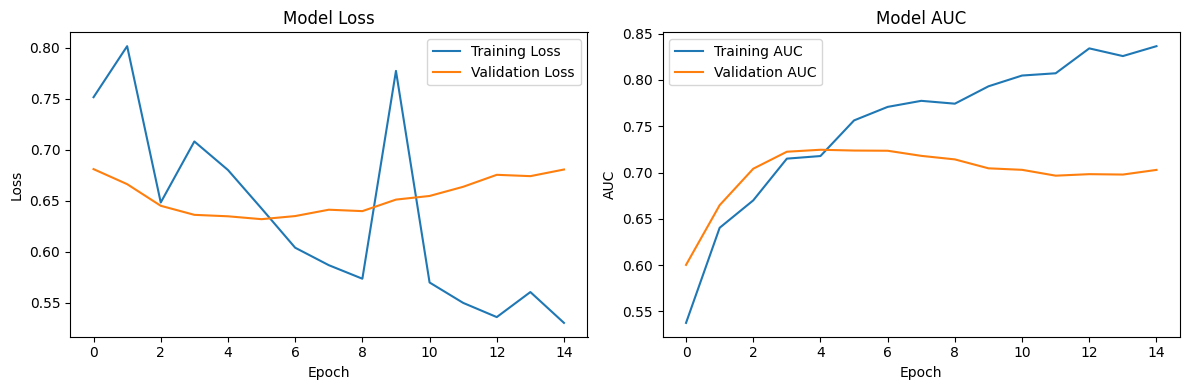

2025-01-19 17:37:29,691 - INFO - AUC, Logging: 0.737898451730419


AUC: 0.737898451730419
Loading split data for Labs, Fusion, rep 0 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - auc: 0.5241 - loss: 0.8268

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - auc: 0.5249 - loss: 0.8271 - val_auc: 0.5976 - val_loss: 0.8576
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - auc: 0.6500 - loss: 0.7445 - val_auc: 0.6733 - val_loss: 0.8489
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - auc: 0.6937 - loss: 0.6465 - val_auc: 0.6884 - val_loss: 0.7716
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - auc: 0.7027 - loss: 1.1120 - val_auc: 0.6876 - val_loss: 0.9334
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - auc: 0.7113 - loss: 0.8634 - val_auc: 0.6872 - val_loss: 0.6886
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - auc: 0.7522 - loss: 0.7182 - val_auc: 0.6876 - val_loss: 0.6284
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - auc: 0.7571 - loss: 1.3734 - val_auc: 0.6812 - val_loss: 0.7385
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - auc: 0.8106 - loss: 0.6144 - val_auc: 0.6901 - val_loss: 0.6308
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - auc: 0.7

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

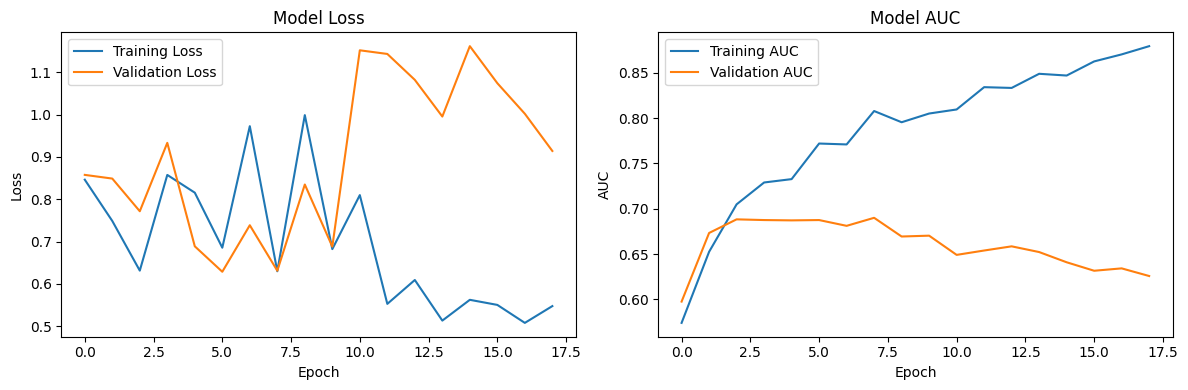

2025-01-19 17:39:31,435 - INFO - AUC, Logging: 0.7000455373406194


AUC: 0.7000455373406194
Loading split data for Labs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - auc: 0.5200 - loss: 1.3264

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.5203 - loss: 1.3225 - val_auc: 0.5814 - val_loss: 0.6929
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - auc: 0.6800 - loss: 0.9191 - val_auc: 0.6524 - val_loss: 0.6546
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - auc: 0.7078 - loss: 0.6768 - val_auc: 0.6750 - val_loss: 0.6352
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - auc: 0.7390 - loss: 0.6197 - val_auc: 0.6763 - val_loss: 0.6270
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - auc: 0.7396 - loss: 0.6325 - val_auc: 0.6829 - val_loss: 0.6183
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - auc: 0.7726 - loss: 0.5754 - val_auc: 0.6899 - val_loss: 0.6156
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - auc: 0.7874 - loss: 0.5650 - val_auc: 0.6828 - val_loss: 0.6209
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.8086 - loss: 0.5660 - val_auc: 0.6860 - val_loss: 0.6154
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - auc: 0.8134 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

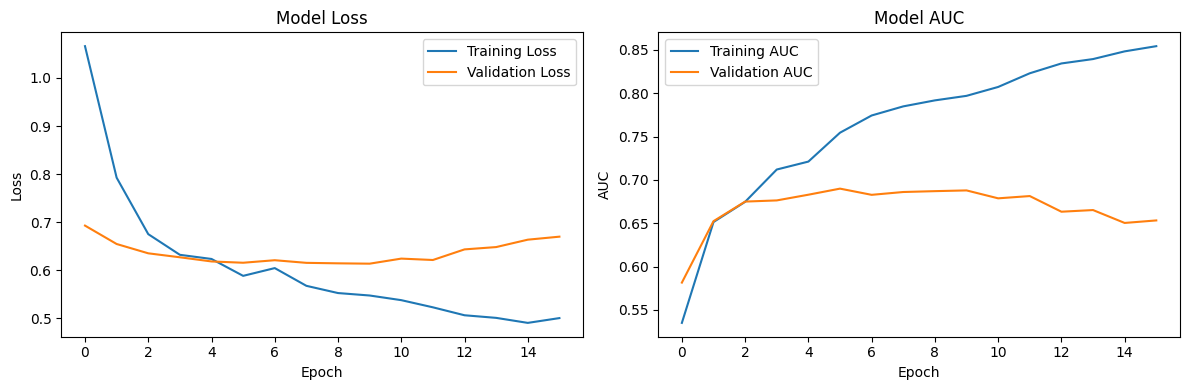

2025-01-19 17:41:11,220 - INFO - AUC, Logging: 0.7192850637522767


AUC: 0.7192850637522767
Loading split data for Labs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - auc: 0.5226 - loss: 0.7299

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - auc: 0.5227 - loss: 0.7296 - val_auc: 0.6470 - val_loss: 0.6616
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - auc: 0.6632 - loss: 0.6621 - val_auc: 0.6949 - val_loss: 0.6368
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - auc: 0.7038 - loss: 0.6353 - val_auc: 0.7209 - val_loss: 0.6155
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - auc: 0.7358 - loss: 0.6087 - val_auc: 0.7294 - val_loss: 0.6034
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - auc: 0.7657 - loss: 0.5856 - val_auc: 0.7283 - val_loss: 0.6056
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - auc: 0.7945 - loss: 0.5619 - val_auc: 0.7316 - val_loss: 0.6020
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - auc: 0.7955 - loss: 0.5475 - val_auc: 0.7377 - val_loss: 0.5952
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - auc: 0.8276 - loss: 0.5161 - val_auc: 0.7353 - val_loss: 0.5987
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - auc: 0.8

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

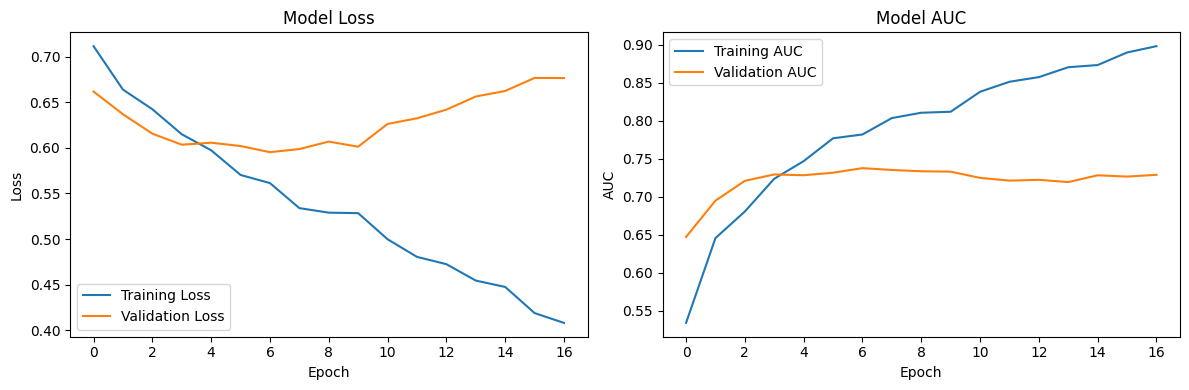

2025-01-19 17:43:08,648 - INFO - AUC, Logging: 0.6686475409836066


AUC: 0.6686475409836066
Loading split data for Labs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - auc: 0.5281 - loss: 1.3333

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - auc: 0.5282 - loss: 1.3315 - val_auc: 0.6395 - val_loss: 0.6962
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.6566 - loss: 0.8816 - val_auc: 0.6728 - val_loss: 0.8691
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - auc: 0.6617 - loss: 0.7972 - val_auc: 0.6858 - val_loss: 0.7131
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - auc: 0.7126 - loss: 0.6855 - val_auc: 0.6913 - val_loss: 0.8678
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - auc: 0.7081 - loss: 0.9388 - val_auc: 0.6922 - val_loss: 1.1736
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - auc: 0.7492 - loss: 0.8011 - val_auc: 0.7030 - val_loss: 1.0253
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.7493 - loss: 0.7411 - val_auc: 0.7043 - val_loss: 0.6678
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - auc: 0.7792 - loss: 0.9689 - val_auc: 0.6965 - val_loss: 1.0057
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - auc: 0.7722

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

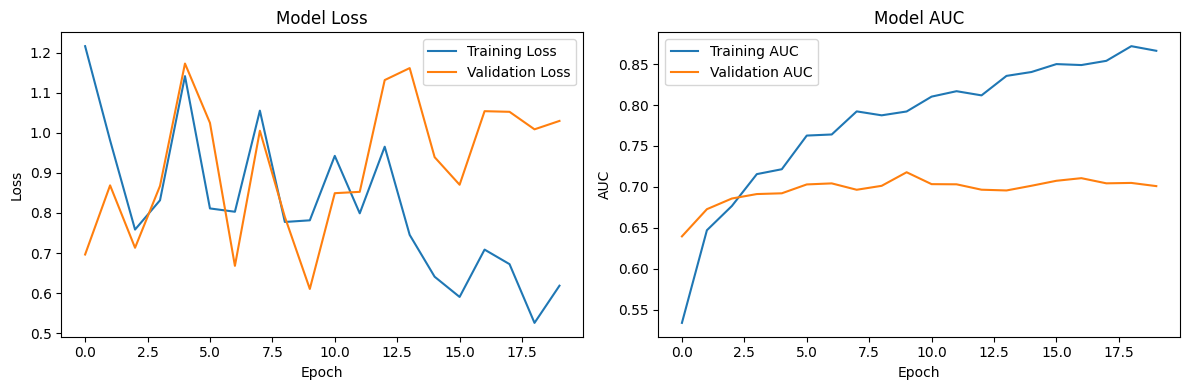

2025-01-19 17:45:05,831 - INFO - AUC, Logging: 0.6921497393776656


AUC: 0.6921497393776656
Loading split data for Labs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - auc: 0.5094 - loss: 0.8293

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - auc: 0.5100 - loss: 0.8289 - val_auc: 0.6092 - val_loss: 0.6735
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - auc: 0.5914 - loss: 0.7893 - val_auc: 0.6606 - val_loss: 0.6547
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - auc: 0.6751 - loss: 0.6648 - val_auc: 0.6784 - val_loss: 0.6423
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - auc: 0.7244 - loss: 0.6299 - val_auc: 0.6942 - val_loss: 0.6304
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - auc: 0.7547 - loss: 0.6054 - val_auc: 0.6956 - val_loss: 0.6257
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - auc: 0.7731 - loss: 0.5819 - val_auc: 0.6961 - val_loss: 0.6245
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7888 - loss: 0.5688 - val_auc: 0.7036 - val_loss: 0.6191
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7954 - loss: 0.5605 - val_auc: 0.7007 - val_loss: 0.6223
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8002 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

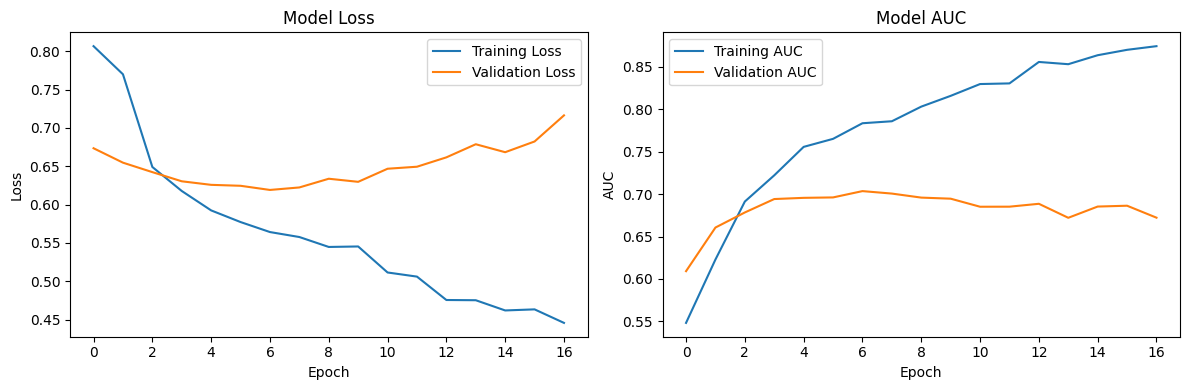

2025-01-19 17:46:39,830 - INFO - AUC, Logging: 0.7024817850637523


AUC: 0.7024817850637523
Loading split data for Labs, Fusion, rep 1 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - auc: 0.4839 - loss: 0.8486

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - auc: 0.4846 - loss: 0.8474 - val_auc: 0.6373 - val_loss: 0.6675
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.5937 - loss: 0.7198 - val_auc: 0.6765 - val_loss: 0.6515
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - auc: 0.6462 - loss: 0.6875 - val_auc: 0.6752 - val_loss: 0.6406
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - auc: 0.7244 - loss: 0.6351 - val_auc: 0.6757 - val_loss: 0.6320
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7321 - loss: 0.6153 - val_auc: 0.6715 - val_loss: 0.6303
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - auc: 0.7234 - loss: 0.6243 - val_auc: 0.6743 - val_loss: 0.6263
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - auc: 0.7512 - loss: 0.5949 - val_auc: 0.6765 - val_loss: 0.6246
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - auc: 0.7587 - loss: 0.5862 - val_auc: 0.6774 - val_loss: 0.6276
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - auc: 0.7567 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

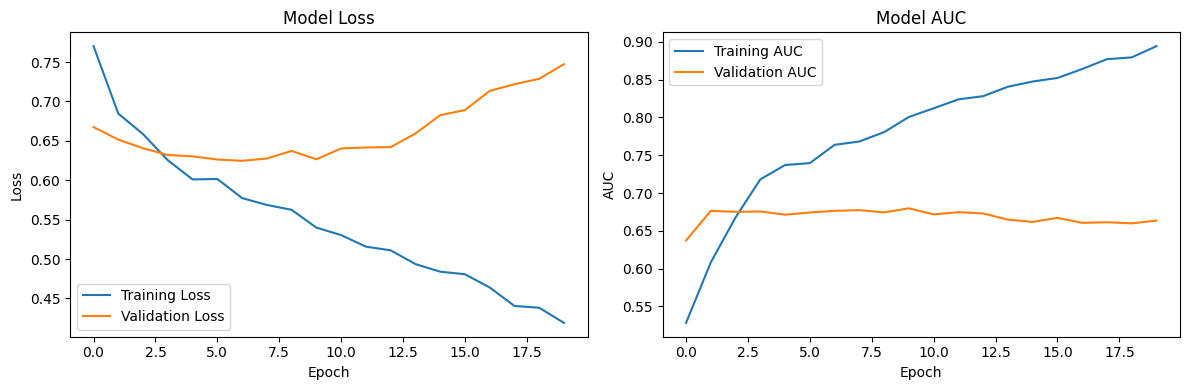

2025-01-19 17:48:33,304 - INFO - AUC, Logging: 0.7447859744990893


AUC: 0.7447859744990893
Loading split data for Labs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - auc: 0.4897 - loss: 0.7786

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - auc: 0.4903 - loss: 0.7782 - val_auc: 0.6906 - val_loss: 0.6548
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - auc: 0.6372 - loss: 0.6960 - val_auc: 0.7347 - val_loss: 0.6340
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.6717 - loss: 0.6554 - val_auc: 0.7423 - val_loss: 0.6172
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - auc: 0.7309 - loss: 0.6232 - val_auc: 0.7446 - val_loss: 0.6050
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - auc: 0.7657 - loss: 0.5870 - val_auc: 0.7439 - val_loss: 0.6023
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7615 - loss: 0.5873 - val_auc: 0.7479 - val_loss: 0.5997
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7830 - loss: 0.5704 - val_auc: 0.7490 - val_loss: 0.6030
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7997 - loss: 0.5459 - val_auc: 0.7548 - val_loss: 0.6037
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.8017 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

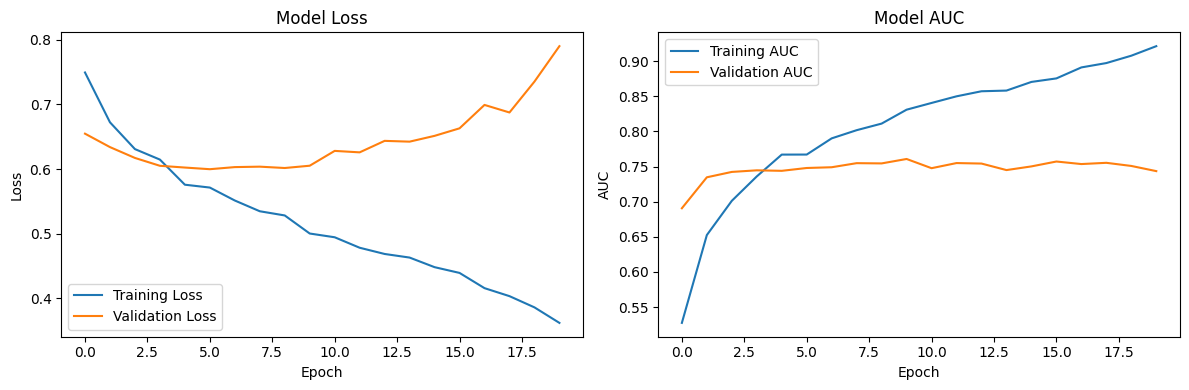

2025-01-19 17:50:08,539 - INFO - AUC, Logging: 0.6743852459016395


AUC: 0.6743852459016395
Loading split data for Labs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - auc: 0.5451 - loss: 0.8966

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - auc: 0.5455 - loss: 0.8962 - val_auc: 0.5821 - val_loss: 0.6798
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - auc: 0.6502 - loss: 0.9540 - val_auc: 0.6276 - val_loss: 0.6640
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - auc: 0.6750 - loss: 0.9039 - val_auc: 0.6648 - val_loss: 0.6493
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7262 - loss: 0.6819 - val_auc: 0.6936 - val_loss: 0.6337
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - auc: 0.7574 - loss: 0.6859 - val_auc: 0.6988 - val_loss: 0.6290
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - auc: 0.7514 - loss: 0.6620 - val_auc: 0.7156 - val_loss: 0.6185
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7866 - loss: 0.7232 - val_auc: 0.7282 - val_loss: 0.6104
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7722 - loss: 0.8171 - val_auc: 0.7220 - val_loss: 0.6161
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7809 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

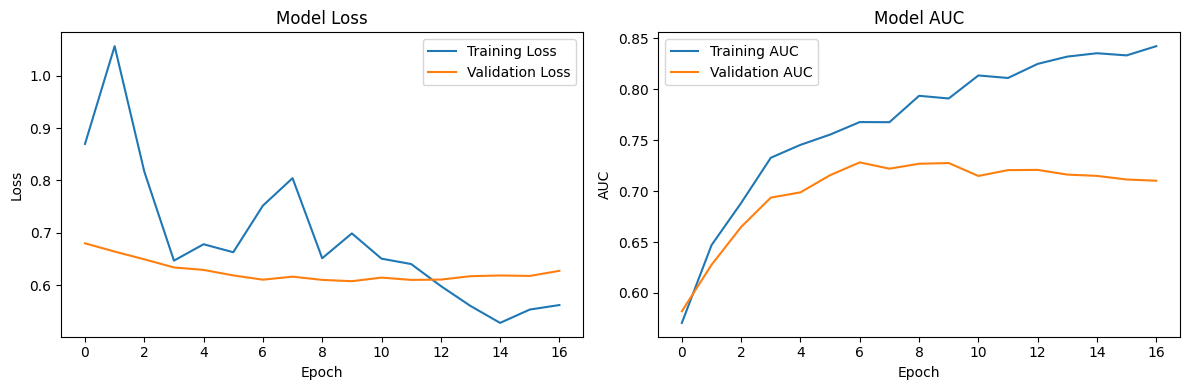

2025-01-19 17:51:37,914 - INFO - AUC, Logging: 0.6858378870673953


AUC: 0.6858378870673953
Loading split data for Labs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - auc: 0.5429 - loss: 0.7461

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - auc: 0.5432 - loss: 0.7462 - val_auc: 0.5802 - val_loss: 0.6767
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.6458 - loss: 0.6735 - val_auc: 0.6536 - val_loss: 0.6530
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.6859 - loss: 0.6589 - val_auc: 0.6855 - val_loss: 0.6349
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7298 - loss: 0.6231 - val_auc: 0.6949 - val_loss: 0.6189
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7600 - loss: 0.5985 - val_auc: 0.7097 - val_loss: 0.6074
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7659 - loss: 0.5934 - val_auc: 0.7144 - val_loss: 0.5994
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.8002 - loss: 0.5636 - val_auc: 0.7148 - val_loss: 0.5994
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7953 - loss: 0.5610 - val_auc: 0.7098 - val_loss: 0.6061
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7938 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

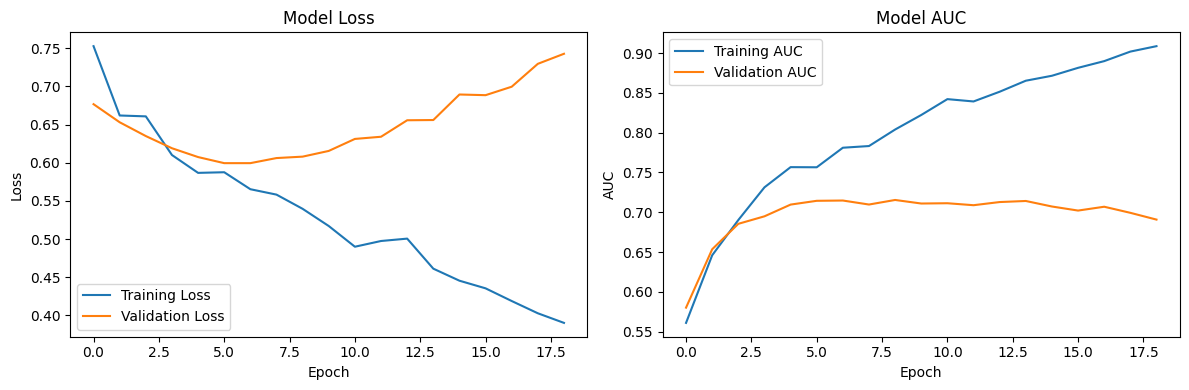

2025-01-19 17:53:08,855 - INFO - AUC, Logging: 0.7153688200916127


AUC: 0.7153688200916127
Loading split data for Labs, Fusion, rep 2 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.5251 - loss: 0.7480

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.5255 - loss: 0.7565 - val_auc: 0.6200 - val_loss: 0.6693
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.6667 - loss: 0.6676 - val_auc: 0.6884 - val_loss: 0.6483
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - auc: 0.7026 - loss: 0.6439 - val_auc: 0.7027 - val_loss: 0.6359
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.7113 - loss: 0.6287 - val_auc: 0.6937 - val_loss: 0.6318
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - auc: 0.7152 - loss: 0.6195 - val_auc: 0.7134 - val_loss: 0.6181
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7561 - loss: 0.5934 - val_auc: 0.7097 - val_loss: 0.6179
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.7585 - loss: 0.5856 - val_auc: 0.7040 - val_loss: 0.6195
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7924 - loss: 0.5632 - val_auc: 0.7062 - val_loss: 0.6191
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - auc: 0.7989 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

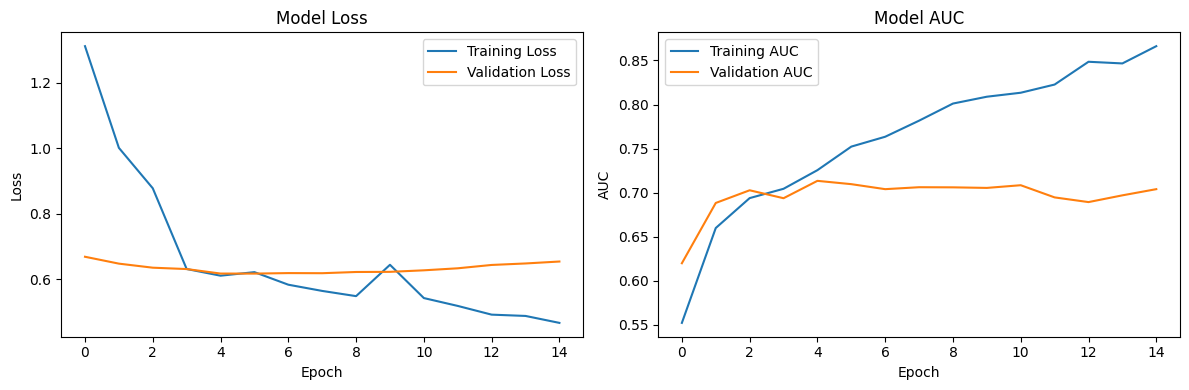

2025-01-19 17:54:23,676 - INFO - AUC, Logging: 0.7087204007285974


AUC: 0.7087204007285974
Loading split data for Labs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.5212 - loss: 1.5012

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - auc: 0.5215 - loss: 1.4949 - val_auc: 0.6437 - val_loss: 0.6649
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6445 - loss: 1.0343 - val_auc: 0.6649 - val_loss: 0.6503
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7203 - loss: 0.8640 - val_auc: 0.6952 - val_loss: 0.6292
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7113 - loss: 0.7150 - val_auc: 0.7033 - val_loss: 0.6255
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7281 - loss: 0.8420 - val_auc: 0.7241 - val_loss: 0.6135
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - auc: 0.7528 - loss: 0.6979 - val_auc: 0.7360 - val_loss: 0.6059
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7696 - loss: 0.5914 - val_auc: 0.7418 - val_loss: 0.6015
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - auc: 0.7881 - loss: 0.6301 - val_auc: 0.7501 - val_loss: 0.5998
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - auc: 0.7903 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

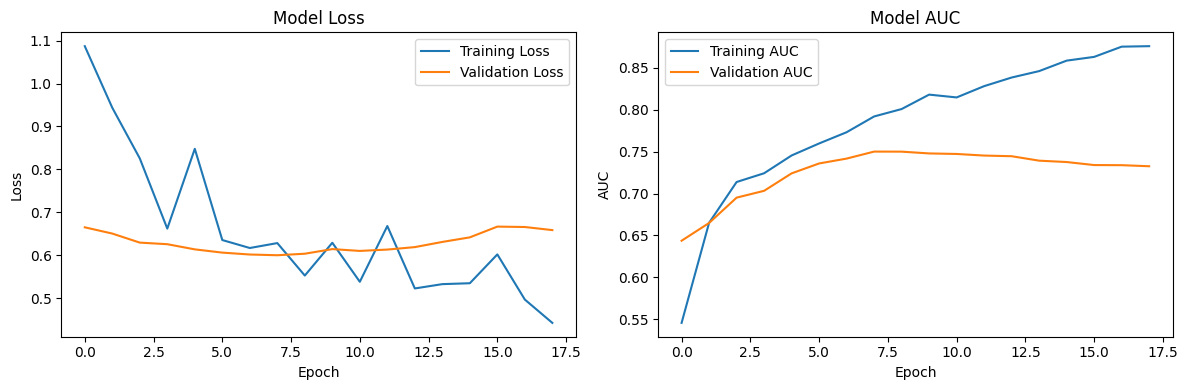

2025-01-19 17:56:02,350 - INFO - AUC, Logging: 0.6380692167577414


AUC: 0.6380692167577414
Loading split data for Labs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.5266 - loss: 0.8537

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.5274 - loss: 0.8525 - val_auc: 0.5534 - val_loss: 0.6918
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.6097 - loss: 0.6778 - val_auc: 0.5852 - val_loss: 0.6831
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7005 - loss: 0.6318 - val_auc: 0.6107 - val_loss: 0.6747
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - auc: 0.6899 - loss: 0.7182 - val_auc: 0.6226 - val_loss: 0.6656
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7227 - loss: 0.6164 - val_auc: 0.6142 - val_loss: 0.6797
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.7441 - loss: 0.5902 - val_auc: 0.6104 - val_loss: 0.6754
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.7537 - loss: 0.5832 - val_auc: 0.6173 - val_loss: 0.6739
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - auc: 0.7700 - loss: 0.5699 - val_auc: 0.6182 - val_loss: 0.6783
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7680 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

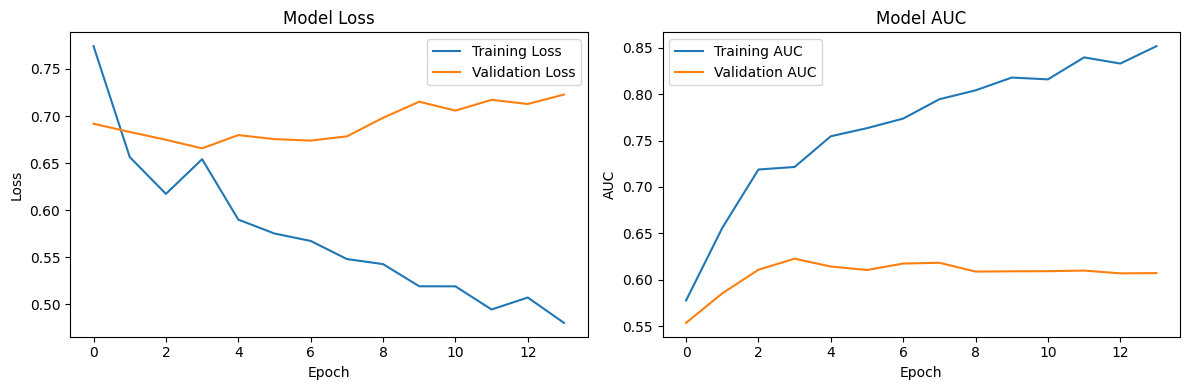

2025-01-19 17:57:10,580 - INFO - AUC, Logging: 0.6754212204007285


AUC: 0.6754212204007285
Loading split data for Labs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.4887 - loss: 1.8183

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.4896 - loss: 1.8087 - val_auc: 0.6796 - val_loss: 0.6598
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.6258 - loss: 0.7155 - val_auc: 0.7089 - val_loss: 0.6417
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.6761 - loss: 0.6635 - val_auc: 0.7156 - val_loss: 0.6318
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.6735 - loss: 0.8232 - val_auc: 0.7034 - val_loss: 0.6316
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.6859 - loss: 0.6467 - val_auc: 0.7034 - val_loss: 0.6433
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7117 - loss: 0.6386 - val_auc: 0.7016 - val_loss: 0.6658
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7179 - loss: 0.6337 - val_auc: 0.7008 - val_loss: 0.6453
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7593 - loss: 0.5906 - val_auc: 0.7059 - val_loss: 0.6212
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.7695 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

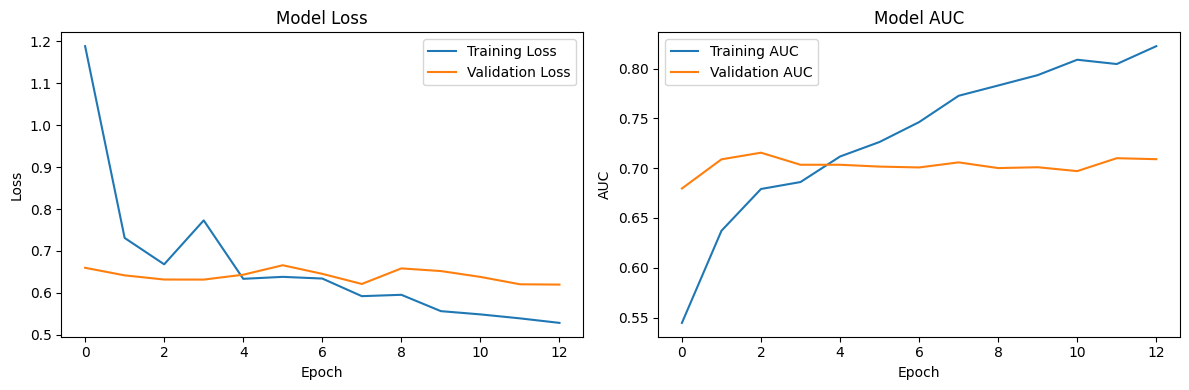

2025-01-19 17:58:09,760 - INFO - AUC, Logging: 0.7138661202185792


AUC: 0.7138661202185792
Loading split data for Labs, Fusion, rep 2 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.5471 - loss: 1.0408

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.5474 - loss: 1.0430 - val_auc: 0.5144 - val_loss: 0.6944
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.6566 - loss: 0.8114 - val_auc: 0.5631 - val_loss: 0.6834
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.6989 - loss: 0.7808 - val_auc: 0.5682 - val_loss: 0.6861
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7081 - loss: 0.6786 - val_auc: 0.5853 - val_loss: 0.6876
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7308 - loss: 0.7378 - val_auc: 0.6040 - val_loss: 0.6821
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7522 - loss: 0.7198 - val_auc: 0.6080 - val_loss: 0.6888
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7912 - loss: 0.5867 - val_auc: 0.6159 - val_loss: 0.6893
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7881 - loss: 0.7235 - val_auc: 0.6002 - val_loss: 0.7053
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7879 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

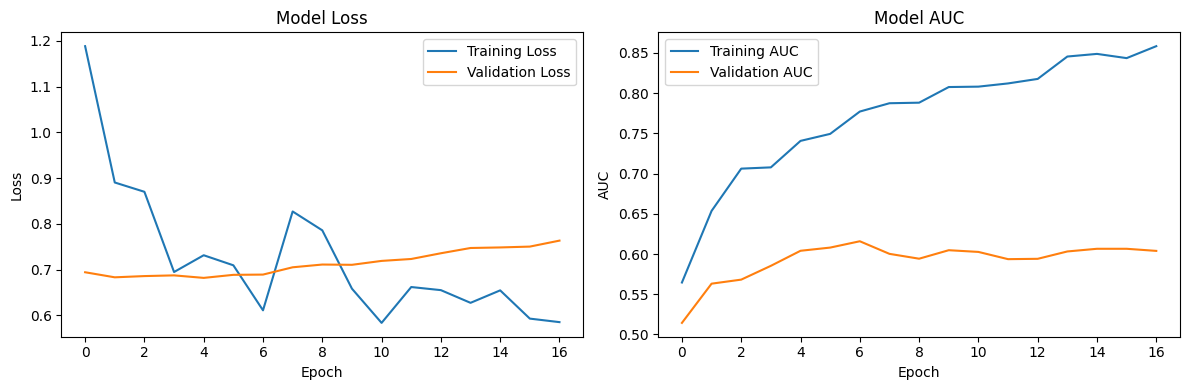

2025-01-19 17:59:26,613 - INFO - AUC, Logging: 0.7207843491211048


AUC: 0.7207843491211048
Loading split data for Labs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - auc: 0.5063 - loss: 0.8700

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.5065 - loss: 0.8695 - val_auc: 0.4868 - val_loss: 0.7143
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6425 - loss: 0.7773 - val_auc: 0.5728 - val_loss: 0.6894
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7092 - loss: 0.6754 - val_auc: 0.6119 - val_loss: 0.6807
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7401 - loss: 0.6125 - val_auc: 0.6417 - val_loss: 0.6820
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.7608 - loss: 0.5939 - val_auc: 0.6539 - val_loss: 0.6845
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7655 - loss: 0.6612 - val_auc: 0.6622 - val_loss: 0.6947
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.8027 - loss: 0.5569 - val_auc: 0.6519 - val_loss: 0.7191
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.8035 - loss: 0.5893 - val_auc: 0.6508 - val_loss: 0.7517
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.8084 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

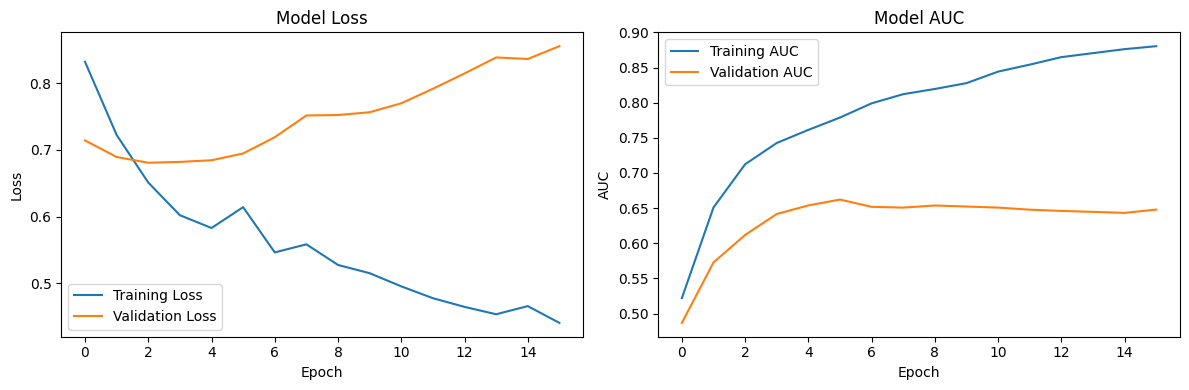

2025-01-19 18:00:40,224 - INFO - AUC, Logging: 0.6530737704918034


AUC: 0.6530737704918034
Loading split data for Labs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.4993 - loss: 0.7666

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - auc: 0.4999 - loss: 0.7662 - val_auc: 0.6076 - val_loss: 0.6724
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.6507 - loss: 0.6640 - val_auc: 0.6566 - val_loss: 0.6775
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - auc: 0.7064 - loss: 0.6396 - val_auc: 0.6694 - val_loss: 0.6985
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - auc: 0.7233 - loss: 0.6249 - val_auc: 0.6779 - val_loss: 0.7220
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.7548 - loss: 0.6018 - val_auc: 0.6801 - val_loss: 0.7375
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7598 - loss: 0.5950 - val_auc: 0.6850 - val_loss: 0.7578
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7997 - loss: 0.5615 - val_auc: 0.6810 - val_loss: 0.7866
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.8101 - loss: 0.5500 - val_auc: 0.6852 - val_loss: 0.8070
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.8112 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

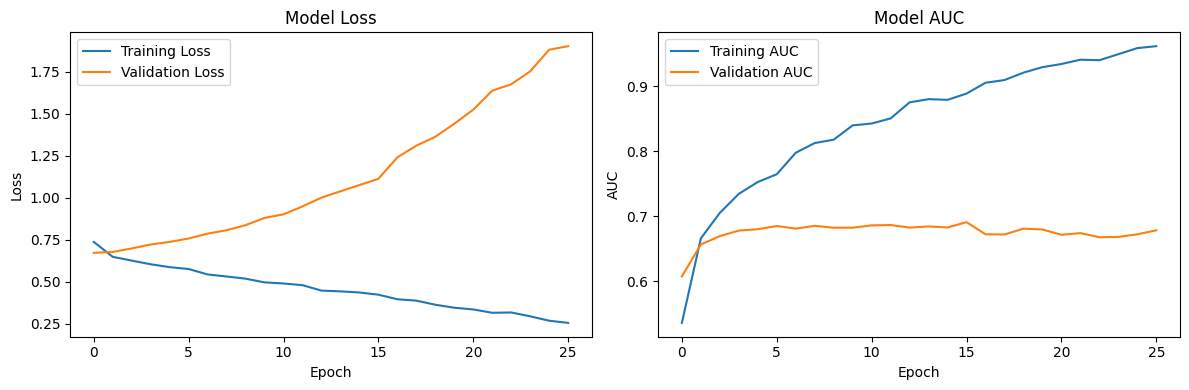

2025-01-19 18:02:45,824 - INFO - AUC, Logging: 0.7097449908925318


AUC: 0.7097449908925318
Loading split data for Labs, Fusion, rep 3 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.4948 - loss: 0.8404

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.4954 - loss: 0.8411 - val_auc: 0.5406 - val_loss: 0.6991
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6514 - loss: 1.0547 - val_auc: 0.5508 - val_loss: 0.6978
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.7122 - loss: 0.6453 - val_auc: 0.5717 - val_loss: 0.7022
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7351 - loss: 0.6722 - val_auc: 0.5826 - val_loss: 0.7000
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7186 - loss: 0.9916 - val_auc: 0.6025 - val_loss: 0.6953
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7436 - loss: 1.5401 - val_auc: 0.6073 - val_loss: 0.6934
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7690 - loss: 0.8999 - val_auc: 0.6138 - val_loss: 0.7287
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7916 - loss: 0.6564 - val_auc: 0.6228 - val_loss: 0.6919
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7693 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

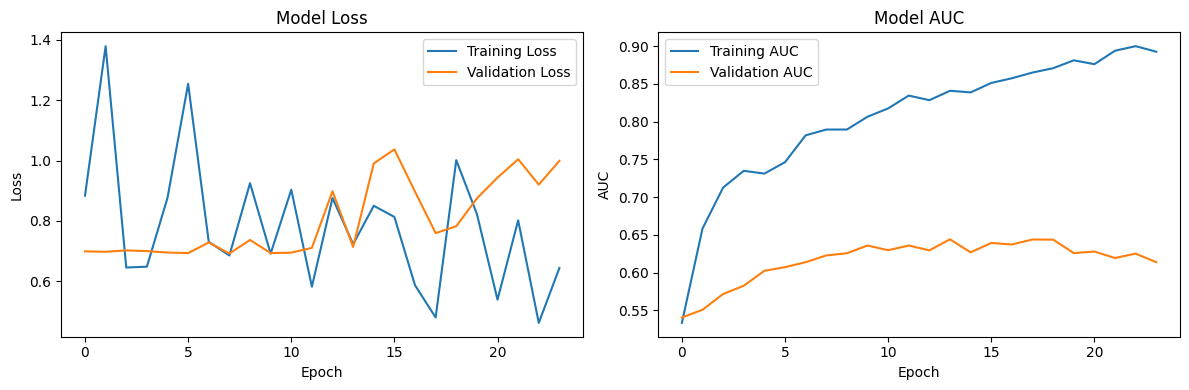

2025-01-19 18:04:31,435 - INFO - AUC, Logging: 0.7164617486338798


AUC: 0.7164617486338798
Loading split data for Labs, Fusion, rep 3 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.5136 - loss: 0.7575

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.5138 - loss: 0.7579 - val_auc: 0.5883 - val_loss: 0.6866
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.6213 - loss: 0.7032 - val_auc: 0.6356 - val_loss: 0.6628
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - auc: 0.6689 - loss: 0.6575 - val_auc: 0.6558 - val_loss: 0.6512
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7061 - loss: 0.7349 - val_auc: 0.6694 - val_loss: 0.6452
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7207 - loss: 0.8306 - val_auc: 0.6736 - val_loss: 0.6438
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.7285 - loss: 1.0058 - val_auc: 0.6762 - val_loss: 0.6473
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - auc: 0.7669 - loss: 1.2376 - val_auc: 0.6777 - val_loss: 0.6517
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7886 - loss: 0.5726 - val_auc: 0.6779 - val_loss: 0.6581
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7807 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

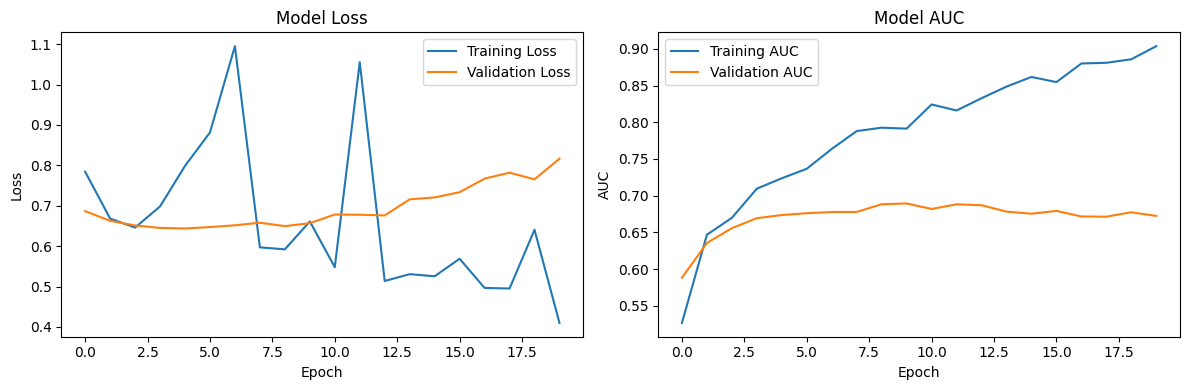

2025-01-19 18:06:03,785 - INFO - AUC, Logging: 0.7141393442622951


AUC: 0.7141393442622951
Loading split data for Labs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.5283 - loss: 0.7864

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.5286 - loss: 0.7861 - val_auc: 0.6215 - val_loss: 0.6732
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.6693 - loss: 0.6628 - val_auc: 0.6409 - val_loss: 0.6637
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7062 - loss: 0.7065 - val_auc: 0.6649 - val_loss: 0.6501
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7169 - loss: 0.6984 - val_auc: 0.6768 - val_loss: 0.6462
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7461 - loss: 0.6091 - val_auc: 0.6800 - val_loss: 0.6451
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7682 - loss: 0.5925 - val_auc: 0.6834 - val_loss: 0.6463
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7897 - loss: 0.5717 - val_auc: 0.6845 - val_loss: 0.6527
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.8239 - loss: 0.5455 - val_auc: 0.6833 - val_loss: 0.6654
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.8036 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

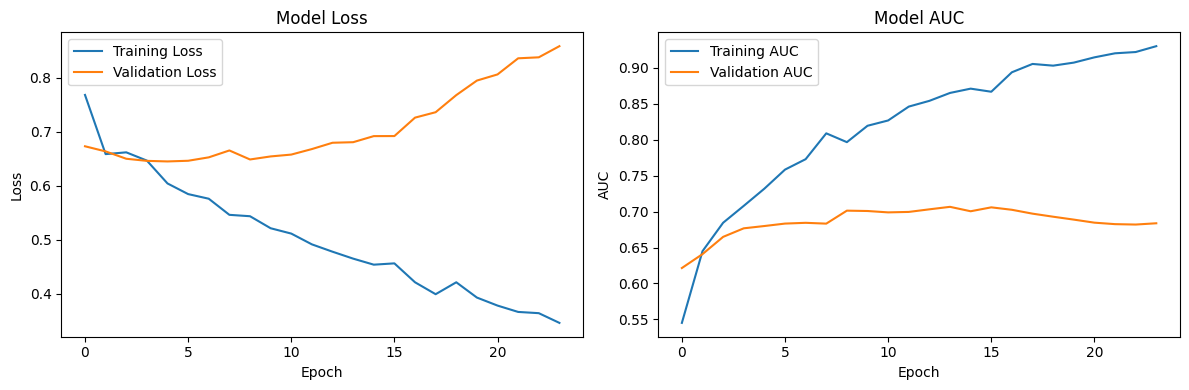

2025-01-19 18:07:56,328 - INFO - AUC, Logging: 0.6560687772186745


AUC: 0.6560687772186745
Loading split data for Labs, Fusion, rep 4 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.4515 - loss: 0.8428

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.4523 - loss: 0.8451 - val_auc: 0.6048 - val_loss: 0.6710
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6315 - loss: 0.7398 - val_auc: 0.6555 - val_loss: 0.6575
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7081 - loss: 0.6632 - val_auc: 0.6387 - val_loss: 0.6890
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7409 - loss: 0.6485 - val_auc: 0.6548 - val_loss: 0.8332
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7388 - loss: 0.6679 - val_auc: 0.6828 - val_loss: 0.6350
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7862 - loss: 0.6254 - val_auc: 0.6880 - val_loss: 0.6346
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7826 - loss: 0.5747 - val_auc: 0.6699 - val_loss: 0.7557
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.7905 - loss: 0.6078 - val_auc: 0.6882 - val_loss: 0.6339
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7937 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

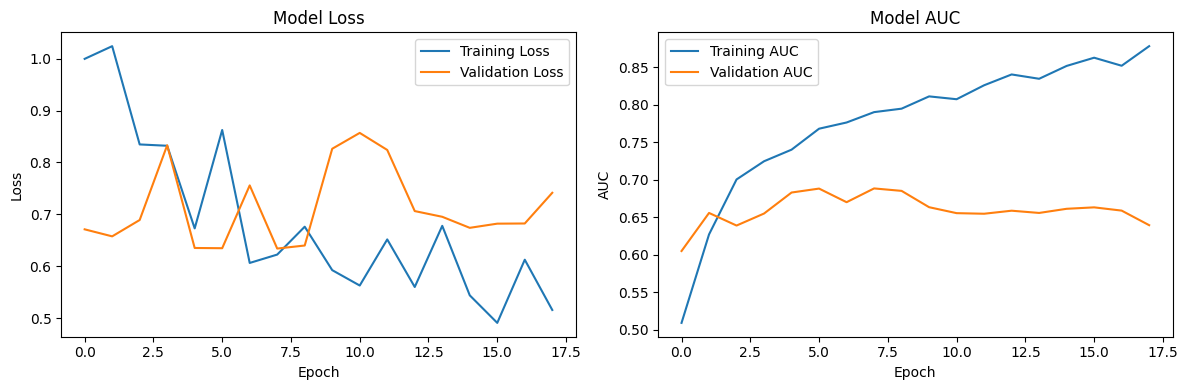

2025-01-19 18:09:15,831 - INFO - AUC, Logging: 0.6817850637522768


AUC: 0.6817850637522768
Loading split data for Labs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.4765 - loss: 0.9247

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - auc: 0.4773 - loss: 0.9242 - val_auc: 0.6146 - val_loss: 0.6748
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.6389 - loss: 0.8528 - val_auc: 0.6241 - val_loss: 0.6680
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.6679 - loss: 0.8124 - val_auc: 0.6280 - val_loss: 0.6915
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7383 - loss: 0.6890 - val_auc: 0.6312 - val_loss: 0.7893
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7180 - loss: 0.6171 - val_auc: 0.6373 - val_loss: 0.7506
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7910 - loss: 0.5837 - val_auc: 0.6473 - val_loss: 0.6687
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.7827 - loss: 0.7243 - val_auc: 0.6370 - val_loss: 0.8387
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7965 - loss: 0.7062 - val_auc: 0.6425 - val_loss: 0.7678
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.7925 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

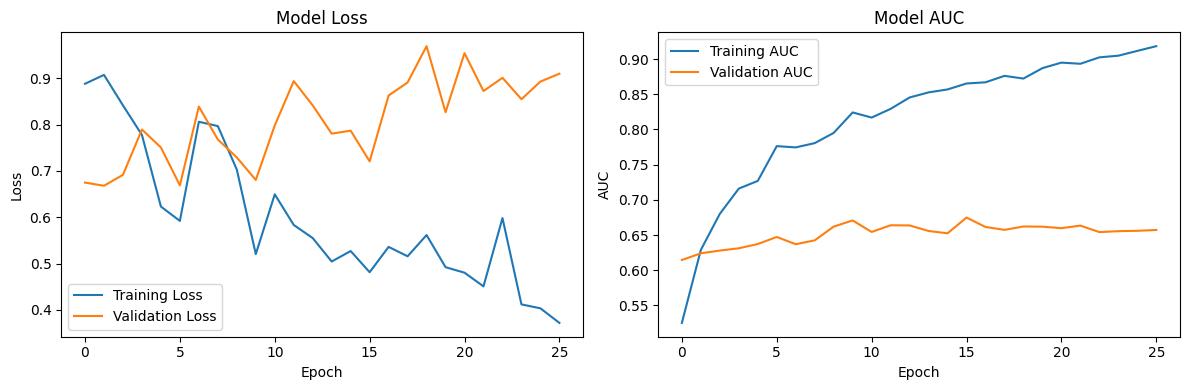

2025-01-19 18:11:19,568 - INFO - AUC, Logging: 0.7333788706739527


AUC: 0.7333788706739527
Loading split data for Labs, Fusion, rep 4 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.4489 - loss: 0.8409

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.4500 - loss: 0.8395 - val_auc: 0.6609 - val_loss: 0.6616
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - auc: 0.6135 - loss: 0.6903 - val_auc: 0.7338 - val_loss: 0.6340
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.6918 - loss: 0.6414 - val_auc: 0.7589 - val_loss: 0.6055
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7381 - loss: 0.6072 - val_auc: 0.7756 - val_loss: 0.5839
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - auc: 0.7335 - loss: 0.6064 - val_auc: 0.7882 - val_loss: 0.5649
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.7822 - loss: 0.5679 - val_auc: 0.7954 - val_loss: 0.5601
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7919 - loss: 0.5638 - val_auc: 0.8034 - val_loss: 0.5467
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - auc: 0.8019 - loss: 0.5483 - val_auc: 0.8007 - val_loss: 0.5459
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.7868 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

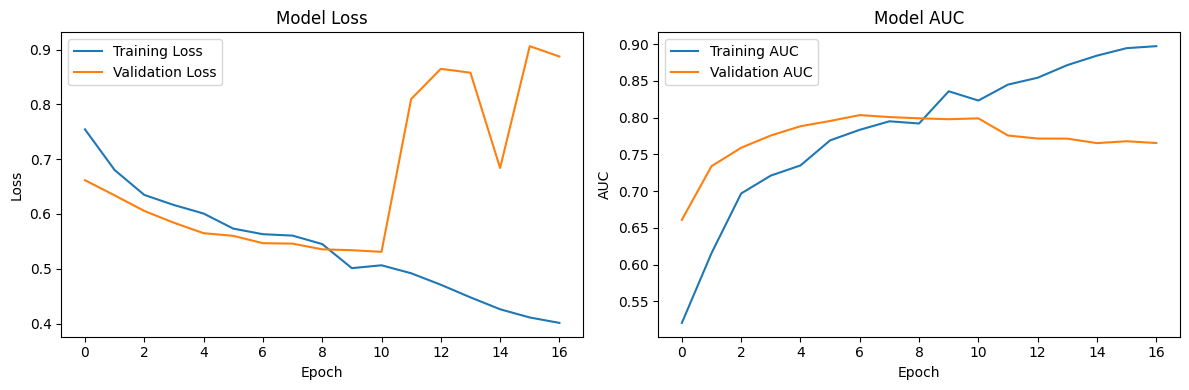

2025-01-19 18:12:48,481 - INFO - AUC, Logging: 0.6895491803278688


AUC: 0.6895491803278688
Loading split data for Labs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.4644 - loss: 1.1000

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.4653 - loss: 1.0968 - val_auc: 0.6260 - val_loss: 0.6804
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6590 - loss: 1.2478 - val_auc: 0.6783 - val_loss: 0.6529
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7027 - loss: 1.0588 - val_auc: 0.6832 - val_loss: 0.6621
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7186 - loss: 0.6731 - val_auc: 0.6818 - val_loss: 0.7036
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7440 - loss: 0.7333 - val_auc: 0.6798 - val_loss: 0.7703
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7795 - loss: 0.5710 - val_auc: 0.6913 - val_loss: 0.7138
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7812 - loss: 0.8772 - val_auc: 0.6938 - val_loss: 0.7337
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.8062 - loss: 0.5379 - val_auc: 0.6835 - val_loss: 0.6664
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - auc: 0.7947 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

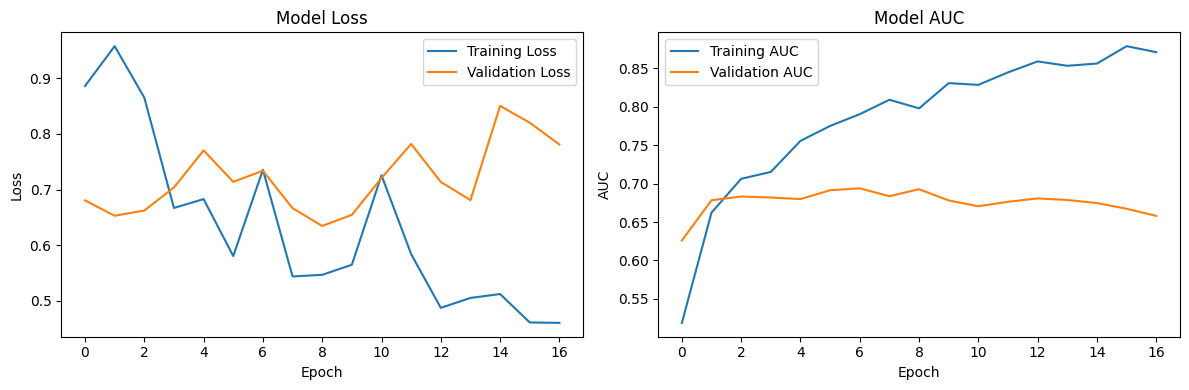

2025-01-19 18:14:12,714 - INFO - AUC, Logging: 0.6828096539162112


AUC: 0.6828096539162112
Loading split data for Labs, Fusion, rep 4 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - auc: 0.4726 - loss: 0.8081

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.4737 - loss: 0.8069 - val_auc: 0.6279 - val_loss: 0.6682
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.6475 - loss: 0.7070 - val_auc: 0.6657 - val_loss: 0.6510
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.7122 - loss: 0.6179 - val_auc: 0.6854 - val_loss: 0.6362
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.7286 - loss: 0.6076 - val_auc: 0.6910 - val_loss: 0.6297
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - auc: 0.7864 - loss: 0.5649 - val_auc: 0.6903 - val_loss: 0.6295
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7935 - loss: 0.5479 - val_auc: 0.6892 - val_loss: 0.6334
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7973 - loss: 0.5442 - val_auc: 0.6812 - val_loss: 0.6402
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.8135 - loss: 0.5250 - val_auc: 0.6881 - val_loss: 0.6445
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.8231 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

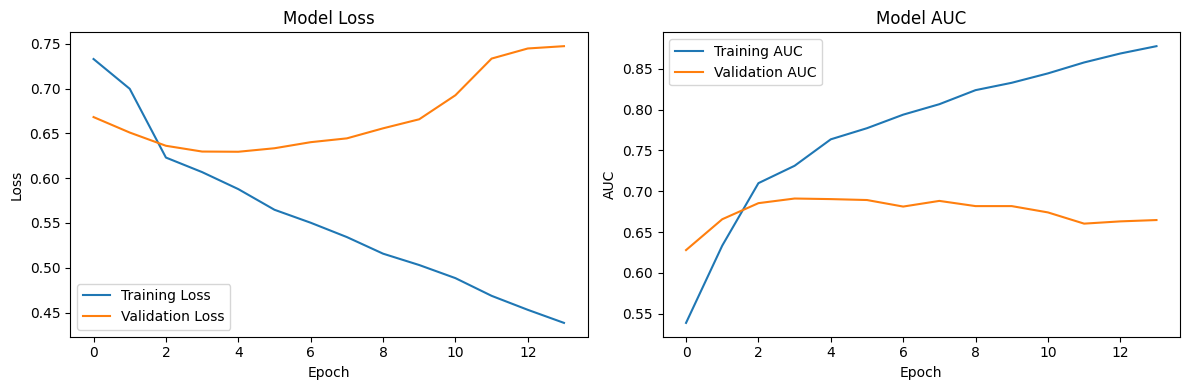

2025-01-19 18:15:16,781 - INFO - AUC, Logging: 0.6973170566599725


AUC: 0.6973170566599725
Loading split data for Labs, Fusion, rep 5 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
 1/65 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - auc: 0.5491 - loss: 0.6544

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.5043 - loss: 0.9583

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.5047 - loss: 0.9562 - val_auc: 0.6838 - val_loss: 0.6552
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6129 - loss: 0.9177 - val_auc: 0.7168 - val_loss: 0.6397
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.6844 - loss: 0.8794 - val_auc: 0.7363 - val_loss: 0.6209
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6950 - loss: 0.7227 - val_auc: 0.7376 - val_loss: 0.6094
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7399 - loss: 0.7883 - val_auc: 0.7369 - val_loss: 0.6028
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7433 - loss: 0.7430 - val_auc: 0.7346 - val_loss: 0.6045
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7586 - loss: 0.6357 - val_auc: 0.7365 - val_loss: 0.6000
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7998 - loss: 0.7709 - val_auc: 0.7411 - val_loss: 0.5951
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.8028 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

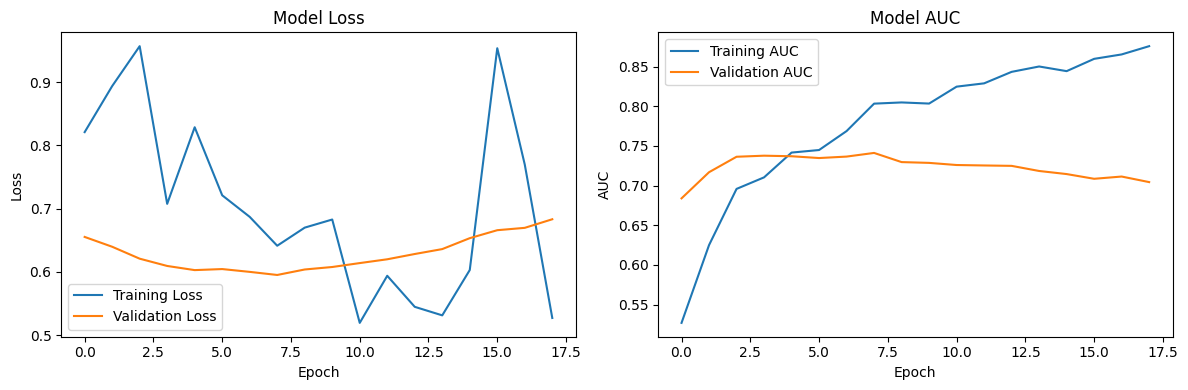

2025-01-19 18:16:33,407 - INFO - AUC, Logging: 0.7032103825136611


AUC: 0.7032103825136611
Loading split data for Labs, Fusion, rep 5 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.5525 - loss: 1.1469

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - auc: 0.5523 - loss: 1.1419 - val_auc: 0.6568 - val_loss: 0.6664
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.6239 - loss: 1.1058 - val_auc: 0.6611 - val_loss: 0.6594
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.6708 - loss: 0.7933 - val_auc: 0.6780 - val_loss: 0.6494
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.6905 - loss: 0.6611 - val_auc: 0.6856 - val_loss: 0.6412
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.7179 - loss: 0.8893 - val_auc: 0.6887 - val_loss: 0.6333
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - auc: 0.7344 - loss: 0.8597 - val_auc: 0.6868 - val_loss: 0.6312
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7504 - loss: 0.7198 - val_auc: 0.6963 - val_loss: 0.6258
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7673 - loss: 1.1630 - val_auc: 0.6881 - val_loss: 0.6296
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7759 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

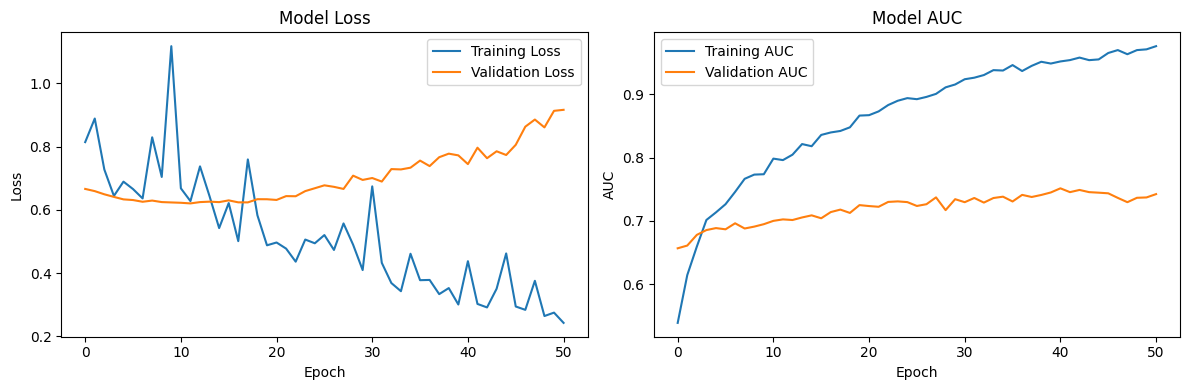

2025-01-19 18:20:26,212 - INFO - AUC, Logging: 0.6671675774134791


AUC: 0.6671675774134791
Loading split data for Labs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.4969 - loss: 1.0904 - val_auc: 0.6869 - val_loss: 1.0931


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.5730 - loss: 0.7024 - val_auc: 0.6980 - val_loss: 1.1842
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - auc: 0.6650 - loss: 0.6709 - val_auc: 0.7067 - val_loss: 0.9758
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6638 - loss: 0.6584 - val_auc: 0.7197 - val_loss: 0.8713
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7181 - loss: 0.6243 - val_auc: 0.7311 - val_loss: 0.7808
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7362 - loss: 0.6130 - val_auc: 0.7328 - val_loss: 0.7175
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7438 - loss: 0.6010 - val_auc: 0.7306 - val_loss: 1.2254
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.7738 - loss: 0.5774 - val_auc: 0.7263 - val_loss: 1.2159
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7788 - loss: 0.5726 - val_auc: 0.7270 - val_loss: 1.2021
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - a

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

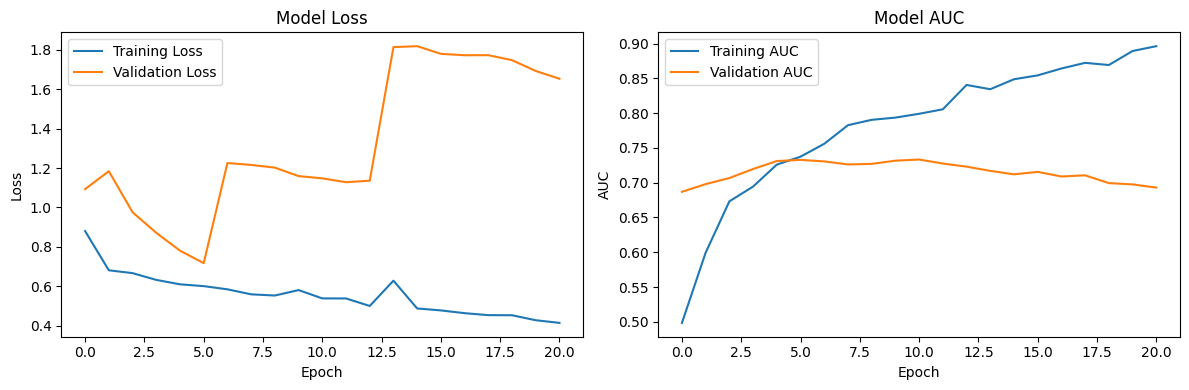

2025-01-19 18:21:53,558 - INFO - AUC, Logging: 0.6933970856102003


AUC: 0.6933970856102003
Loading split data for Labs, Fusion, rep 5 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.4823 - loss: 0.8365 - val_auc: 0.6149 - val_loss: 0.6712


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6225 - loss: 0.7675 - val_auc: 0.6555 - val_loss: 0.6522
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6523 - loss: 0.8455 - val_auc: 0.6969 - val_loss: 0.6346
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6932 - loss: 1.2207 - val_auc: 0.7054 - val_loss: 0.6268
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7284 - loss: 0.7656 - val_auc: 0.6986 - val_loss: 0.6444
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7369 - loss: 0.9188 - val_auc: 0.7093 - val_loss: 0.7646
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7429 - loss: 0.6535 - val_auc: 0.7173 - val_loss: 0.8434
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7506 - loss: 0.7112 - val_auc: 0.7164 - val_loss: 0.6421
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7919 - loss: 0.6364 - val_auc: 0.7203 - val_loss: 0.6065
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - a

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

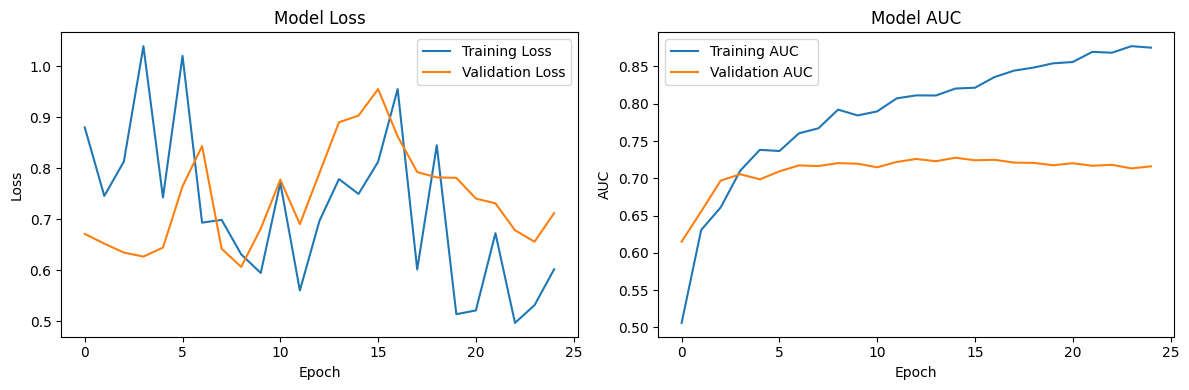

2025-01-19 18:23:42,643 - INFO - AUC, Logging: 0.6892531876138434


AUC: 0.6892531876138434
Loading split data for Labs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - auc: 0.5194 - loss: 0.7847

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - auc: 0.5193 - loss: 0.7850 - val_auc: 0.6414 - val_loss: 0.6656
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - auc: 0.6251 - loss: 0.9706 - val_auc: 0.6959 - val_loss: 0.6492
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.6673 - loss: 1.6628 - val_auc: 0.7281 - val_loss: 0.6333
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.6998 - loss: 0.7610 - val_auc: 0.7438 - val_loss: 0.6192
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7304 - loss: 0.8207 - val_auc: 0.7436 - val_loss: 0.6131
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7345 - loss: 0.6206 - val_auc: 0.7535 - val_loss: 0.6041
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7364 - loss: 0.7803 - val_auc: 0.7528 - val_loss: 0.6028
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7680 - loss: 1.0456 - val_auc: 0.7501 - val_loss: 0.6082
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7721 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

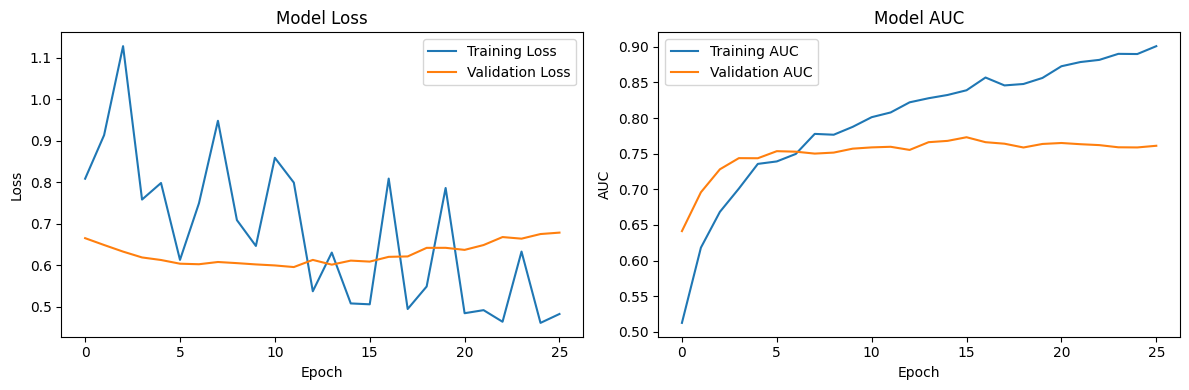

2025-01-19 18:25:20,179 - INFO - AUC, Logging: 0.6876819279283345


AUC: 0.6876819279283345
Loading split data for Labs, Fusion, rep 6 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.5160 - loss: 1.0161 - val_auc: 0.6973 - val_loss: 0.8648
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.6411 - loss: 0.7295 - val_auc: 0.7495 - val_loss: 0.6300
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.6990 - loss: 0.6477 - val_auc: 0.7667 - val_loss: 0.6124
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7271 - loss: 0.6057 - val_auc: 0.7697 - val_loss: 0.6030
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7371 - loss: 0.5977 - val_auc: 0.7709 - val_loss: 0.5856
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.7786 - loss: 0.5611 - val_auc: 0.7703 - val_loss: 0.5819
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7705 - loss: 0.5602 - val_auc: 0.7759 - val_loss: 0.5745
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7909 - loss: 0.5558 - val_auc: 0.7759 - val_loss: 0.5719
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8110 - loss: 0.5246 - val_auc: 0.7771 - val_loss: 0.5709
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8026 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

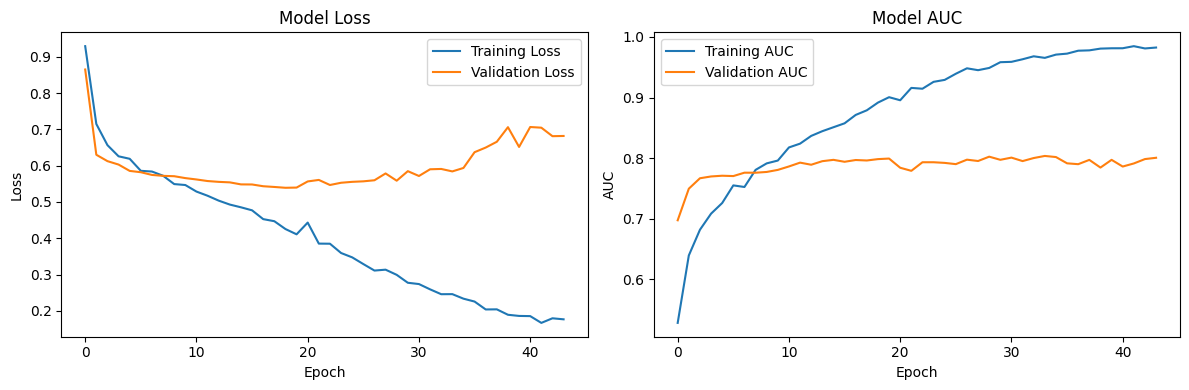

2025-01-19 18:28:39,472 - INFO - AUC, Logging: 0.6505692167577413


AUC: 0.6505692167577413
Loading split data for Labs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.5345 - loss: 1.0329

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.5344 - loss: 1.0315 - val_auc: 0.6552 - val_loss: 0.6635
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.6576 - loss: 0.6736 - val_auc: 0.6902 - val_loss: 0.6383
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7214 - loss: 0.6105 - val_auc: 0.6964 - val_loss: 0.6305
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7382 - loss: 0.5913 - val_auc: 0.6922 - val_loss: 0.6283
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7594 - loss: 0.5747 - val_auc: 0.6874 - val_loss: 0.6290
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7711 - loss: 0.5603 - val_auc: 0.6881 - val_loss: 0.6328
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7833 - loss: 0.5467 - val_auc: 0.6908 - val_loss: 0.6332
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7849 - loss: 0.5496 - val_auc: 0.6901 - val_loss: 0.6414
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.8006 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

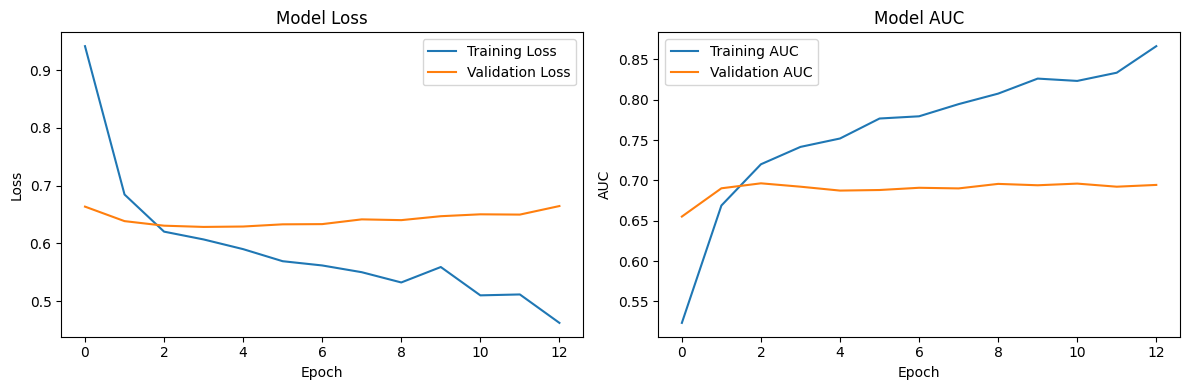

2025-01-19 18:29:42,435 - INFO - AUC, Logging: 0.6651411657559199


AUC: 0.6651411657559199
Loading split data for Labs, Fusion, rep 6 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.4674 - loss: 0.9341

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.4679 - loss: 0.9341 - val_auc: 0.4919 - val_loss: 0.8430
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.6163 - loss: 0.6877 - val_auc: 0.5344 - val_loss: 0.7163
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - auc: 0.6845 - loss: 0.6520 - val_auc: 0.5953 - val_loss: 0.6886
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.7141 - loss: 0.6187 - val_auc: 0.6030 - val_loss: 0.7212
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - auc: 0.7342 - loss: 0.5997 - val_auc: 0.6280 - val_loss: 0.7090
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - auc: 0.7665 - loss: 0.5848 - val_auc: 0.6451 - val_loss: 0.6944
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - auc: 0.7707 - loss: 0.5691 - val_auc: 0.6441 - val_loss: 0.6929
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - auc: 0.7852 - loss: 0.5510 - val_auc: 0.6556 - val_loss: 0.6876
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - auc: 0.7969 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

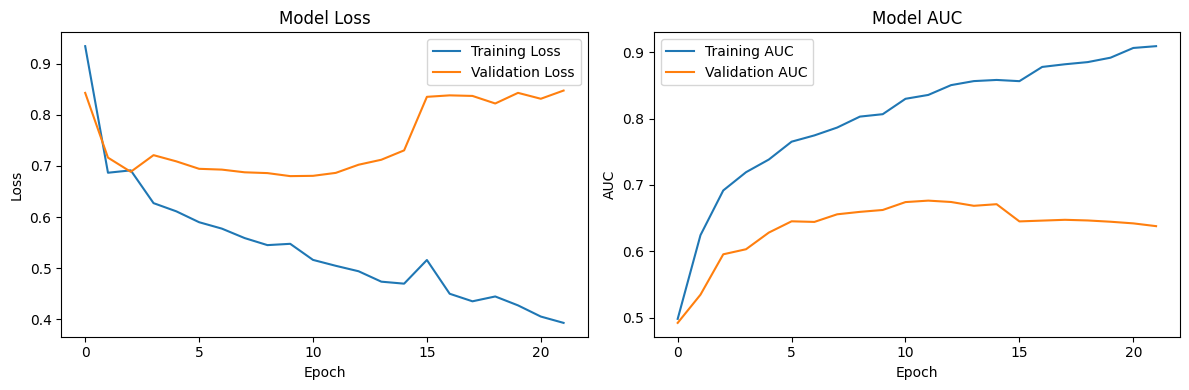

2025-01-19 18:31:43,317 - INFO - AUC, Logging: 0.7017531876138434


AUC: 0.7017531876138434
Loading split data for Labs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - auc: 0.5275 - loss: 1.1694

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - auc: 0.5275 - loss: 1.1686 - val_auc: 0.5782 - val_loss: 2.7051
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.6574 - loss: 1.7037 - val_auc: 0.6152 - val_loss: 3.0698
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.7012 - loss: 1.7291 - val_auc: 0.6083 - val_loss: 2.2829
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7419 - loss: 0.7152 - val_auc: 0.6141 - val_loss: 2.8168
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.7476 - loss: 0.6680 - val_auc: 0.6176 - val_loss: 2.8979
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - auc: 0.7776 - loss: 0.7135 - val_auc: 0.6109 - val_loss: 2.9033
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.7502 - loss: 1.3719 - val_auc: 0.6040 - val_loss: 1.9952
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.7931 - loss: 2.0372 - val_auc: 0.6042 - val_loss: 0.7679
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.8101 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

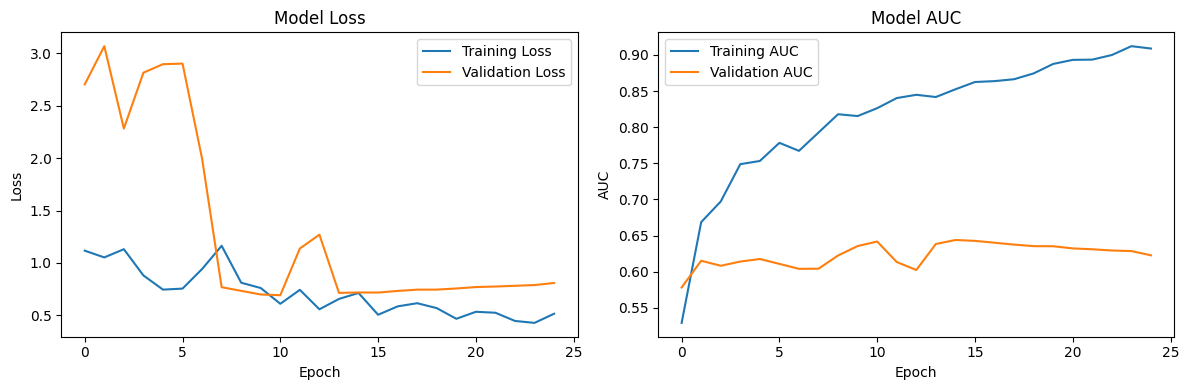

2025-01-19 18:34:05,121 - INFO - AUC, Logging: 0.619672131147541


AUC: 0.619672131147541
Loading split data for Labs, Fusion, rep 6 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - auc: 0.5292 - loss: 1.1862

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - auc: 0.5290 - loss: 1.1824 - val_auc: 0.5746 - val_loss: 0.8484
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.6632 - loss: 0.7654 - val_auc: 0.6544 - val_loss: 1.0001
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.6974 - loss: 0.8160 - val_auc: 0.6698 - val_loss: 1.0576
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7264 - loss: 0.6967 - val_auc: 0.6727 - val_loss: 1.1705
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - auc: 0.7535 - loss: 0.5926 - val_auc: 0.6816 - val_loss: 1.2031
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - auc: 0.7970 - loss: 0.5840 - val_auc: 0.6786 - val_loss: 1.2707
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7826 - loss: 0.5690 - val_auc: 0.6758 - val_loss: 1.3767
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.7904 - loss: 0.5543 - val_auc: 0.6789 - val_loss: 1.3997
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.8062 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

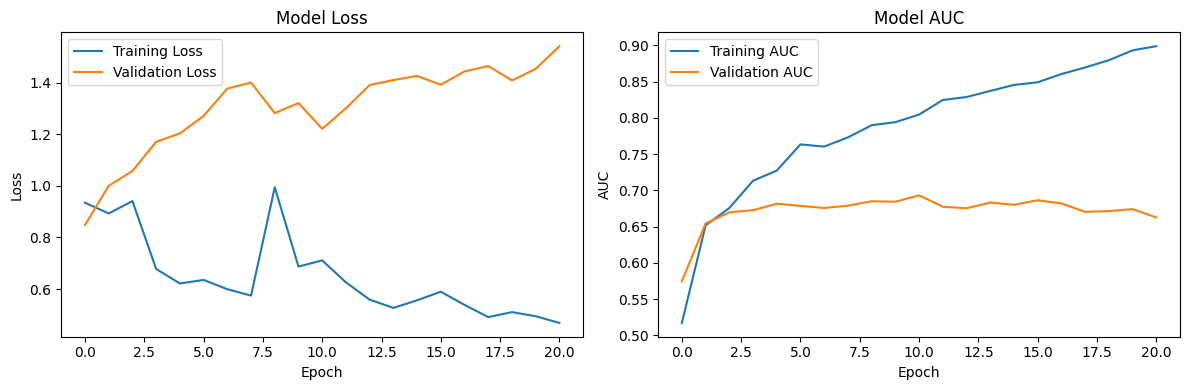

2025-01-19 18:35:59,770 - INFO - AUC, Logging: 0.6985129859873186


AUC: 0.6985129859873186
Loading split data for Labs, Fusion, rep 7 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - auc: 0.5122 - loss: 0.9219

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - auc: 0.5128 - loss: 0.9194 - val_auc: 0.5878 - val_loss: 0.6765
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - auc: 0.6218 - loss: 0.6843 - val_auc: 0.6341 - val_loss: 0.6638
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.6906 - loss: 0.6364 - val_auc: 0.6494 - val_loss: 0.6509
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - auc: 0.7348 - loss: 0.6142 - val_auc: 0.6528 - val_loss: 0.6561
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.7453 - loss: 0.6612 - val_auc: 0.6572 - val_loss: 0.6447
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7730 - loss: 0.6054 - val_auc: 0.6568 - val_loss: 0.6517
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7915 - loss: 0.5535 - val_auc: 0.6669 - val_loss: 0.6548
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.8001 - loss: 0.5409 - val_auc: 0.6735 - val_loss: 0.6468
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.8286 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

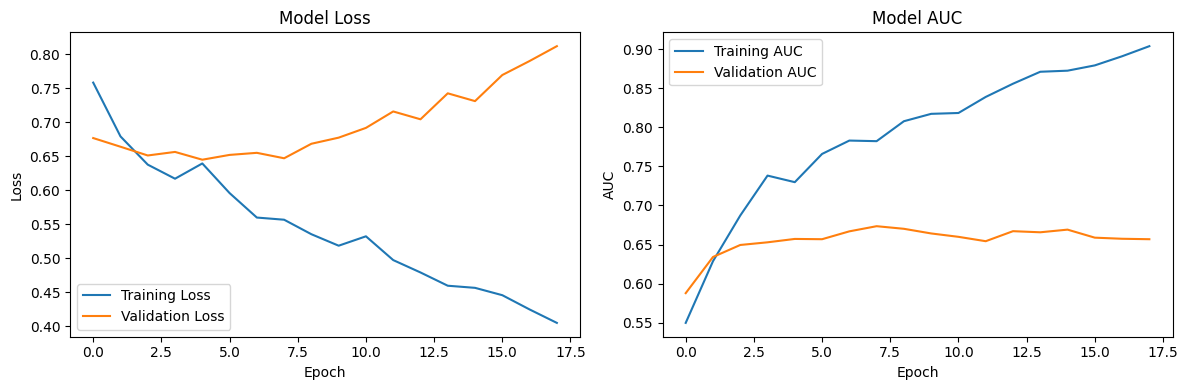

2025-01-19 18:37:25,304 - INFO - AUC, Logging: 0.6925091074681239


AUC: 0.6925091074681239
Loading split data for Labs, Fusion, rep 7 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.5345 - loss: 0.8158

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.5348 - loss: 0.8150 - val_auc: 0.5816 - val_loss: 0.6819
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.6456 - loss: 0.6763 - val_auc: 0.6136 - val_loss: 0.6733
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7144 - loss: 0.6299 - val_auc: 0.6136 - val_loss: 0.6757
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7127 - loss: 0.6276 - val_auc: 0.6355 - val_loss: 0.6727
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7229 - loss: 0.6089 - val_auc: 0.6348 - val_loss: 0.6772
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7455 - loss: 0.5951 - val_auc: 0.6388 - val_loss: 0.6790
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8065 - loss: 0.5387 - val_auc: 0.6332 - val_loss: 0.6925
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7902 - loss: 0.5595 - val_auc: 0.6394 - val_loss: 0.6864
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8225 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

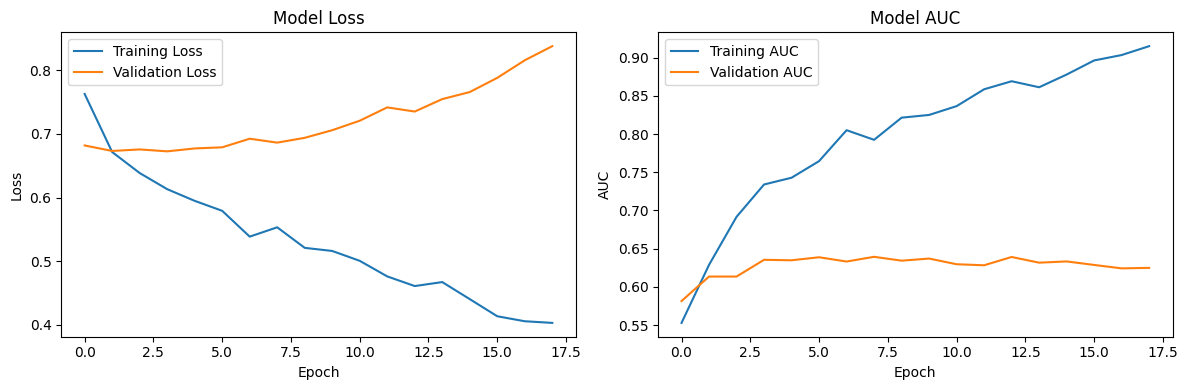

2025-01-19 18:38:43,915 - INFO - AUC, Logging: 0.7173952641165756


AUC: 0.7173952641165756
Loading split data for Labs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.5097 - loss: 0.7151

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.5101 - loss: 0.7149 - val_auc: 0.6658 - val_loss: 0.6603
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6323 - loss: 0.6653 - val_auc: 0.6869 - val_loss: 0.6634
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7045 - loss: 0.6318 - val_auc: 0.6966 - val_loss: 0.6567
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7286 - loss: 0.6147 - val_auc: 0.6967 - val_loss: 0.6692
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7385 - loss: 0.6019 - val_auc: 0.6930 - val_loss: 0.6797
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7402 - loss: 0.5941 - val_auc: 0.6877 - val_loss: 0.6871
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7867 - loss: 0.5546 - val_auc: 0.6863 - val_loss: 0.7048
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7889 - loss: 0.5596 - val_auc: 0.6803 - val_loss: 0.7019
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8127 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

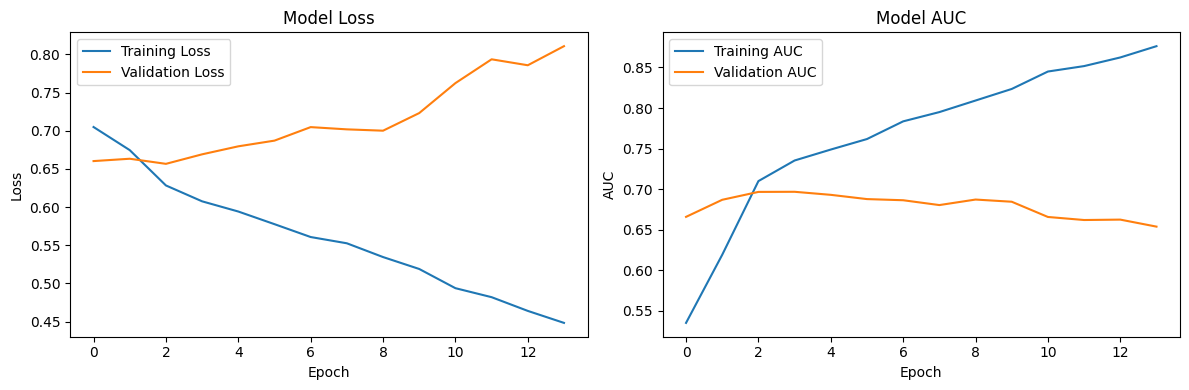

2025-01-19 18:39:43,839 - INFO - AUC, Logging: 0.6739754098360656


AUC: 0.6739754098360656
Loading split data for Labs, Fusion, rep 7 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - auc: 0.4802 - loss: 1.0412

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.4807 - loss: 1.0398 - val_auc: 0.6215 - val_loss: 0.6781
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6036 - loss: 0.7741 - val_auc: 0.6999 - val_loss: 0.6420
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6810 - loss: 0.6656 - val_auc: 0.7029 - val_loss: 0.6318
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7209 - loss: 0.6267 - val_auc: 0.7014 - val_loss: 0.6268
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7220 - loss: 0.6301 - val_auc: 0.6932 - val_loss: 0.6324
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7471 - loss: 0.6032 - val_auc: 0.6913 - val_loss: 0.6369
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7707 - loss: 0.7048 - val_auc: 0.6875 - val_loss: 0.6419
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7853 - loss: 0.5539 - val_auc: 0.6824 - val_loss: 0.6436
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.8094 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

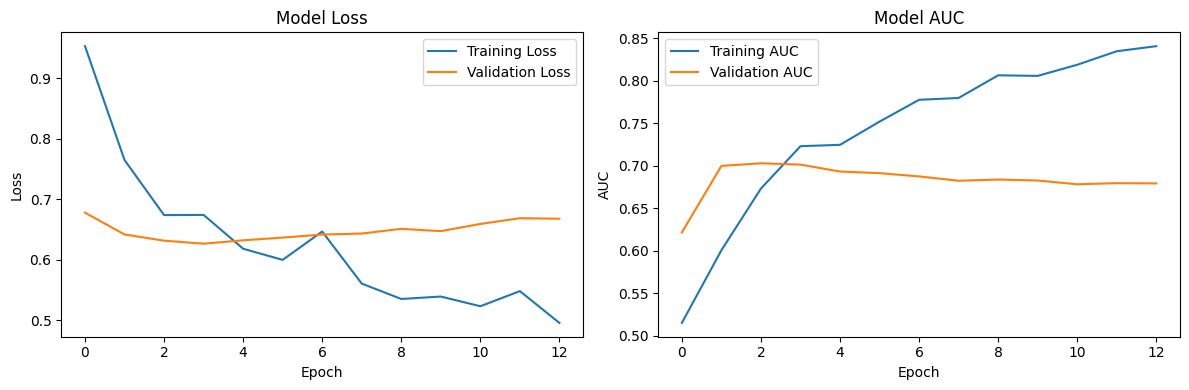

2025-01-19 18:40:36,132 - INFO - AUC, Logging: 0.6960837887067395


AUC: 0.6960837887067395
Loading split data for Labs, Fusion, rep 7 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.5100 - loss: 1.0429

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - auc: 0.5102 - loss: 1.0430 - val_auc: 0.6604 - val_loss: 0.6646
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.6072 - loss: 0.9218 - val_auc: 0.7171 - val_loss: 0.6470
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6535 - loss: 0.8333 - val_auc: 0.7234 - val_loss: 0.6298
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7060 - loss: 0.7288 - val_auc: 0.7376 - val_loss: 0.6148
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7235 - loss: 0.7761 - val_auc: 0.7387 - val_loss: 0.6034
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7366 - loss: 0.6620 - val_auc: 0.7419 - val_loss: 0.5945
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7973 - loss: 0.6138 - val_auc: 0.7428 - val_loss: 0.5867
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7781 - loss: 0.7037 - val_auc: 0.7570 - val_loss: 0.5797
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8118 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

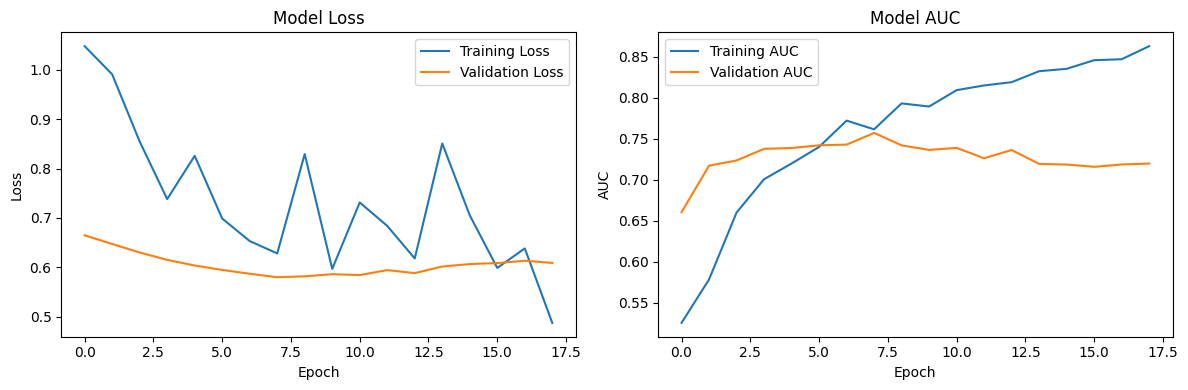

2025-01-19 18:41:55,936 - INFO - AUC, Logging: 0.6680055057878467


AUC: 0.6680055057878467
Loading split data for Labs, Fusion, rep 8 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.5622 - loss: 1.7885

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - auc: 0.5620 - loss: 1.7813 - val_auc: 0.6077 - val_loss: 0.6794
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.6779 - loss: 0.8419 - val_auc: 0.6397 - val_loss: 0.6721
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7023 - loss: 0.7195 - val_auc: 0.6415 - val_loss: 0.6679
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7311 - loss: 0.6468 - val_auc: 0.6477 - val_loss: 0.6630
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7301 - loss: 0.6462 - val_auc: 0.6514 - val_loss: 0.6598
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7713 - loss: 0.5851 - val_auc: 0.6667 - val_loss: 0.6509
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7667 - loss: 0.6496 - val_auc: 0.6703 - val_loss: 0.6506
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7786 - loss: 0.6325 - val_auc: 0.6694 - val_loss: 0.6537
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7916 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

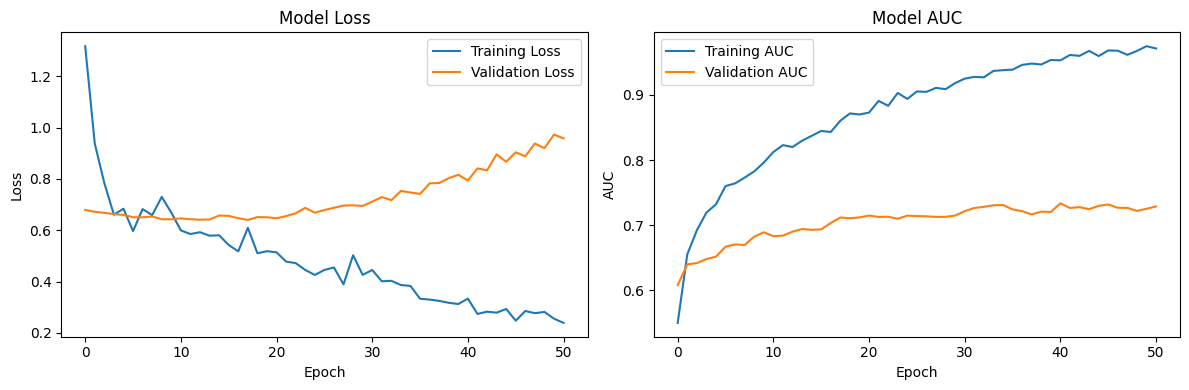

2025-01-19 18:45:39,096 - INFO - AUC, Logging: 0.6708902550091075


AUC: 0.6708902550091075
Loading split data for Labs, Fusion, rep 8 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.5194 - loss: 0.9072

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.5196 - loss: 0.9056 - val_auc: 0.6650 - val_loss: 0.6613
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6673 - loss: 0.6827 - val_auc: 0.6878 - val_loss: 0.6470
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7172 - loss: 0.6270 - val_auc: 0.7000 - val_loss: 0.6364
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7675 - loss: 0.5964 - val_auc: 0.7090 - val_loss: 0.6297
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7718 - loss: 0.5825 - val_auc: 0.7022 - val_loss: 0.6276
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.8025 - loss: 0.5523 - val_auc: 0.7036 - val_loss: 0.6214
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.8120 - loss: 0.5407 - val_auc: 0.7056 - val_loss: 0.6227
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.8064 - loss: 0.5387 - val_auc: 0.6995 - val_loss: 0.6246
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8273 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

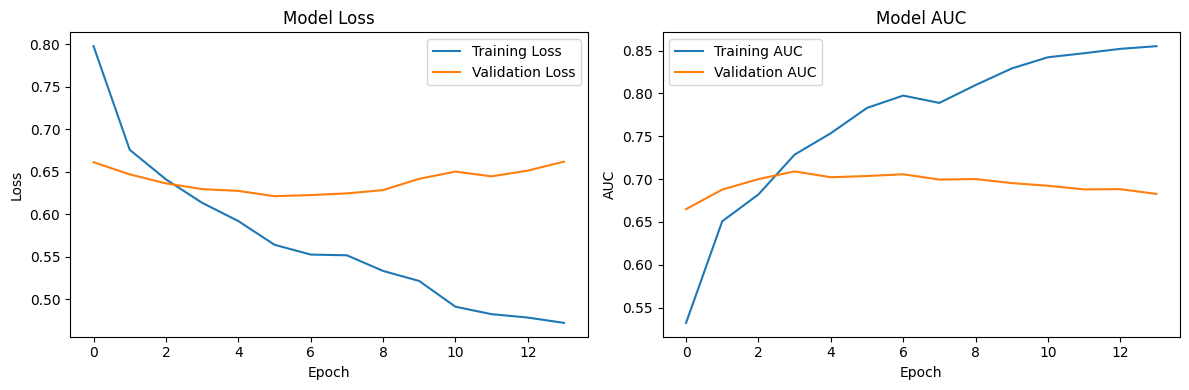

2025-01-19 18:46:33,120 - INFO - AUC, Logging: 0.665004553734062


AUC: 0.665004553734062
Loading split data for Labs, Fusion, rep 8 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.5353 - loss: 1.1039

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5354 - loss: 1.1011 - val_auc: 0.5648 - val_loss: 0.6920
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6729 - loss: 0.6975 - val_auc: 0.6170 - val_loss: 0.6771
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7070 - loss: 0.6708 - val_auc: 0.6358 - val_loss: 0.6678
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7479 - loss: 0.6260 - val_auc: 0.6347 - val_loss: 0.6665
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7650 - loss: 0.5872 - val_auc: 0.6312 - val_loss: 0.6732
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7837 - loss: 0.5783 - val_auc: 0.6333 - val_loss: 0.6829
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7734 - loss: 0.5690 - val_auc: 0.6407 - val_loss: 0.6766
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8052 - loss: 0.5364 - val_auc: 0.6472 - val_loss: 0.6771
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7963 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

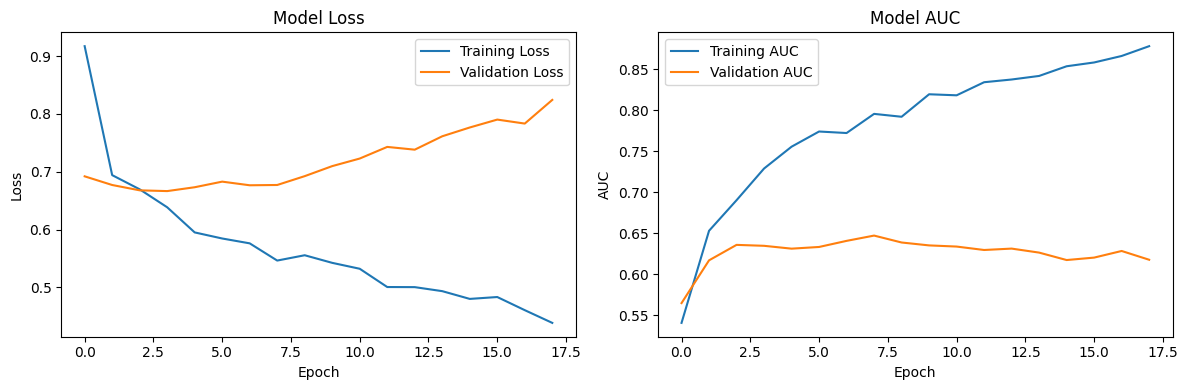

2025-01-19 18:47:38,286 - INFO - AUC, Logging: 0.6617941712204006


AUC: 0.6617941712204006
Loading split data for Labs, Fusion, rep 8 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.5038 - loss: 0.7846 - val_auc: 0.6458 - val_loss: 0.6659
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6461 - loss: 0.8989 - val_auc: 0.7187 - val_loss: 0.6471
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6959 - loss: 0.8923 - val_auc: 0.7445 - val_loss: 0.6334
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7221 - loss: 0.8287 - val_auc: 0.7506 - val_loss: 0.6220
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7078 - loss: 0.6917 - val_auc: 0.7647 - val_loss: 0.6048
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7570 - loss: 0.6712 - val_auc: 0.7659 - val_loss: 0.5961
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7655 - loss: 0.6781 - val_auc: 0.7722 - val_loss: 0.5854
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7693 - loss: 0.6627 - val_auc: 0.7792 - val_loss: 0.5751
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7803 - loss: 0.6458 - val_auc: 0.7814 - val_loss: 0.5703
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8012 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

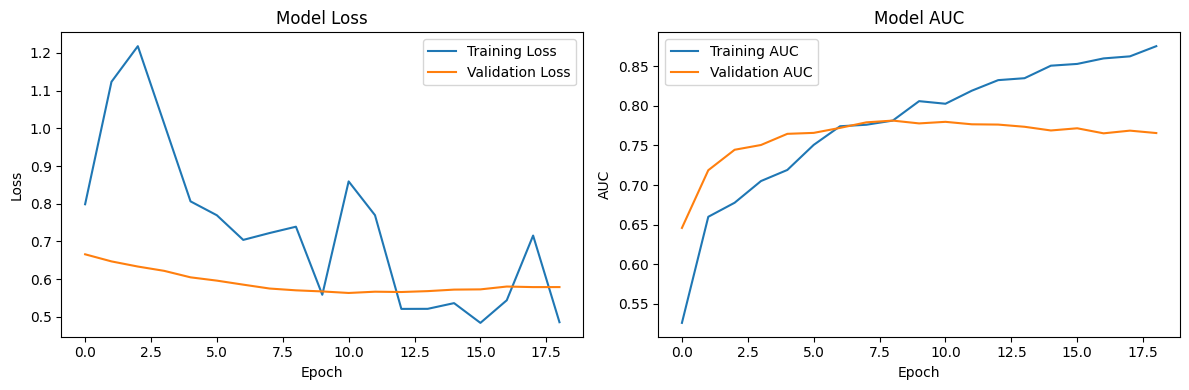

2025-01-19 18:48:48,936 - INFO - AUC, Logging: 0.7220856102003643


AUC: 0.7220856102003643
Loading split data for Labs, Fusion, rep 8 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.5103 - loss: 1.1505

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.5107 - loss: 1.1477 - val_auc: 0.6937 - val_loss: 0.6540
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.6339 - loss: 1.1308 - val_auc: 0.7047 - val_loss: 0.7300
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7060 - loss: 0.6513 - val_auc: 0.7132 - val_loss: 0.6299
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7095 - loss: 0.9906 - val_auc: 0.7139 - val_loss: 0.7919
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7315 - loss: 1.2665 - val_auc: 0.7042 - val_loss: 1.0918
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7452 - loss: 0.6409 - val_auc: 0.7081 - val_loss: 0.8543
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7900 - loss: 0.5907 - val_auc: 0.7085 - val_loss: 0.6741
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7724 - loss: 0.6438 - val_auc: 0.7220 - val_loss: 0.6246
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7889 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

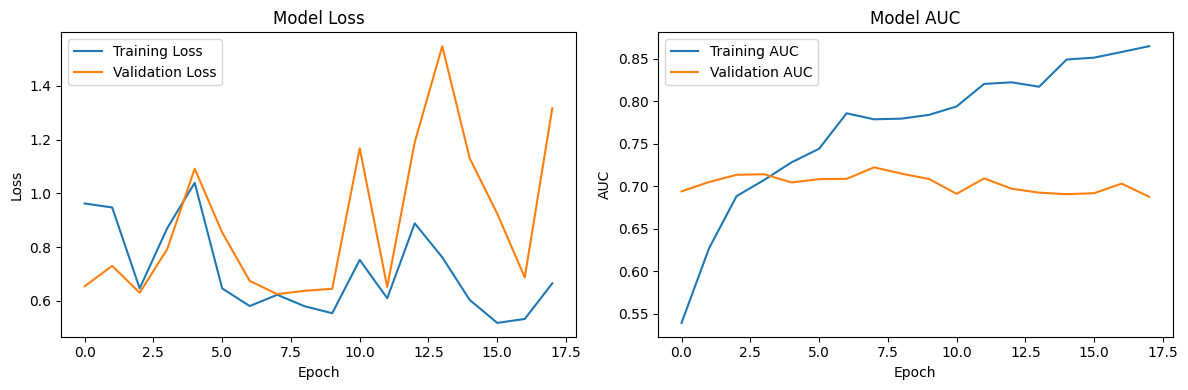

2025-01-19 18:49:54,354 - INFO - AUC, Logging: 0.7652593812758084


AUC: 0.7652593812758084
Loading split data for Labs, Fusion, rep 9 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.4848 - loss: 0.7716 - val_auc: 0.6071 - val_loss: 0.6713


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.6360 - loss: 0.8686 - val_auc: 0.6555 - val_loss: 0.6583
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6616 - loss: 0.7600 - val_auc: 0.6796 - val_loss: 0.6499
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7292 - loss: 0.8139 - val_auc: 0.6954 - val_loss: 0.6388
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7390 - loss: 0.6051 - val_auc: 0.6930 - val_loss: 0.6405
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7453 - loss: 0.5868 - val_auc: 0.6957 - val_loss: 0.6397
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7702 - loss: 0.8549 - val_auc: 0.6945 - val_loss: 0.6444
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7849 - loss: 0.6089 - val_auc: 0.6976 - val_loss: 0.6466
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8135 - loss: 0.5370 - val_auc: 0.6937 - val_loss: 0.6557
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - a

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

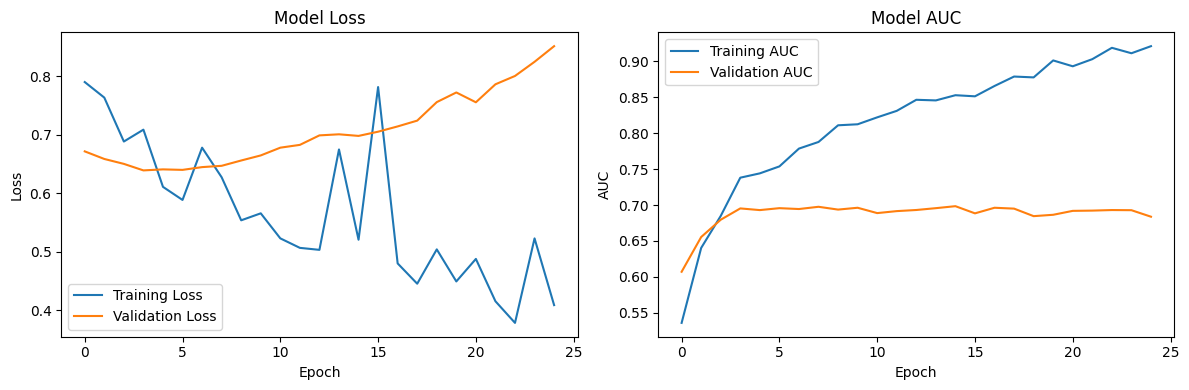

2025-01-19 18:51:23,659 - INFO - AUC, Logging: 0.6947404371584699


AUC: 0.6947404371584699
Loading split data for Labs, Fusion, rep 9 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.5469 - loss: 0.9813 - val_auc: 0.6077 - val_loss: 0.8525
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6548 - loss: 0.6758 - val_auc: 0.6666 - val_loss: 0.6760
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6708 - loss: 0.8400 - val_auc: 0.6791 - val_loss: 0.6717
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7347 - loss: 0.7248 - val_auc: 0.6866 - val_loss: 0.6837
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7422 - loss: 0.6737 - val_auc: 0.6868 - val_loss: 0.7922
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7454 - loss: 0.5956 - val_auc: 0.6778 - val_loss: 0.8938
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7825 - loss: 0.5759 - val_auc: 0.6868 - val_loss: 0.8008
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - auc: 0.7911 - loss: 0.7740 - val_auc: 0.6735 - val_loss: 0.8553
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - auc: 0.8014 - loss: 0.6171 - val_auc: 0.6673 - val_loss: 0.9302
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7999 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

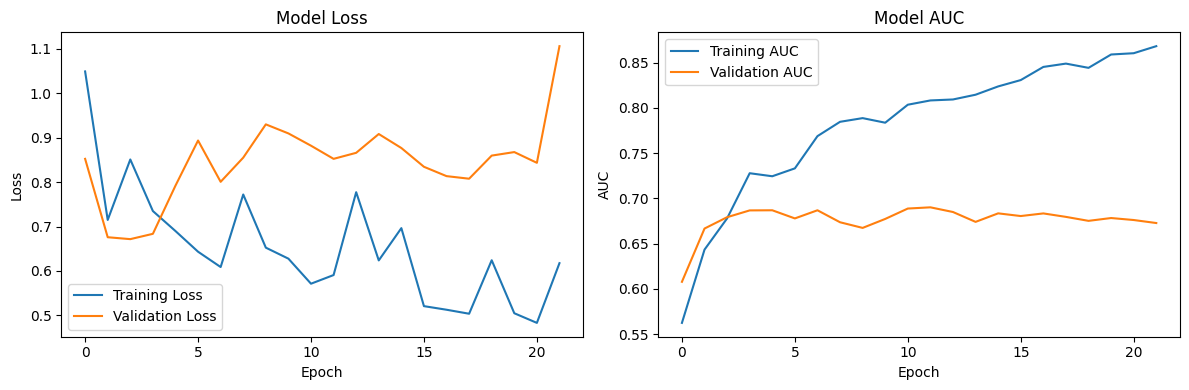

2025-01-19 18:52:54,562 - INFO - AUC, Logging: 0.6865209471766849


AUC: 0.6865209471766849
Loading split data for Labs, Fusion, rep 9 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.4984 - loss: 0.8253

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.4989 - loss: 0.8244 - val_auc: 0.6346 - val_loss: 0.6707
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.6080 - loss: 0.7915 - val_auc: 0.6930 - val_loss: 0.6465
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.6462 - loss: 0.6487 - val_auc: 0.7174 - val_loss: 0.6325
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7076 - loss: 0.6199 - val_auc: 0.7241 - val_loss: 0.6202
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7071 - loss: 0.6161 - val_auc: 0.7265 - val_loss: 0.6140
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7247 - loss: 0.6040 - val_auc: 0.7245 - val_loss: 0.6085
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7494 - loss: 0.5798 - val_auc: 0.7280 - val_loss: 0.5997
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7562 - loss: 0.5762 - val_auc: 0.7250 - val_loss: 0.6051
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7841 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

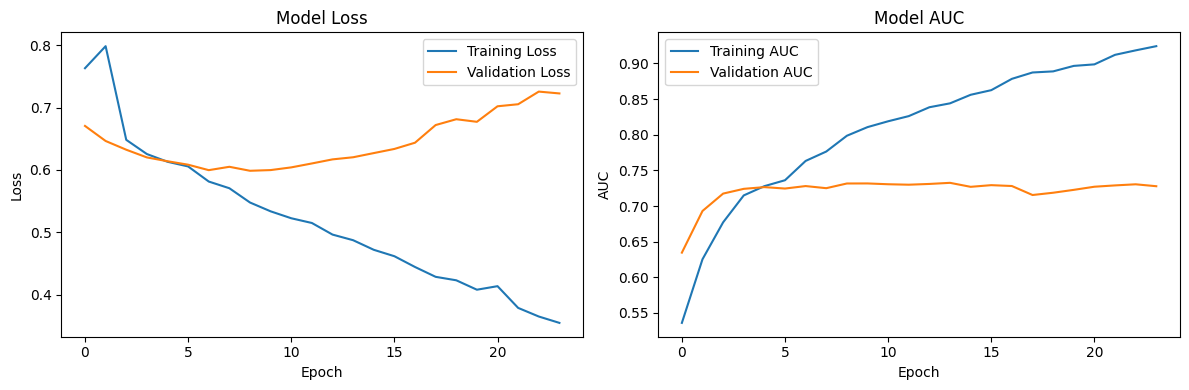

2025-01-19 18:54:31,781 - INFO - AUC, Logging: 0.7291097449908926


AUC: 0.7291097449908926
Loading split data for Labs, Fusion, rep 9 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.5383 - loss: 0.8262 - val_auc: 0.5801 - val_loss: 1.7106
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.6293 - loss: 0.7109 - val_auc: 0.6468 - val_loss: 1.7513
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6791 - loss: 0.7278 - val_auc: 0.6728 - val_loss: 2.0094
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7201 - loss: 0.8500 - val_auc: 0.6871 - val_loss: 2.4865
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7396 - loss: 0.7023 - val_auc: 0.6877 - val_loss: 2.3861
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7466 - loss: 0.6059 - val_auc: 0.6922 - val_loss: 3.3499
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7588 - loss: 0.5762 - val_auc: 0.6923 - val_loss: 3.4637
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7787 - loss: 0.5551 - val_auc: 0.6911 - val_loss: 3.4900
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8126 - loss: 0.5278 - val_auc: 0.6905 - val_loss: 3.6656
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.8182 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

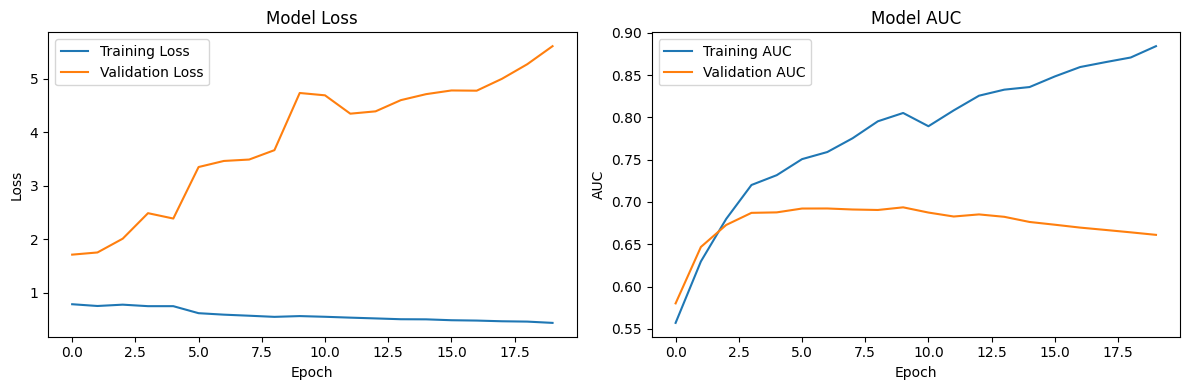

2025-01-19 18:55:44,167 - INFO - AUC, Logging: 0.7367941712204008


AUC: 0.7367941712204008
Loading split data for Labs, Fusion, rep 9 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5009 - loss: 0.9577 - val_auc: 0.6214 - val_loss: 1.8434
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6237 - loss: 0.8860 - val_auc: 0.6502 - val_loss: 2.0037
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6394 - loss: 1.0304 - val_auc: 0.6589 - val_loss: 2.3716
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7159 - loss: 0.7774 - val_auc: 0.6639 - val_loss: 2.3697
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7183 - loss: 0.7899 - val_auc: 0.6897 - val_loss: 2.5128
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7494 - loss: 0.6166 - val_auc: 0.6871 - val_loss: 2.7490
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7724 - loss: 0.6131 - val_auc: 0.6832 - val_loss: 3.3806
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7801 - loss: 0.6027 - val_auc: 0.6834 - val_loss: 3.4229
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7956 - loss: 0.6149 - val_auc: 0.6756 - val_loss: 3.4695
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8135 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 54)             │         5,778 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,875 (85.45 KB)

 Trainable params: 7,291 (28.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,584 (56.97 KB)

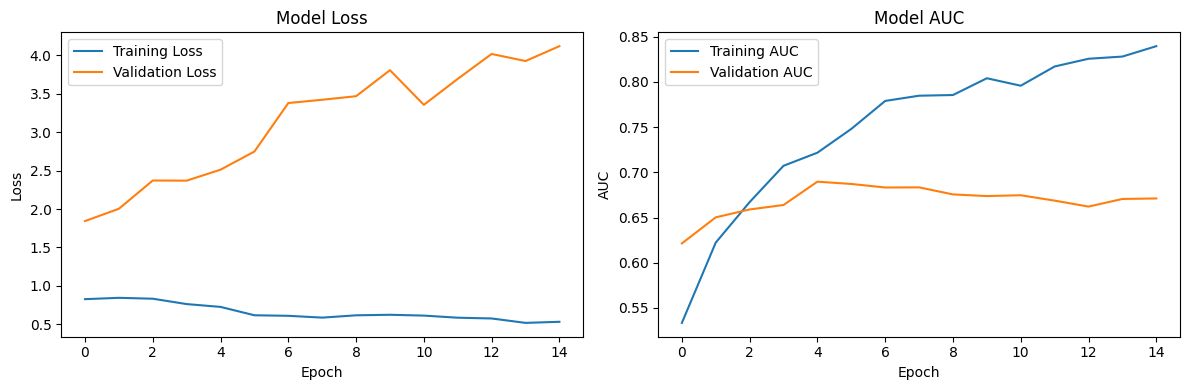

2025-01-19 18:56:38,272 - INFO - AUC, Logging: 0.6808561048807455


AUC: 0.6808561048807455


In [77]:
NN_start_time = time.time()
NN_results, NN_auc_results = NN_model_train_test(procedure_of_interest)
log_execution(csv_path, 'NN', NN_start_time)


#### NN Save

In [78]:
NN_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_NN_" + "auc_data.csv")
NN_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_NN_"+ "model_results.csv")

### Linear SVC

In [79]:
## SVC
def linear_svc_train_test(procedure):
    
    SVC_results_list = []
    SVC_auc_list = []
    SVC_shap_full_list = []
    SVC_shap_summary_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            LinSVC_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = LinSVC_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            SVC_model_fitted, y_pred, y_prob_vec, shap_values = Linear_SVC_model(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(SVC_results_list, SVC_auc_list, outcome, procedure, feature,
                            "LinearSVC", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(SVC_shap_full_list, SVC_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure, feature, "LinearSVC",
                                    rep, i)
            else:
                print("Not Collecting Shaps")
            
            LinSVC_temp_results = pd.concat(SVC_results_list, ignore_index=True)
            LinSVC_temp_auc_results = pd.concat(SVC_auc_list, ignore_index=True)
            LinSVC_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_SVC_" + "auc_data.csv")
            LinSVC_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                LinSVC_temp_shap_long_results = pd.concat(SVC_shap_full_list, ignore_index=True)
                LinSVC_temp_shap_summary_results = pd.concat(SVC_shap_summary_list, ignore_index=True)
                LinSVC_temp_shap_long_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+"feature_importance_full.csv")
                LinSVC_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+"feature_importance.csv")
            else:
                print("Not saving temp shaps")
            
            
            

    SVC_results = pd.concat(SVC_results_list, ignore_index=True)
    SVC_auc_results = pd.concat(SVC_auc_list, ignore_index=True)
    if Get_shaps:
        print("Saving final shaps")
        SVC_shap_long_results = pd.concat(SVC_shap_full_list, ignore_index=True)
        SVC_shap_summary_results = pd.concat(SVC_shap_summary_list, ignore_index=True)
    else:
        print("NOT saving final shaps")
        SVC_shap_long_results = None
        SVC_shap_summary_results = None

    return SVC_results, SVC_auc_results, SVC_shap_long_results, SVC_shap_summary_results


#### LinSVC run

In [80]:
LinSVC_start_time = time.time()
LinSVC_results, LinSVC_auc_results, LinSVC_shap_long_results, LinSVC_shap_summary_results = linear_svc_train_test(procedure_of_interest)
log_execution(csv_path, 'LinSVC', LinSVC_start_time)

2025-01-19 18:56:38,937	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for Labs, Fusion, rep 0 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0


2025-01-19 18:56:53,854	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 18:57:00,210	INFO tune.py:1042 -- Total run time: 21.27 seconds (18.64 seconds for the tuning loop).
2025-01-19 18:57:00,401 - INFO - AUC, Logging: 0.7391393442622951
2025-01-19 18:57:00,494	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7391393442622951
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1


2025-01-19 18:57:14,344	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 18:57:20,407	INFO tune.py:1042 -- Total run time: 19.91 seconds (16.10 seconds for the tuning loop).
2025-01-19 18:57:20,617 - INFO - AUC, Logging: 0.6882513661202185
2025-01-19 18:57:20,669	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6882513661202185
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2


2025-01-19 18:57:59,328	INFO tune.py:1042 -- Total run time: 38.66 seconds (38.63 seconds for the tuning loop).
2025-01-19 18:58:00,642 - INFO - AUC, Logging: 0.7233834244080146
2025-01-19 18:58:00,700	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7233834244080146
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3


2025-01-19 18:58:29,557	INFO tune.py:1042 -- Total run time: 28.86 seconds (27.89 seconds for the tuning loop).
2025-01-19 18:58:30,084 - INFO - AUC, Logging: 0.70066029143898
2025-01-19 18:58:30,198	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.70066029143898
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4


2025-01-19 18:58:59,516	INFO tune.py:1042 -- Total run time: 29.32 seconds (27.67 seconds for the tuning loop).
2025-01-19 18:58:59,796 - INFO - AUC, Logging: 0.700904844642011
2025-01-19 18:58:59,898	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.700904844642011
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0


2025-01-19 18:59:25,468	INFO tune.py:1042 -- Total run time: 25.57 seconds (23.99 seconds for the tuning loop).
2025-01-19 18:59:25,603 - INFO - AUC, Logging: 0.7140938069216758
2025-01-19 18:59:25,695	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7140938069216758
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1


2025-01-19 18:59:41,510	INFO tune.py:1042 -- Total run time: 15.81 seconds (14.77 seconds for the tuning loop).
2025-01-19 18:59:41,751 - INFO - AUC, Logging: 0.7434198542805099
2025-01-19 18:59:41,823	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7434198542805099
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2


2025-01-19 19:00:03,058	INFO tune.py:1042 -- Total run time: 21.24 seconds (17.09 seconds for the tuning loop).
2025-01-19 19:00:03,205 - INFO - AUC, Logging: 0.6786885245901639
2025-01-19 19:00:03,294	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6786885245901639
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3


2025-01-19 19:00:41,534	INFO tune.py:1042 -- Total run time: 38.24 seconds (38.21 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025-01-19 19:00:42,513 - INFO - AUC, Logging: 0.6931010928961748
2025-01-19 19:00:42,584	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6931010928961748
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4


2025-01-19 19:00:59,113	INFO tune.py:1042 -- Total run time: 16.53 seconds (16.30 seconds for the tuning loop).
2025-01-19 19:00:59,275 - INFO - AUC, Logging: 0.729810230836925
2025-01-19 19:00:59,383	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.729810230836925
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0


2025-01-19 19:01:18,847	INFO tune.py:1042 -- Total run time: 19.46 seconds (19.29 seconds for the tuning loop).
2025-01-19 19:01:19,070 - INFO - AUC, Logging: 0.7293715846994535
2025-01-19 19:01:19,160	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7293715846994535
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1


2025-01-19 19:01:34,705	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:01:36,489	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:01:42,169	INFO tune.py:1042 -- Total run time: 23.01 seconds (19.39 seconds for the tuning loop).
2025-01-19 19:01:42,384 - INFO - AUC, Logging: 0.6620446265938069
2025-01-19 19:01:42,487	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6620446265938069
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2


2025-01-19 19:02:33,207	INFO tune.py:1042 -- Total run time: 50.72 seconds (50.69 seconds for the tuning loop).
2025-01-19 19:02:33,474 - INFO - AUC, Logging: 0.7409608378870675
2025-01-19 19:02:33,573	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7409608378870675
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3


2025-01-19 19:02:50,315	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:02:51,621	INFO tune.py:1042 -- Total run time: 18.05 seconds (17.89 seconds for the tuning loop).
2025-01-19 19:02:51,757 - INFO - AUC, Logging: 0.7328551912568306
2025-01-19 19:02:51,853	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7328551912568306
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 2 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4


2025-01-19 19:03:08,390	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:03:18,394	INFO tune.py:1042 -- Total run time: 26.54 seconds (22.89 seconds for the tuning loop).
2025-01-19 19:03:18,593 - INFO - AUC, Logging: 0.7204233138524719
2025-01-19 19:03:18,690	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7204233138524719
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0


2025-01-19 19:03:47,879	INFO tune.py:1042 -- Total run time: 29.19 seconds (25.55 seconds for the tuning loop).
2025-01-19 19:03:48,065 - INFO - AUC, Logging: 0.6937613843351549
2025-01-19 19:03:48,176	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6937613843351549
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1


2025-01-19 19:04:06,600	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:04:09,795	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:04:11,459	INFO tune.py:1042 -- Total run time: 23.28 seconds (23.24 seconds for the tuning loop).
2025-01-19 19:04:12,499 - INFO - AUC, Logging: 0.7237249544626594
2025-01-19 19:04:12,622	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7237249544626594
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2


2025-01-19 19:04:59,570	INFO tune.py:1042 -- Total run time: 46.95 seconds (46.91 seconds for the tuning loop).
2025-01-19 19:05:01,124 - INFO - AUC, Logging: 0.7198315118397086


NO SHAPS FOR YOU
AUC: 0.7198315118397086
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3


2025-01-19 19:05:01,351	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 19:05:16,978	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:05:18,545	INFO tune.py:1042 -- Total run time: 17.19 seconds (16.31 seconds for the tuning loop).
2025-01-19 19:05:18,753 - INFO - AUC, Logging: 0.724476320582878
2025-01-19 19:05:18,898	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.724476320582878
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4


2025-01-19 19:05:53,543	INFO tune.py:1042 -- Total run time: 34.64 seconds (32.68 seconds for the tuning loop).
2025-01-19 19:05:54,025 - INFO - AUC, Logging: 0.6975878331114471
2025-01-19 19:05:54,165	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6975878331114471
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0


2025-01-19 19:06:24,267	INFO tune.py:1042 -- Total run time: 30.10 seconds (28.15 seconds for the tuning loop).
2025-01-19 19:06:24,735 - INFO - AUC, Logging: 0.6998178506375228
2025-01-19 19:06:24,846	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6998178506375228
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1


2025-01-19 19:06:39,540	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:06:45,614	INFO tune.py:1042 -- Total run time: 20.77 seconds (16.77 seconds for the tuning loop).
2025-01-19 19:06:45,862 - INFO - AUC, Logging: 0.7364526411657559
2025-01-19 19:06:45,971	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7364526411657559
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2


2025-01-19 19:07:14,223	INFO tune.py:1042 -- Total run time: 28.25 seconds (23.80 seconds for the tuning loop).
2025-01-19 19:07:14,442 - INFO - AUC, Logging: 0.7042349726775956
2025-01-19 19:07:14,599	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7042349726775956
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3


2025-01-19 19:07:52,754	INFO tune.py:1042 -- Total run time: 38.16 seconds (37.93 seconds for the tuning loop).
2025-01-19 19:07:52,939 - INFO - AUC, Logging: 0.692167577413479
2025-01-19 19:07:53,079	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.692167577413479
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 4 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4


2025-01-19 19:08:29,744	INFO tune.py:1042 -- Total run time: 36.66 seconds (36.63 seconds for the tuning loop).
2025-01-19 19:08:29,924 - INFO - AUC, Logging: 0.7098404675406729
2025-01-19 19:08:30,074	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7098404675406729
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0


2025-01-19 19:08:53,873	INFO tune.py:1042 -- Total run time: 23.80 seconds (21.08 seconds for the tuning loop).
2025-01-19 19:08:54,028 - INFO - AUC, Logging: 0.716325136612022
2025-01-19 19:08:54,156	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.716325136612022
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1


2025-01-19 19:09:21,387	INFO tune.py:1042 -- Total run time: 27.23 seconds (24.99 seconds for the tuning loop).
2025-01-19 19:09:21,574 - INFO - AUC, Logging: 0.7151639344262295
2025-01-19 19:09:21,708	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7151639344262295
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2


2025-01-19 19:09:57,527	INFO tune.py:1042 -- Total run time: 35.82 seconds (34.61 seconds for the tuning loop).
2025-01-19 19:09:57,688 - INFO - AUC, Logging: 0.7235655737704919


NO SHAPS FOR YOU
AUC: 0.7235655737704919
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 3


2025-01-19 19:09:57,913	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3


2025-01-19 19:10:20,529	INFO tune.py:1042 -- Total run time: 22.62 seconds (18.72 seconds for the tuning loop).
2025-01-19 19:10:20,736 - INFO - AUC, Logging: 0.7067395264116575


NO SHAPS FOR YOU
AUC: 0.7067395264116575
Not Collecting Shaps


2025-01-19 19:10:21,099	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Not saving temp shaps
Loading split data for Labs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4


2025-01-19 19:10:36,901	INFO tune.py:1042 -- Total run time: 15.80 seconds (14.76 seconds for the tuning loop).
2025-01-19 19:10:37,266 - INFO - AUC, Logging: 0.6990771035945574
2025-01-19 19:10:37,455	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6990771035945574
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0


2025-01-19 19:11:01,877	INFO tune.py:1042 -- Total run time: 24.42 seconds (21.08 seconds for the tuning loop).
2025-01-19 19:11:02,253 - INFO - AUC, Logging: 0.725273224043716
2025-01-19 19:11:02,384	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.725273224043716
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1


2025-01-19 19:11:41,237	INFO tune.py:1042 -- Total run time: 38.85 seconds (36.03 seconds for the tuning loop).
2025-01-19 19:11:41,490 - INFO - AUC, Logging: 0.6939435336976321
2025-01-19 19:11:41,629	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6939435336976321
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2


2025-01-19 19:12:04,238	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-19 19:12:08,694	INFO tune.py:1042 -- Total run time: 27.07 seconds (23.65 seconds for the tuning loop).
2025-01-19 19:12:08,917 - INFO - AUC, Logging: 0.6983151183970856
2025-01-19 19:12:09,091	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.6983151183970856
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3


2025-01-19 19:12:26,999	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 1.491 s, which may be a performance bottleneck.
2025-01-19 19:12:27,004	WARNING util.py:202 -- The `process_trial_result` operation took 1.497 s, which may be a performance bottleneck.
2025-01-19 19:12:27,006	WARNING util.py:202 -- Processing trial results took 1.499 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-01-19 19:12:27,009	WARNING util.py:202 -- The `process_trial_result` operation took 1.502 s, which may be a performance bottleneck.
2025-01-19 19:12:42,727	INFO tune.py:1042 -- Total run time: 33.64 seconds (30.36 seconds for the tuning loop).
2025-01-19 19:12:42,922 - INFO - AUC, Logging: 0.6575591985428051


NO SHAPS FOR YOU
AUC: 0.6575591985428051
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 6 and fold 4


2025-01-19 19:12:43,241	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4


2025-01-19 19:13:11,137	INFO tune.py:1042 -- Total run time: 27.90 seconds (22.69 seconds for the tuning loop).
2025-01-19 19:13:11,512 - INFO - AUC, Logging: 0.7138795496085024


NO SHAPS FOR YOU
AUC: 0.7138795496085024
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0


2025-01-19 19:13:11,709	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 19:13:47,027	INFO tune.py:1042 -- Total run time: 35.32 seconds (35.27 seconds for the tuning loop).
2025-01-19 19:13:47,229 - INFO - AUC, Logging: 0.7246812386156648


NO SHAPS FOR YOU
AUC: 0.7246812386156648
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 1


2025-01-19 19:13:47,470	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1


2025-01-19 19:14:17,877	INFO tune.py:1042 -- Total run time: 30.41 seconds (28.50 seconds for the tuning loop).
2025-01-19 19:14:18,026 - INFO - AUC, Logging: 0.7408925318761383
2025-01-19 19:14:18,174	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7408925318761383
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2


2025-01-19 19:14:50,978	INFO tune.py:1042 -- Total run time: 32.80 seconds (32.47 seconds for the tuning loop).
2025-01-19 19:14:51,246 - INFO - AUC, Logging: 0.6885245901639344


NO SHAPS FOR YOU
AUC: 0.6885245901639344
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3


2025-01-19 19:14:51,455	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-19 19:15:12,990	INFO tune.py:1042 -- Total run time: 21.54 seconds (17.45 seconds for the tuning loop).
2025-01-19 19:15:13,144 - INFO - AUC, Logging: 0.7127732240437159
2025-01-19 19:15:13,324	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


NO SHAPS FOR YOU
AUC: 0.7127732240437159
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 7 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4


2025-01-19 19:15:38,931	INFO tune.py:1042 -- Total run time: 25.61 seconds (22.67 seconds for the tuning loop).
2025-01-19 19:15:39,111 - INFO - AUC, Logging: 0.715549337725929


NO SHAPS FOR YOU
AUC: 0.715549337725929
Not Collecting Shaps
Not saving temp shaps
Loading split data for Labs, Fusion, rep 8 and fold 0


2025-01-19 19:15:39,341	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0


OSError: [Errno 28] No space left on device

#### LinSVC Save

In [81]:
LinSVC_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_" + "auc_data.csv")
LinSVC_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Saving shap to csv")
    LinSVC_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+"feature_importance.csv")
    LinSVC_shap_long_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+"feature_importance_full.csv")
else:
    print("NOT saving shap to csv")

### LinearSVC with Kernels


In [83]:
# Lin SVC w Kernels
#TODO: Fix Shap results collection with Nystroem
def LinSVC_Kernel_model_train_test(procedure):
    SVCKern_results_list = []
    SVCKern_auc_list = []
    SVCKern_shap_full_list = []
    SVCKern_shap_summary_list = []
    SVCKern_kernel_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            LinSVCKernel_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = LinSVCKernel_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            SVC_model_fitted, y_pred, y_prob_vec, shap_values, best_kernel = SVC_model_with_kernels(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(SVCKern_results_list, SVCKern_auc_list, outcome, procedure_of_interest, feature,
                            "LinSVC_Kernel", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            kernel_row = pd.DataFrame(
                {
                    "Procedure": [procedure],
                    "Outcome": [outcome],
                    "Features": [feature],
                    "Model": ["LinSVC_Kernel"],
                    "Rep": [rep],
                    "Fold": [i],
                    "Best_Kernel": [best_kernel]
                }
            )

            SVCKern_kernel_list.append(kernel_row)


            
            LinSVCKern_temp_results = pd.concat(SVCKern_results_list, ignore_index=True)
            LinSVCKern_temp_auc_results = pd.concat(SVCKern_auc_list, ignore_index=True)
            #RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
            #RF_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
            
            LinSVCKern_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKern_" + "auc_data.csv")
            LinSVCKern_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKern_"+ "model_results.csv")
            #RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_RF_"+"feature_importance.csv")
            
            
            '''
            collect_shap_results(SVCKern_shap_full_list, SVCKern_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure_of_interest, feature, "LinSVC_Kernel",
                                    rep, i)
            '''
            
            

    LinSVC_Kernel_results = pd.concat(SVCKern_results_list, ignore_index=True)
    LinSVC_Kernel_auc = pd.concat(SVCKern_auc_list, ignore_index=True)
    LinSVC_Kernel_kernels = pd.concat(SVCKern_kernel_list, ignore_index=True)
    #LinSVC_Kernel_shap_full = pd.concat(SVCKern_shap_full_list, ignore_index=True)
    #LinSVC_Kernel_shap_summary = pd.concat(SVCKern_shap_summary_list, ignore_index=True)

    return LinSVC_Kernel_results, LinSVC_Kernel_auc, LinSVC_Kernel_kernels

#### LinSVC Kernel Run

In [ ]:
#LinSVC w/ Kernel no shap implementation right now TODO
import time
LinSVC_Kernel_start_time = time.time()
LinSVC_Kernel_results, LinSVC_Kernel_auc, LinSVC_Kernel_kernels = LinSVC_Kernel_model_train_test(procedure_of_interest)
log_execution(csv_path, "LinSVC_Kernel", LinSVC_Kernel_start_time)

#### LinSVC Kernel Save

In [85]:
LinSVC_Kernel_auc.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_" + "auc_data.csv")
LinSVC_Kernel_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_"+ "model_results.csv")
LinSVC_Kernel_kernels.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_"+ "kernelstested.csv")


## Shap Stuff for full dataset

### RF full dataset

#### Functions

In [202]:
def imputeData_FullDataset(x_train, y_train, rep, impute_number):
    # Combine x_train and y_train for imputation
    x_train = x_train.reset_index(drop=True)

    train_data = x_train.copy()
    train_data['target'] = y_train

    # Create and fit the imputation kernel
    
    kernel = mf.ImputationKernel(
        train_data,
        random_state=rep,
        variable_schema = NaNColumn_list
    )
    
    # Use sklearn pipeline method (as in examples)
    pipe = Pipeline([('impute', kernel)])
    
    # Perform imputation
    #kernel.mice(impute_number, verbose=True)  # Run 5 iterations, adjust as needed
    
    # Get the imputed training data
    #imputed_train = kernel.complete_data()

    imputed_train = pipe.fit_transform(train_data, impute__iterations = impute_number,
                                       impute__verbose=True)
    
    #imputed_train = post_imputation_cleanup(imputed_train)

    assert not np.any(np.isnan(imputed_train))

    # Separate features and target
    x_train_imputed = imputed_train.drop('target', axis=1)
    y_train_imputed = imputed_train['target']
    
    return x_train_imputed, y_train_imputed


In [203]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features, original_dtypes=None):
        self.numeric_features = numeric_features
        self.original_dtypes = original_dtypes #actually all Int64
        
    def fit(self, X, y=None):
        # We don't want to get dtypes from X here since it's already transformed
        # Instead, we'll pass in the original dtypes when creating the transformer
        return self
        
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.original_dtypes.index)
        
        # Restore original dtypes for non-numeric columns
        non_numeric_cols = [col for col in df.columns if col not in self.numeric_features]
        for col in non_numeric_cols:
            # Force the conversion using round() for integers
            df[col] = df[col].round()
            df[col] = df[col].astype('Int64')
            
        return df

In [204]:
# Get code ready for imputation
# Create standardized datasets
def preImpute_Full(input_X, input_y, rep, preprocessor, impute_number):
    '''
    input_X: X_data (df_preds)
    input_y: y_data (outcomes, no need to impute)

    Outputs:
    x_train: imputed X_data (df_preds)
    y_train: y_data (outcomes, no need to impute)
    x_train_features_long: long form of imputed X_data (each feature each patient)
    n_features: number of features
    x_cols: list of features
    x_train_std: standardized imputed X_data (df_preds)
    
    '''



    X_train = input_X.copy()
    y_train = input_y.copy()    
    


    # remove the identifier columns and save them separately
    x_train = X_train.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_train_id_cols = X_train[["ir_id", "surgery_start_datetime"]]
    x_train_id_cols = x_train_id_cols.reset_index(drop=True)
    y_train = y_train.copy()
    
    print(f"Shape of X_train: {x_train.shape}")
    #IMPUTED VALUES
    x_train, y_train = imputeData_FullDataset(x_train, y_train, rep, impute_number)
    
    print(f'Shape of imputed x_train: {x_train.shape}')
    x_train_std = preprocessor.fit_transform(x_train)
    '''
    testingConverter = DataFrameConverter(
                            numeric_features=numeric_features, 
                            original_dtypes=x_train.dtypes
                        )
    x_train_std = testingConverter.fit_transform(x_train_std)
    '''
    x_train_std = save_dtypes(x_train_std, x_train, preprocessor)
    # Keep a version that has those values as index columns 

    x_train_features = x_train.copy() #use imputed data 
    # Add back the identifier columns
    x_train_features = pd.concat([x_train_id_cols, x_train_features], axis=1)

    x_train_features["Patient_ID"]=  np.arange(len(x_train_features))

    x_train_features_long = pd.melt(x_train_features, id_vars = ["ir_id", "Patient_ID", "surgery_start_datetime"], var_name = "Feature_Name", value_name = "Feature_Actual_Value" )
    
    x_train_features_long['Feature_Actual_Value'] = pd.to_numeric(x_train_features_long['Feature_Actual_Value'])

    x_cols = x_train.columns

    n_features = len(x_cols)
    print(f'Number of Features: {n_features}')

    
    return x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std

In [205]:
def RF_full_dataset_model(outcome, preprocessor, x_train, y_train, x_train_std, rep, n_features_in):
    '''
    Actual RF model
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): full X data
            y_train (pd.Series): full y data
            x_train_std (np.array): standardized X data
            rep (int): random state for reproducibility

    Outputs: 
             cv_model : fitted model object
             y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
    '''
    print(f"Size of X is: {x_train.shape}")
    print(f"Size of y is: {y_train.shape}")

    if outcome in binary_outcomes:
        original_dtypes = x_train.dtypes
        pipe = Pipeline([('processing', preprocessor), 
                         #('dtype_converter', DataFrameConverter(numeric_features=numeric_features, original_dtypes=original_dtypes)),
                            ('estimator', BalancedRandomForestClassifier(random_state = rep,
                                                                         sampling_strategy='all',
                                                                         replacement=True,
                                                                         bootstrap=False
                                                                         ))]) 

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_features': hp.uniformint('estimator__max_features', 2, n_features_in),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 1, 25),
            'estimator__min_samples_split': hp.uniformint('estimator__min_samples_split', 2, 10),
            'estimator__min_samples_leaf': hp.uniformint('estimator__min_samples_leaf', 1, 5),
        }

        cv_model = TuneSearchCV(pipe,
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', # AUC is most important metric
                                refit=True, cv=5, n_jobs = 7,
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_train) # generate prediction (0 or 1) on input dataset
        y_prob = cv_model.predict_proba(x_train) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]
    
    elif outcome in continuous_outcomes:

        print("In Progress")

    

    return cv_model, y_pred, y_prob_vec


In [206]:
def booltoInt(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Get all boolean columns
    bool_columns = df.select_dtypes(include=['bool']).columns
    if len(bool_columns) > 0:
        print("Converting the following columns from boolean to int64:")
        for col in bool_columns:
            print(f"- {col}")
            df[col] = df[col].astype('Int64')
    else:
        print("No boolean columns found to convert")
    
    return df

#### The Code

##### Setup model

In [ ]:
# ACTUAL CODE
# Get all columns with NA values
# Get X and y and impute (copy code from train test)
import pickle
label_vec = {
    "ir_id": "Patient ID",
    "surgery_start_datetime": "Surgery Start Time",
    "age_at_procedure": "Age at Procedure",
    "gender_female": "Gender: Female",
    "BMI": "Body Mass Index (BMI)",
    "elix_aids_hiv": "Elix: AIDS/HIV",
    "elix_lymphoma": "Elix: Lymphoma",
    "elix_paralysis": "Elix: Paralysis",
    "elix_psychoses": "Elix: Psychoses",
    "elix_depression": "Elix: Depression",
    "elix_drug_abuse": "Elix: Drug Abuse",
    "elix_weight_loss": "Elix: Weight Loss",
    "elix_coagulopathy": "Elix: Coagulopathy",
    "elix_alcohol_abuse": "Elix: Alcohol Abuse",
    "elix_liver_disease": "Elix: Liver Disease",
    "elix_renal_failure": "Elix: Renal Failure",
    "elix_hypothyroidism": "Elix: Hypothyroidism",
    "elix_valvular_disease": "Elix: Valvular Disease",
    "elix_blood_loss_anemia": "Elix: Blood Loss Anemia",
    "elix_deficiency_anemia": "Elix: Deficiency Anemia",
    "elix_metastatic_cancer": "Elix: Metastatic Cancer",
    "elix_cardiac_arrhythmia": "Elix: Cardiac Arrhythmia",
    "elix_rheumatoid_arhritis": "Elix: Rheumatoid Arthritis",
    "elix_diabetes_complicated": "Elix: Complicated Diabetes",
    "elix_diabetes_uncomplicated": "Elix: Uncomplicated Diabetes",
    "elix_congestive_heart_failure": "Elix: Congestive Heart Failure",
    "elix_hypertension_complicated": "Elix: Complicated Hypertension",
    "elix_chronic_pulmonary_disease": "Elix: Chronic Pulmonary Disease",
    "elix_solid_tumor_wo_metastasis": "Elix: Solid Tumor (Without Metastasis)",
    "elix_hypertension_uncomplicated": "Elix: Uncomplicated Hypertension",
    "elix_other_neurological_disorder": "Elix: Other Neurological Disorder",
    "elix_peripheral vascular_disorder": "Elix: Peripheral Vascular Disorder",
    "elix_pulmonary_circulation_disorder": "Elix: Pulmonary Circulation Disorder",
    "elix_fluid_and_electrolyte_disorders": "Elix: Fluid and Electrolyte Disorders",
    "elix_peptic_ulcer_disease_excluding_bleeding": "Elix: Peptic Ulcer Disease (Excluding Bleeding)",
    "validation_cur_tobacco": "Current Tobacco Use Validation",
    "validation_fmr_tobacco": "Former Tobacco Use Validation",
    "shx_cervical_fusion": "History of Cervical Fusion",
    "shx_cervical_surgery": "History of Cervical Surgery",
    "shx_thoracolumbar_fusion": "History of Thoracolumbar Fusion",
    "shx_thoracolumbar_surgery": "History of Thoracolumbar Surgery",
    "shx_unspecified_spine_fusion": "History of Unspecified Spine Fusion",
    "shx_unspecified_spine_surgery": "History of Unspecified Spine Surgery",
    "lumbar_stenosis": "Lumbar Stenosis",
    "lumbar_spondy": "Lumbar Spondylolisthesis",
    "lumbar_disc_disorders": "Lumbar Disc Disorders",
    "cervical_disc_diorders": "Cervical Disc Disorders",
    "cervical_stenosis": "Cervical Stenosis",
    "cervical_spondy": "Cervical Spondylolisthesis",
    "cervical_disc_herniation": "Cervical Disc Herniation",
    "lumbar_disc_herniation": "Lumbar Disc Herniation",
    "preop_med_90days_ace_inhibitor": "Preoperative ACE Inhibitor Use (90 Days)",
    "preop_med_90days_arb": "Preoperative ARB Use (90 Days)",
    "preop_med_90days_antidepressant": "Preoperative Antidepressant Use (90 Days)",
    "preop_med_90days_beta_2_agonist": "Preoperative Beta-2 Agonist Use (90 Days)",
    "preop_med_90days_beta_blocker": "Preoperative Beta Blocker Use (90 Days)",
    "preop_med_90days_benzodiazepine": "Preoperative Benzodiazepine Use (90 Days)",
    "preop_med_90days_immunosuppresant": "Preoperative Immunosuppressant Use (90 Days)",
    "preop_med_90days_nsaid": "Preoperative NSAID Use (90 Days)",
    "preop_med_90days_opioid": "Preoperative Opioid Use (90 Days)",
    "preop_med_90days_anti_psychotic": "Preoperative Antipsychotic Use (90 Days)",
    "preop_med_90days_neuromodulator": "Preoperative Neuromodulator Use (90 Days)",
    "preop_med_90days_biphosphonate": "Preoperative Biphosphonate Use (90 Days)",
    "preop_med_90days_loop_diuretic": "Preoperative Loop Diuretic Use (90 Days)",
    "preop_med_90days_thiazide_diuretic": "Preoperative Thiazide Diuretic Use (90 Days)",
    "preop_med_90days_cinacalcet": "Preoperative Cinacalcet Use (90 Days)",
    "preop_med_90days_insulin": "Preoperative Insulin Use (90 Days)",
    "preop_med_90days_oral_diabetes": "Preoperative Oral Diabetes Medication Use (90 Days)",
    "preop_med_90days_calcium_supplement": "Preoperative Calcium Supplement Use (90 Days)",
    "preop_med_90days_vit_d_supplement": "Preoperative Vitamin D Supplement Use (90 Days)",
    "OR_duration_hours": "OR Duration (Hours)",
    "anesthesia_duration_hours": "Anesthesia Duration (Hours)",
    "OR_length_minutes": "OR Duration (Minutes)",
    "cpt_multilevel": "Multilevel Procedure",
    "cpt_instrumentation": "Instrumentation",
    "cohort_query_microdisc": "Microdiscectomy",
    "anesthesia_type_General": "Anesthesia Type: General",
    "procedure_setting_Inpatient": "Procedure Setting: Inpatient",
    "cpt_anterior_approach": "Anterior Approach",
    "cpt_lateral_approach": "Lateral Approach",
    "cpt_posterior_approach": "Posterior Approach",
    "ltc_postlaminectomy_syndrome": "Outcome: Post-Laminectomy Syndrome",
    "1_year_ltc_postlaminectomy_syndrome": "Outcome: 1-year Post-Laminectomy Syndrome",
    "spine_preop_pseudoarthrosis_post_fusion": "Preoperative Pseudoarthrosis Post-Fusion",
    "spine_preop_post_laminectomy_syndrome": "Preoperative Post-Laminectomy Syndrome"

}

reptouse = 0


os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed', exist_ok=True)
print(f'Imputing full dataset for {FullDataset_model}, with {procedure_of_interest}')

#Set preprocessor
preprocessor_RF, skf = scaleAnd_skf(numeric_features, outcome, reptouse, fulldataset=True)
print(f"The number of columns with missing data: {NaNColumn_list}")

trainingdata = preImpute_Full(df_preds, y, reptouse, preprocessor_RF,
                                        impute_iterations)
x_train_bools, y_train, x_train_features_long, n_features, x_cols, x_train_std = trainingdata

x_train = booltoInt(x_train_bools)

trainingdata = x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std

print(f"XShape {x_train.shape}")
print(f"This is the {pickle_folder_name} dataset")
print(f"Procedure: {procedure_of_interest}")
print(f"Feature: {feature}")
print(f"Outcome: {outcome}")
print(f"Rep seed: {reptouse}")
print(f"Type of shap collection: {feature_perturbation_version}")

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/trainingdata.pkl', 'wb') as f:
    pickle.dump(trainingdata, f)


##### Train Model (pickled)

In [ ]:
# TRAIN THE ACTUAL MODEL


full_RF_start_time = time.time()
csv_path_full = f"{procedure_of_interest}_Full_RF_execution_{date}.csv"

ModelRF_pickle = RF_full_dataset_model(outcome, preprocessor_RF, x_train, y_train,
                      x_train_std, reptouse, n_features)

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'wb') as f:
    pickle.dump(ModelRF_pickle, f)

log_execution(csv_path_full, "RF_full_model", full_RF_start_time)

#Pickle the model

##### Save model results

In [ ]:
# Collect full model results (tested on training dataset)
import pandas as pd
RF_Full_results_list = []
RF_Full_auc_list = []
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)


#unpickle
RF_cvmodel, y_pred, y_prob_vec, = full_model_pickled

#collect results
collect_results(RF_Full_results_list,  RF_Full_auc_list, outcome, procedure_of_interest, 
                feature, "RF_Full_dataset", reptouse, 0, n, label_n, y_train, y_prob_vec,
                y_pred)
RF_full_results = pd.concat(RF_Full_results_list, ignore_index=True)
RF_full_auc_results = pd.concat(RF_Full_auc_list, ignore_index=True)

#Save these results as csvs
RF_full_auc_results.to_csv(FullDataset_model + "_" + procedure_of_interest + "_FullModel_Imputed/" + procedure_of_interest+"_FULL_" + pickle_folder_name +"_RF_" + "auc_data.csv")
RF_full_results.to_csv(FullDataset_model + "_" + procedure_of_interest + "_FullModel_Imputed/" +procedure_of_interest+"_FULL_" + pickle_folder_name +"_RF_"+ "model_results.csv")




In [ ]:
x_train_std.shape

##### Get shaps (pickled)

In [ ]:
# GET THE SHAPS!
#THIS IS PICKLED
Get_shaps = True
csv_path_full = f"{procedure_of_interest}_Full_RF_execution_{date}.csv"
print(f"Get shaps using {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl")
print(f"Feature perturbation version used is: {feature_perturbation_version}")
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)


#unpickle
RF_cvmodel, y_pred, y_prob_vec, = full_model_pickled

RF_shap_full_starttime = time.time()
if Get_shaps:
    print("GET SHAPS")
    if feature_perturbation_version == "interventional":
        explainer = shap.TreeExplainer(RF_cvmodel.best_estimator_.named_steps['estimator'], data=x_train_std, feature_perturbation= "interventional",
                                        model_output = "probability")
    elif feature_perturbation_version == "tree_path_dependent":
        explainer = shap.TreeExplainer(RF_cvmodel.best_estimator_.named_steps['estimator'], feature_perturbation= "tree_path_dependent",
                                        model_output = "raw")
    print("Getting shap values")
    shap_values_3d = explainer.shap_values(x_train_std)
    print(shap_values_3d.shape)
    shap_values = shap_values_3d[:, :, 1]
    print(shap_values.shape)
    print("done getting shap values")
    #shap_values_explainer = explainer(x_train_std)
    with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'wb') as f:
        pickle.dump([shap_values, shap_values_3d, explainer], f)

    log_execution(csv_path_full, "RF_shap_full", RF_shap_full_starttime)
    
else:
    shap_values = None
    print("NO SHAPS FOR YOU")
Get_shaps = False

#### Vizualizations

##### Bar plot top 10

In [ ]:
#Column Mapping

# Do Shap bar plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec) # make column names look nice

print(full_dataset_shaps.shape)
#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns] #make sure x_train display has columns in same order as std, passed into shap
x_train_display = x_train_display.rename(columns=label_vec) #make column names look nice

# Create figure and plot
plt.figure()
shap.summary_plot(full_dataset_shaps, x_train_display, plot_type="bar", max_display=10, show=False, show_values_in_legend=True)
# Change x-axis label
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
plt.gca().set_xlabel('mean(|SHAP value|)')
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_bar_plot_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Beeswarm top 10

In [ ]:
# Do Beeswarm plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)


# Create figure and plot
plt.figure()
shap_plot = shap.summary_plot(full_dataset_shaps, x_train_display, max_display=10, show = False)
# Change x-axis label
ax = plt.gca()

for artist in ax.collections:
    artist._sizes = [0.5]  # or try an even smaller number like 0.5
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_beeswarm_plot_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Barplot all

In [ ]:

# Do Shap bar plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)


#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)

# Create figure and plot
plt.figure()
shap.summary_plot(full_dataset_shaps, x_train_display, plot_type="bar", max_display=200, show=False, show_values_in_legend=True)
# Change x-axis label
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
plt.gca().set_xlabel('mean(|SHAP value|)')
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_bar_plot_all_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Beeswarm all

In [ ]:
# Do Beeswarm plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)


# Create figure and plot
plt.figure()
shap_plot = shap.summary_plot(full_dataset_shaps, x_train_display, max_display=200, show = False)
# Change x-axis label
ax = plt.gca()

for artist in ax.collections:
    artist._sizes = [0.5]  # or try an even smaller number like 0.5
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_beeswarm_plot_all_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Shap interaction values

In [ ]:
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)

#get shap interaction values (TAKES TIME)

shap_interactions = shap_explainer.shap_interaction_values(x_train_std)

#pickle them
print("Pickling shap interaction values")
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_interaction_values_{feature_perturbation_version}.pkl', 'wb') as f:
        pickle.dump(shap_interactions, f)

##### Dependence charts

In [ ]:
#Setup for all charts

print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

feature_importance = np.abs(full_dataset_shaps).mean(0)
feature_names = x_train_std_display.columns  # or X_train.columns depending on what you're using
top_10_idx = np.argsort(feature_importance)[-10:]  # Get indices of top 10 features
top_10_features = feature_names[top_10_idx]
top_10_columnNames = x_train_std.columns[top_10_idx]
print(top_10_features)
#print(top_10_columnNames)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display_with_features = x_train_display.rename(columns=label_vec)


###### Top 10

In [ ]:

os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence', exist_ok=True)

for i in range(len(top_10_features)):
        column_label = top_10_columnNames[i]
        column_to_plot = top_10_features[i]
        if len(x_train_display_with_features[column_to_plot].unique()) < 5:
                jitter = 0.2
                dotsize = 4
                print(f"Jittering for {column_to_plot}")
        else: 
                jitter = 0
                dotsize = 8
        print(column_to_plot)
        print(x_train_display_with_features[column_to_plot].dtype)
        plt.figure()
        shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False, x_jitter=jitter)
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)        
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                                bbox_inches='tight', dpi=300)

In [ ]:
# Top 10 nocolor
os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence_noColor', exist_ok=True)

for i in range(len(top_10_features)):
        column_label = top_10_columnNames[i]
        column_to_plot = top_10_features[i]
        if len(x_train_display_with_features[column_to_plot].unique()) < 5:
                jitter = 0.2
                dotsize = 4
                print(f"Jittering for {column_to_plot}")
        else: 
                jitter = 0
                dotsize = 8
        print(column_to_plot)
        print(x_train_display_with_features[column_to_plot].dtype)
        plt.figure()
        shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False, x_jitter=jitter, interaction_index=None)
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)        
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence_noColor/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                                bbox_inches='tight', dpi=300)

###### Numerical Ones

In [ ]:


columns_to_plot = ["Age at Procedure", "Body Mass Index (BMI)", "OR Duration (Minutes)"]
column_labels = ["age", "bmi", "ORdur"]

for i in range(len(columns_to_plot)):
    column_label = column_labels[i]
    column_to_plot = columns_to_plot[i]
    plt.figure()
    shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=8, show=False)
    plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
    plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                bbox_inches='tight', 
                dpi=300)



###### Additional Specific Ones

In [ ]:
# Fusion Beta Blocker, color cardiac
if procedure_of_interest == "Fusion":

    #make directory for these
    os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta', exist_ok=True)
    cardiac_comorbidities = {"Elix: Cardiac Arrhythmia": "arrythmia", 
                            "Elix: Congestive Heart Failure": "CHF", 
                            "Elix: Valvular Disease": "Valvular_Disease",
                            "Elix: Complicated Hypertension": "HTN_Compl", 
                            "Elix: Uncomplicated Hypertension": "HTN_Uncompl"
    }
    jitter = 0.2
    dotsize = 4

    for (key, value) in cardiac_comorbidities.items():
        plt.figure()
        shap.dependence_plot(key, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False,
                            interaction_index = "Preoperative Beta Blocker Use (90 Days)", x_jitter = jitter)
        # Add horizontal dotted line at y=0
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta/shap_dependence_{value}_{feature_perturbation_version}.png', 
                    bbox_inches='tight', 
                    dpi=300)

In [ ]:
cardiac_comorbidities = ["elix_cardiac_arrhythmia", "elix_congestive_heart_failure", "elix_valvular_disease", "elix_hypertension_complicated", "elix_hypertension_uncomplicated"]
x_train_cardiac = x_train.copy()
x_train_cardiac['cardiac_comorbidities'] = x_train_cardiac[cardiac_comorbidities].any(axis=1).astype("Int64")

# Create the contingency table with descriptive labels
beta_blocker_cardiac_contingency = pd.crosstab(
    x_train_cardiac['cardiac_comorbidities'], 
    x_train_cardiac["preop_med_90days_beta_blocker"],
    margins=True,  # This adds row and column totals
    margins_name='Total'
)

# Rename the index and columns for clarity
beta_blocker_cardiac_contingency.index = ['No Cardiac Disease', 'Has Cardiac Disease', 'Total']
beta_blocker_cardiac_contingency.columns = ['No Beta Blocker', 'On Beta Blocker', 'Total']

# Optional: Add a title
print("Contingency Table: Cardiac Disease vs Beta Blocker Use")
print(beta_blocker_cardiac_contingency)

beta_blocker_cardiac_contingency.to_csv(f"{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta/beta_blocker_cardiac_contingency.csv")


In [ ]:
from scipy.stats import chi2_contingency
table_no_margins = beta_blocker_cardiac_contingency.iloc[:-1,:-1]
print(table_no_margins)
chi2, p_value, dof, expected = chi2_contingency(table_no_margins)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

#### Explainer Dashboard

##### Setup Explainer

In [61]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard


In [ ]:
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/trainingdata.pkl', 'rb') as g:
    training_data = pickle.load(g)

print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)

#unpickle
print(f"Unpickling from {FullDataset_model}, {procedure_of_interest}")
RF_cvmodel, y_pred, y_prob_vec, = full_model_pickled
x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std = training_data



In [ ]:
#Make and set shaps for explainer

dashboardExplainer = ClassifierExplainer(model=RF_cvmodel.best_estimator_, X=x_train, y=y_train, shap='tree', model_output='raw',
                                         target='1_year_ltc_postlaminectomy_syndrome', index_name="PtIndex")
dashboardExplainer.set_shap_values([-0.5, 0.5], [-full_dataset_shaps, full_dataset_shaps])

explainerLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/explainer.joblib'
dashboardExplainer.dump(explainerLocation)

In [ ]:
print(numeric_features)

##### Dashboard Run

In [ ]:
explainerLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/explainer.joblib'

explainer =  ClassifierExplainer.from_file(explainerLocation)
dashboard = ExplainerDashboard(
    explainer,
    tabs=['whatif'],  # Show only the What-If tab
    title="What-If Analysis Dashboard"
)
# Save the dashboard to a pickle file




In [ ]:
mainLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/'
dashboard.to_yaml(mainLocation+"dashboard.yaml", explainerfile="explainer.joblib" , dump_explainer=True)

In [ ]:
db = ExplainerDashboard.from_config(mainLocation+"explainer.joblib", mainLocation+"dashboard.yaml")
app = db.flask_server()

In [ ]:
import ngrok
# Expose local port using ngrok
public_url = ngrok.connect(805)  # Expose port 8050
print(f"Dashboard is live at: {public_url}")

# Run the dashboard
dashboard.run(port=805)

# Extra

In [ ]:
## Do all repetitions

for rep in repetitions:
    preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
    for i, (train_index, test_index) in enumerate(skf.split(dum_df, y)):
        # Create all the different train_test splits
        x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
        x_test_features_long, n_features, x_cols, x_train_std, x_test_std = set_train_test(dum_df= dum_df, y=y, train_index=train_index, test_index=test_index, rep=rep, preprocessor=preprocessor)

        for model in model_set:
            
            '''
            print(procedure)
            print(feature)
            print(outcome)
            print(rep)
            print(i)
            
            print(model)
            print(time.strftime('%X %x %Z'))
            '''
            if model == "ASA":
                asa_model_fitted, y_pred, y_prob_vec = ASA_model(x_train, x_test, y_train, rep)

            elif model == "ASA_categorical":
                y_pred, y_prob_vec_two = ASA_categorical_model(x_test=x_test)
                print(y_prob_vec_two)
                        
            elif model == "ENet":
                ENet_model_fitted, y_pred, y_prob_vec, shap_values = ENet_model(outcome, preprocessor, x_train, y_train,
                                                                                x_test, x_train_std, x_test_std, rep)    
            elif model == "XGBoost":
                XGBoost_model_fitted, y_pred, y_prob_vec, shap_values = XGBoost_model(outcome, preprocessor, x_train,
                                                                              y_train, x_test, x_train_std, x_test_std,
                                                                              rep)
            
            elif model == "RF": 
                
                   

        

    



In [ ]:
feature

In [ ]:
feature_results_output = pd.concat(feature_results, ignore_index = True)
feature_results_output.to_csv("thumb_arthro_features_3_11_23_partial.csv")

In [ ]:
#print(len(np.repeat(row, len(x_cols)))
print(len(shap_values_row))
print(len(temp_feature_names))

In [ ]:
print(all_results)

In [ ]:
individual_features_shap.to_csv("tester_shap.csv")

In [ ]:
    output_file_results.to_csv(file_name_results)
    
    
    feature_file_results = pd.concat(feature_results)
    feature_file_results = feature_file_results[feature_file_results['Procedure'] == procedure]
    feature_file_results.to_csv(file_name_features) 

In [ ]:
auc_plot_results.to_csv("auc_results_health_util_11_7_22.csv")    

In [ ]:
print(output_file_results)
np.median(output_file_results['MAE'])

In [ ]:
print(shap_features_row)

#shap_features_row.to_csv("NN_feature_test.csv")

summarized_features_shap = shap_features_row.groupby(['Feature_Name']).agg(
    Feature_Mean_Abs = ('Feature_Value_Abs','mean'),   
    Feature_Mean_Real = ('Feature_Value_Real','mean') 
).reset_index()

print(summarized_features_shap)
print()

In [ ]:
pip install joblib==1.1.0 --user

In [ ]:
#print(feature_results)
#print(all_results)
#feature_results.to_csv("feature_test_1_30_21.csv")
partial_output_results = pd.concat(all_results)
partial_output_features = pd.concat(feature_results)
partial_output_results.to_csv("partial_acdf_results_5_31_22.csv")
partial_output_features.to_csv("partial_acdf_features_5_31_22.csv")
#hyperparam_results.to_csv("all_results_acdf_cbc_bmp_hyperparam_lasso_brf_xgb_2_6_22_updated.csv")

print(feature_results)

In [ ]:
partial_output_file_results = pd.concat(all_results)
partial_output_file_results = partial_output_file_results[partial_output_file_results['Procedure'] == "PLF"]
partial_output_file_results.to_csv("partial_plf_results_5_31_22.csv")
    
    
partial_feature_file_results = pd.concat(feature_results)
partial_feature_file_results = partial_feature_file_results[partial_feature_file_results['Procedure'] == "PLF"]
partial_feature_file_results.to_csv("partial_plf_features_5_31_22.csv")   

In [ ]:
print(n_features)

In [ ]:
print(outcome)
print(procedure)
print(feature)

In [ ]:
summarized_results = all_results.groupby(['Outcome', 'Features', 'Model']).agg(
    WF1_Mean = ('W_F1','mean'),
    WF1_SD = ('W_F1', 'std'),
    AUC_Mean = ('AUC', 'mean'),
    AUC_SD = ('AUC', 'std'),
    Acc_Mean = ('Accuracy', 'mean'),
    Acc_SD = ('Accuracy', 'std'),
    BAcc_Mean = ('Balanced_Accuracy', 'mean'),
    BAcc_SD = ('Balanced_Accuracy', 'std'),
    Log_Loss_Mean = ('Log-Loss', 'mean'),
    Log_Loss_SD = ('Log-Loss', 'std'),
    Precision_Neg_Mean = ('Precision_Neg', 'mean'),
    Precision_Neg_SD = ('Precision_Neg', 'std'),
    Recall_Neg_Mean = ('Recall_Neg', 'mean'),
    Recall_Neg_SD = ('Recall_Neg', 'std'),
    Precision_Pos_Mean = ('Precision_Pos', 'mean'),
    Precision_Pos_SD = ('Precision_Pos', 'std'),
    Recall_Pos_Mean = ('Recall_Pos', 'mean'),
    Recall_Pos_SD = ('Recall_Pos', 'std'),
    n_Mean = ('n', 'mean'),
    n_SD = ('n', 'std'),
    label_n_Mean = ('label_n', 'mean'),
    label_n_SD = ('label_n', 'std')
    
    
).reset_index()

summarized_results.to_csv("wnd_dehis_summarized_lasso_brf_xgb_2_6_22_updated.csv")

print(summarized_results)

In [ ]:
print(feature_coef)
print(feature_coef_real)

In [ ]:
#feature_dat = pd.read_csv(r"Results/LASSO/pre_op_features_2_1_22.csv", sep=',')
feature_dat = pd.read_csv(r"wnd_dehis_features_lasso_brf_xgb_2_3_22_updated.csv", sep=',')


feature_dat['Feature_Value_Real'] = feature_dat['Feature_Value_Real'].str.strip('[]').astype(float) # uncomment and run this with lasso

summarized_features = feature_dat.groupby(['Outcome', 'Model', 'Feature_Name']).agg(
    Feature_Value_Mean = ('Feature_Value_Real', 'mean'),
    Feature_Value_SD = ('Feature_Value_Real', 'std'),
    
).reset_index()

summarized_features.to_csv("wnd_dehiscence_xgb_features_summarized_2_3_22_updated.csv")